In [1]:
import pandas as pd
import sqlite3
import matplotlib
import ipywidgets
import matplotlib.pyplot as plt
import regex as re
import bqplot
import numpy as np
import seaborn as sb

import plotly.graph_objects as go
import networkx as nx

# IMDb Data
Found on: https://datasets.imdbws.com/

Lisence: Subsets of IMDb data are available for access to customers for personal and non-commercial use. https://help.imdb.com/article/imdb/general-information/can-i-use-imdb-data-in-my-software/G5JTRESSHJBBHTGX?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=3aefe545-f8d3-4562-976a-e5eb47d1bb18&pf_rd_r=4T3EYTP8F7MDAN370387&pf_rd_s=center-1&pf_rd_t=60601&pf_rd_i=interfaces&ref_=fea_mn_lk1

- name.basics.tsv.gz – Contains the following information for names:
    - nconst (string) - alphanumeric unique identifier of the name/person
    - primaryName (string)– name by which the person is most often credited
    - birthYear – in YYYY format
    - deathYear – in YYYY format if applicable, else '\N'
    - primaryProfession (array of strings)– the top-3 professions of the person
    - knownForTitles (array of tconsts) – titles the person is known for
- title.basics.tsv.gz - Contains the following information for titles:
    - tconst (string) - alphanumeric unique identifier of the title
    - titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
    - primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
    - originalTitle (string) - original title, in the original language
    - isAdult (boolean) - 0: non-adult title; 1: adult title
    - startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
    - endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
    - runtimeMinutes – primary runtime of the title, in minutes
    - genres (string array) – includes up to three genres associated with the title
- title.principals.tsv.gz – Contains the principal cast/crew for titles
    - tconst (string) - alphanumeric unique identifier of the title
    - ordering (integer) – a number to uniquely identify rows for a given titleId
    - nconst (string) - alphanumeric unique identifier of the name/person
    - category (string) - the category of job that person was in
    - job (string) - the specific job title if applicable, else '\N'
    - characters (string) - the name of the character played if applicable, else '\N'
    
These files are essentially all of the IMDb data so the unzipped files are HUGE! Therefore, I included them in my .gitignore file.

In [2]:
!pwd

/Users/tzacks2/Desktop/GradSchool/Spring22/SNL_Final


In [2]:
principals = pd.read_csv('Imdb_data/title.principals.tsv',delimiter='\t')
basics = pd.read_csv('Imdb_data/title.basics.tsv',delimiter='\t')
imdb_names = pd.read_csv('Imdb_data/name.basics.tsv',delimiter='\t')

/Users/tzacks2/.conda/envs/DataViz2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# SNL UIDs
- tt0715791
- tt0715791
- tt0971348
- tt10809086
* **tt0072562**
- tt1372614
- tt2173702

# SNL Archive Data
- Kaggle: https://www.kaggle.com/hhllcks/snldb
- GitHub: https://github.com/hhllcks/snldb
- SNL Archive: http://www.snlarchives.net/

In [3]:
actors = pd.read_csv('SNL_data/actors.csv')
appearances = pd.read_csv('SNL_data/appearances.csv')
casts = pd.read_csv('SNL_data/casts.csv')
characters = pd.read_csv('SNL_data/characters.csv')
episodes = pd.read_csv('SNL_data/episodes.csv')
hosts = pd.read_csv('SNL_data/hosts.csv')
impressions = pd.read_csv('SNL_data/impressions.csv')
seasons = pd.read_csv('SNL_data/seasons.csv')
sketches = pd.read_csv('SNL_data/sketches.csv')
tenure = pd.read_csv('SNL_data/tenure.csv')
titles = pd.read_csv('SNL_data/titles.csv')

In [5]:
actors #includes guests?

aid          url   type   gender
0           Kate McKinnon  /Cast/?KaMc   cast   female
1             Alex Moffat  /Cast/?AlMo   cast     male
2              Ego Nwodim  /Cast/?EgNw   cast  unknown
3              Chris Redd  /Cast/?ChRe   cast     male
4          Kenan Thompson  /Cast/?KeTh   cast     male
...                   ...          ...    ...      ...
2301  Jesse Dixon Singers  /Guests/?16  guest     male
2302       Connie Hawkins  /Guests/?21  guest   female
2303        Billy Preston   /Guests/?3  guest     male
2304            Janis Ian   /Guests/?2  guest   female
2305      Valri Bromfield   /Guests/?5  guest  unknown

[2306 rows x 4 columns]

In [6]:
cast_members = actors.loc[actors.type == 'cast']
cast_members #why so many?

aid          url  type   gender
0      Kate McKinnon  /Cast/?KaMc  cast   female
1        Alex Moffat  /Cast/?AlMo  cast     male
2         Ego Nwodim  /Cast/?EgNw  cast  unknown
3         Chris Redd  /Cast/?ChRe  cast     male
4     Kenan Thompson  /Cast/?KeTh  cast     male
...              ...          ...   ...      ...
2048   Peter Aykroyd  /Cast/?PeAy  cast     male
2049     Jane Curtin  /Cast/?JaCu  cast   female
2051  Laraine Newman  /Cast/?LaNe  cast   female
2054    Gilda Radner  /Cast/?GiRa  cast   female
2132      George Coe  /Cast/?GeCo  cast     male

[154 rows x 4 columns]

# Wikipedia SNL Cast Member Table
https://en.wikipedia.org/wiki/List_of_Saturday_Night_Live_cast_members
- converted to csv using: https://wikitable2csv.ggor.de/

In [4]:
wiki_table = pd.read_csv('wiki_cast.csv')

In [5]:
wiki_table

Performer   Time on SNL  No. of seasons  Repertory Player  \
0        Fred Armisen     2002–2013              11               NaN   
1    Aristotle Athari  2021–present               1               NaN   
2         Dan Aykroyd     1975–1979               4               NaN   
3       Peter Aykroyd          1980               1               NaN   
4      Morwenna Banks          1995               1               NaN   
..                ...           ...             ...               ...   
154      Casey Wilson     2008–2009               2               NaN   
155         Fred Wolf     1996–1996               2               NaN   
156        Bowen Yang  2019–present               3               NaN   
157    Sasheer Zamata     2014–2017               4               NaN   
158      Alan Zweibel          1980               1               NaN   

     Featured Player  Middle Group  "Weekend Update" Anchor  Hosted  \
0                NaN           NaN                      NaN     NaN   
1                NaN           NaN                      NaN     NaN   
2                NaN           NaN                      NaN     NaN   
3                NaN           NaN                      NaN     NaN   
4                NaN           NaN                      NaN     NaN   
..               ...           ...                      ...     ...   
154              NaN           NaN                      NaN     NaN   
155              NaN           NaN                      NaN     NaN   
156              NaN           NaN                      NaN     NaN   
157              NaN           NaN                      NaN     NaN   
158              NaN           NaN                      NaN     NaN   

     Best of...  Writer  
0           NaN     NaN  
1           NaN     NaN  
2           NaN     NaN  
3           NaN     NaN  
4           NaN     NaN  
..          ...     ...  
154         NaN     NaN  
155         NaN     NaN  
156         NaN     NaN  
157         NaN     NaN  
158         NaN     NaN  

[159 rows x 10 columns]

In [6]:
dropped_cols = ('Repertory Player','Featured Player','Middle Group','"Weekend Update" Anchor','Hosted','Best of...','Writer')
for i in dropped_cols:
    if i in wiki_table.columns:
        print(i)
        wiki_table = wiki_table.drop(columns = i, inplace=False)
        

Repertory Player
Featured Player
Middle Group
"Weekend Update" Anchor
Hosted
Writer


In [7]:
wiki_table # won't drop 'Best of...'

Performer   Time on SNL  No. of seasons  Best of...
0        Fred Armisen     2002–2013              11         NaN
1    Aristotle Athari  2021–present               1         NaN
2         Dan Aykroyd     1975–1979               4         NaN
3       Peter Aykroyd          1980               1         NaN
4      Morwenna Banks          1995               1         NaN
..                ...           ...             ...         ...
154      Casey Wilson     2008–2009               2         NaN
155         Fred Wolf     1996–1996               2         NaN
156        Bowen Yang  2019–present               3         NaN
157    Sasheer Zamata     2014–2017               4         NaN
158      Alan Zweibel          1980               1         NaN

[159 rows x 4 columns]

## Edited Table in Excel
I decided to copy and paste the Wikipedia page into Excel to format it. The 6 columns from the original table that included checkmarks didn't have any data coming through so I went through the table and added "Yes anywhere there was a checkmark. I then imported the resulting csv file and used the df.fillna() function to convert the NaN values to "No" values. I also noticed that there were actors who left for a period and then came back, adding an additional row to the data without a name attached. In excel, I decided to seperate the different periods by semicolon instead of adding a new row.

In [8]:
wiki_cast_excel = pd.read_csv('wiki_cast_excel.csv')

In [9]:
wiki_cast_excel.iloc[29]

Performer                  Brian Doyle-Murray
Time on SNL                    1980;1981–1982
No. of seasons                              2
Repertory Player                          Yes
Featured Player                           Yes
Middle Group                              NaN
"Weekend Update" Anchor                   Yes
Hosted                                    NaN
Writer                                    Yes
Name: 29, dtype: object

In [10]:
wiki_cast = wiki_cast_excel.fillna('No')
wiki_cast

Performer   Time on SNL  No. of seasons Repertory Player  \
0        Fred Armisen     2002–2013              11              Yes   
1    Aristotle Athari  2021–present               1               No   
2         Dan Aykroyd     1975–1979               4              Yes   
3       Peter Aykroyd          1980               1               No   
4      Morwenna Banks          1995               1              Yes   
..                ...           ...             ...              ...   
154      Casey Wilson     2008–2009               2               No   
155         Fred Wolf     1996–1996               2               No   
156        Bowen Yang  2019–present               3              Yes   
157    Sasheer Zamata     2014–2017               4              Yes   
158      Alan Zweibel          1980               1               No   

    Featured Player Middle Group "Weekend Update" Anchor Hosted Writer  
0               Yes           No                      No    Yes     No  
1               Yes           No                      No     No     No  
2                No           No                     Yes    Yes    Yes  
3               Yes           No                      No     No    Yes  
4                No           No                      No     No     No  
..              ...          ...                     ...    ...    ...  
154             Yes           No                      No     No     No  
155             Yes           No                      No     No    Yes  
156             Yes           No                      No     No    Yes  
157             Yes           No                      No     No     No  
158             Yes           No                      No     No    Yes  

[159 rows x 9 columns]

Text(0, 0.5, 'No. of Seasons')

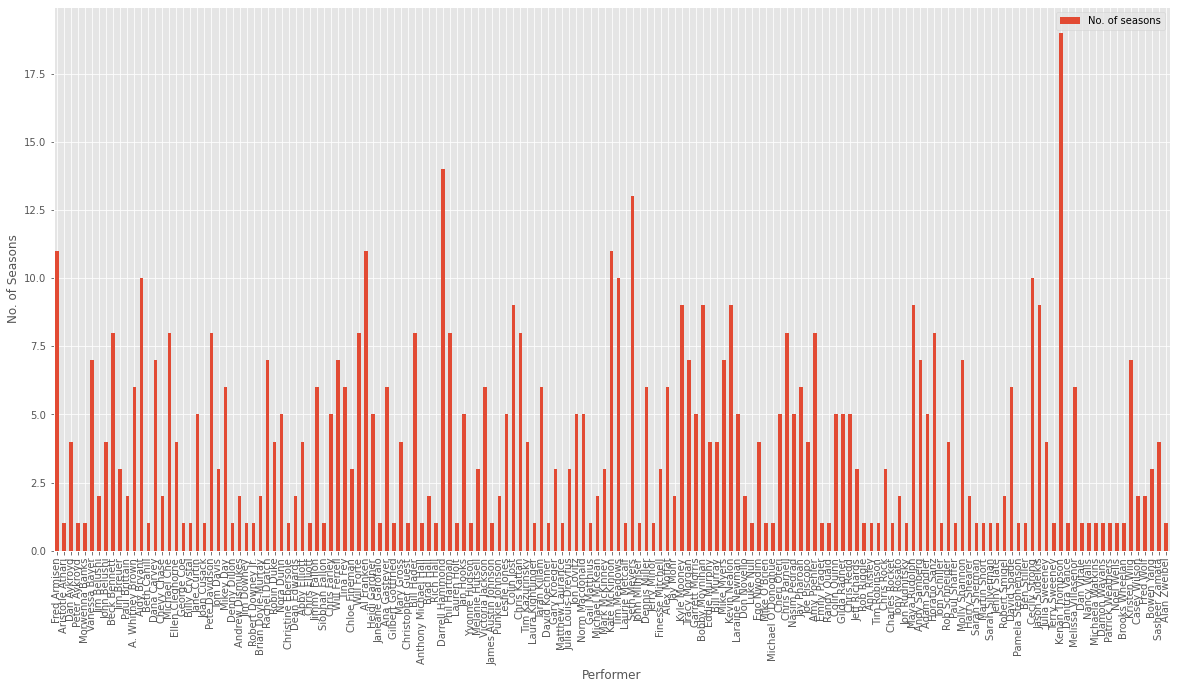

In [11]:
plt.style.use('ggplot')
ax = wiki_cast.plot(x= "Performer",y="No. of seasons", figsize = (20,10), kind = 'bar')
ax.set_ylabel('No. of Seasons')

In [15]:
# def cross_imdb_wiki():
#     for i in names['primaryName']:
#         print(i)
#         if i in wiki_cast['Performer']:
#             cross_imdb_wiki_list.append(i)
#     return cross_imdb_wiki_list

In [16]:
# cross_imdb_wiki()

In [12]:
imdb_names_df = imdb_names
imdb_names_df

nconst         primaryName birthYear deathYear  \
0         nm0000001        Fred Astaire      1899      1987   
1         nm0000002       Lauren Bacall      1924      2014   
2         nm0000003     Brigitte Bardot      1934        \N   
3         nm0000004        John Belushi      1949      1982   
4         nm0000005      Ingmar Bergman      1918      2007   
...             ...                 ...       ...       ...   
11554305  nm9993714   Romeo del Rosario        \N        \N   
11554306  nm9993716       Essias Loberg        \N        \N   
11554307  nm9993717  Harikrishnan Rajan        \N        \N   
11554308  nm9993718         Aayush Nair        \N        \N   
11554309  nm9993719          Andre Hill        \N        \N   

                            primaryProfession  \
0              soundtrack,actor,miscellaneous   
1                          actress,soundtrack   
2         actress,soundtrack,music_department   
3                     actor,soundtrack,writer   
4                       writer,director,actor   
...                                       ...   
11554305  animation_department,art_department   
11554306                                  NaN   
11554307                      cinematographer   
11554308                      cinematographer   
11554309                                  NaN   

                                   knownForTitles  
0         tt0050419,tt0053137,tt0031983,tt0072308  
1         tt0071877,tt0037382,tt0117057,tt0038355  
2         tt0054452,tt0056404,tt0057345,tt0049189  
3         tt0078723,tt0072562,tt0077975,tt0080455  
4         tt0069467,tt0083922,tt0060827,tt0050986  
...                                           ...  
11554305          tt14069590,tt11657662,tt2455546  
11554306                                       \N  
11554307                                tt8736744  
11554308                                       \N  
11554309                                       \N  

[11554310 rows x 6 columns]

In [13]:
imdb_name_list = imdb_names_df.values.tolist()
# imdb_name_list #with repeats, ALL NAMES

In [14]:
imdb_names_df.columns.tolist()

['nconst',
 'primaryName',
 'birthYear',
 'deathYear',
 'primaryProfession',
 'knownForTitles']

In [15]:
cross_imdb_wiki_list = []
for person in imdb_name_list:
    if person[1] in wiki_cast['Performer'].values:
        cross_imdb_wiki_list.append(person)

In [115]:
cross_name_list = (set([r[1] for r in cross_imdb_wiki_list]))
len(cross_name_list) # <- Missing 2 cast members

157

In [ ]:
# MAKING CSV FOR CROSS IMDb LIST
# import csv
# with open('imdb_wiki_filter.csv', 'w', encoding = 'utf-8') as outfile:
#     csvout = csv.writer(outfile)
#     csvout.writerow(names.columns.tolist())
#     csvout.writerows(cross_imdb_wiki_list)

In [17]:
from collections import Counter

Counter([r[1] for r in cross_imdb_wiki_list]).most_common(10)

[('Tom Davis', 56),
 ("Mike O'Brien", 56),
 ('Bill Murray', 35),
 ('Tim Robinson', 32),
 ('Leslie Jones', 26),
 ('Chris Elliott', 24),
 ('Mike Myers', 23),
 ('Jeff Richards', 23),
 ('Dennis Miller', 21),
 ('Victoria Jackson', 18)]

In [18]:
cross_imdb_wiki_list

[['nm0000004',
  'John Belushi',
  '1949',
  '1982',
  'actor,soundtrack,writer',
  'tt0078723,tt0072562,tt0077975,tt0080455'],
 ['nm0000101',
  'Dan Aykroyd',
  '1952',
  '\\N',
  'writer,actor,producer',
  'tt0097428,tt0118747,tt0087332,tt0080455'],
 ['nm0000195',
  'Bill Murray',
  '1950',
  '\\N',
  'actor,soundtrack,writer',
  'tt1748122,tt0128445,tt0362270,tt0335266'],
 ['nm0000196',
  'Mike Myers',
  '1963',
  '\\N',
  'actor,writer,soundtrack',
  'tt0295178,tt0145660,tt0118655,tt0811138'],
 ['nm0000331',
  'Chevy Chase',
  '1943',
  '\\N',
  'actor,writer,soundtrack',
  'tt0085995,tt0097958,tt0080487,tt0092086'],
 ['nm0000345',
  'Billy Crystal',
  '1948',
  '\\N',
  'actor,writer,producer',
  'tt0101587,tt0098635,tt0113097,tt0122933'],
 ['nm0000349',
  'Joan Cusack',
  '1962',
  '\\N',
  'actress,soundtrack,writer',
  'tt0119229,tt1659337,tt0119360,tt0096463'],
 ['nm0000375',
  'Robert Downey Jr.',
  '1965',
  '\\N',
  'actor,producer,soundtrack',
  'tt1300854,tt0371746,tt4154

In [19]:
def check_names(name):
    cross_name_list = (set([r[1] for r in cross_imdb_wiki_list]))
    result = False
    
    if name in cross_name_list:
        result = True
    return result

In [20]:
def check_creds(works):
    SNL_IDs = ['tt0715791', 'tt0715791', 'tt0971348', 'tt10809086', 'tt0072562', 'tt1372614', 'tt2173702']
    result = False
    for work in works.split(','):
        if work in SNL_IDs:
            result = True
    return result

In [21]:
check_creds('tt0460619,tt0157246,tt4116284,tt8324422')

False

In [22]:
SNL_name_check = [r for r in cross_imdb_wiki_list if check_names(r[1])]
(SNL_name_check)

[['nm0000004',
  'John Belushi',
  '1949',
  '1982',
  'actor,soundtrack,writer',
  'tt0078723,tt0072562,tt0077975,tt0080455'],
 ['nm0000101',
  'Dan Aykroyd',
  '1952',
  '\\N',
  'writer,actor,producer',
  'tt0097428,tt0118747,tt0087332,tt0080455'],
 ['nm0000195',
  'Bill Murray',
  '1950',
  '\\N',
  'actor,soundtrack,writer',
  'tt1748122,tt0128445,tt0362270,tt0335266'],
 ['nm0000196',
  'Mike Myers',
  '1963',
  '\\N',
  'actor,writer,soundtrack',
  'tt0295178,tt0145660,tt0118655,tt0811138'],
 ['nm0000331',
  'Chevy Chase',
  '1943',
  '\\N',
  'actor,writer,soundtrack',
  'tt0085995,tt0097958,tt0080487,tt0092086'],
 ['nm0000345',
  'Billy Crystal',
  '1948',
  '\\N',
  'actor,writer,producer',
  'tt0101587,tt0098635,tt0113097,tt0122933'],
 ['nm0000349',
  'Joan Cusack',
  '1962',
  '\\N',
  'actress,soundtrack,writer',
  'tt0119229,tt1659337,tt0119360,tt0096463'],
 ['nm0000375',
  'Robert Downey Jr.',
  '1965',
  '\\N',
  'actor,producer,soundtrack',
  'tt1300854,tt0371746,tt4154

In [23]:
SNL_cred_check = [r for r in cross_imdb_wiki_list if check_creds(r[5])]
(SNL_cred_check)

[['nm0000004',
  'John Belushi',
  '1949',
  '1982',
  'actor,soundtrack,writer',
  'tt0078723,tt0072562,tt0077975,tt0080455'],
 ['nm0000902',
  'Jim Belushi',
  '1954',
  '\\N',
  'actor,music_department,producer',
  'tt0097637,tt0072562,tt0117468,tt0095963'],
 ['nm0001022',
  'Dana Carvey',
  '1955',
  '\\N',
  'actor,soundtrack,writer',
  'tt0072562,tt0108525,tt0105793,tt0295427'],
 ['nm0005265',
  'Kevin Nealon',
  '1953',
  '\\N',
  'actor,writer,soundtrack',
  'tt0072562,tt0116483,tt0439100,tt0120888'],
 ['nm0035488',
  'Fred Armisen',
  '1966',
  '\\N',
  'music_department,actor,writer',
  'tt0357413,tt1282140,tt0072562,tt1780441'],
 ['nm0112944',
  'A. Whitney Brown',
  '1952',
  '\\N',
  'writer,actor',
  'tt0096708,tt0072562,tt0166039,tt1094991'],
 ['nm0128639',
  'Beth Cahill',
  '\\N',
  '\\N',
  'actress,costume_designer,miscellaneous',
  'tt0155764,tt0262411,tt0164930,tt0072562'],
 ['nm0205569',
  'Tom Davis',
  '1952',
  '2012',
  'writer,actor,producer',
  'tt0086465,tt

In [24]:
SNL_df = pd.DataFrame(SNL_cred_check, columns = imdb_names.columns.tolist()).set_index('primaryName')

In [25]:
SNL_df

nconst birthYear deathYear  \
primaryName                                      
John Belushi     nm0000004      1949      1982   
Jim Belushi      nm0000902      1954        \N   
Dana Carvey      nm0001022      1955        \N   
Kevin Nealon     nm0005265      1953        \N   
Fred Armisen     nm0035488      1966        \N   
...                    ...       ...       ...   
Aidy Bryant      nm5262775      1987        \N   
Chris Redd       nm5412083        \N        \N   
Fred Wolf        nm7440291        \N        \N   
Lauren Holt      nm7576527      1991        \N   
Andrew Dismukes  nm8608160        \N        \N   

                               primaryProfession  \
primaryName                                        
John Belushi             actor,soundtrack,writer   
Jim Belushi      actor,music_department,producer   
Dana Carvey              actor,soundtrack,writer   
Kevin Nealon             actor,writer,soundtrack   
Fred Armisen       music_department,actor,writer   
...                                          ...   
Aidy Bryant            actress,writer,soundtrack   
Chris Redd               actor,writer,soundtrack   
Fred Wolf                                  actor   
Lauren Holt                              actress   
Andrew Dismukes                     writer,actor   

                                            knownForTitles  
primaryName                                                 
John Belushi       tt0078723,tt0072562,tt0077975,tt0080455  
Jim Belushi        tt0097637,tt0072562,tt0117468,tt0095963  
Dana Carvey        tt0072562,tt0108525,tt0105793,tt0295427  
Kevin Nealon       tt0072562,tt0116483,tt0439100,tt0120888  
Fred Armisen       tt0357413,tt1282140,tt0072562,tt1780441  
...                                                    ...  
Aidy Bryant       tt5462602,tt11092142,tt8962130,tt0072562  
Chris Redd         tt3960412,tt5884792,tt7286456,tt0072562  
Fred Wolf                   tt3910602,tt10222674,tt0072562  
Lauren Holt        tt8394996,tt8937092,tt0072562,tt7546290  
Andrew Dismukes  tt14508698,tt0072562,tt13858722,tt6279022  

[61 rows x 5 columns]

In [26]:
wiki_cast = wiki_cast.set_index('Performer')

In [27]:
imdb_wiki_table = pd.concat([SNL_df, wiki_cast], axis=1, join="outer")

# IMDb Wiki Table concat
At this point, I have joined the Wiki and IMDb name tables together based on the cast member name. The joined table now has the unique cast member ID (nconst), birth and death years (where applicable), primary profession (actor dshould be in most, if not all of the cast professsion lists), known for titles (IMDb unique IDs for projects), Time on SNL (Years), No. of seasons, and whether or not they cast member was a: Repertory Player, Featured Player, Middle Group, "Weekend Update" Anchor, Host (after leaving the cast), and/or Writer.

For some reason, there are some cast members (Kristen Wiig, Bowen Yang, Sasheer Zamata, etc.) whose names aren't getting parsed from the IMDb data so I'll need to look into that further.

In [28]:
imdb_wiki_table

nconst birthYear deathYear  \
John Belushi      nm0000004      1949      1982   
Jim Belushi       nm0000902      1954        \N   
Dana Carvey       nm0001022      1955        \N   
Kevin Nealon      nm0005265      1953        \N   
Fred Armisen      nm0035488      1966        \N   
...                     ...       ...       ...   
Patrick Weathers        NaN       NaN       NaN   
Kristen Wiig            NaN       NaN       NaN   
Casey Wilson            NaN       NaN       NaN   
Bowen Yang              NaN       NaN       NaN   
Sasheer Zamata          NaN       NaN       NaN   

                                primaryProfession  \
John Belushi              actor,soundtrack,writer   
Jim Belushi       actor,music_department,producer   
Dana Carvey               actor,soundtrack,writer   
Kevin Nealon              actor,writer,soundtrack   
Fred Armisen        music_department,actor,writer   
...                                           ...   
Patrick Weathers                              NaN   
Kristen Wiig                                  NaN   
Casey Wilson                                  NaN   
Bowen Yang                                    NaN   
Sasheer Zamata                                NaN   

                                           knownForTitles   Time on SNL  \
John Belushi      tt0078723,tt0072562,tt0077975,tt0080455     1975–1979   
Jim Belushi       tt0097637,tt0072562,tt0117468,tt0095963     1983–1985   
Dana Carvey       tt0072562,tt0108525,tt0105793,tt0295427     1986–1993   
Kevin Nealon      tt0072562,tt0116483,tt0439100,tt0120888     1986–1995   
Fred Armisen      tt0357413,tt1282140,tt0072562,tt1780441     2002–2013   
...                                                   ...           ...   
Patrick Weathers                                      NaN     1980–1981   
Kristen Wiig                                          NaN     2005–2012   
Casey Wilson                                          NaN     2008–2009   
Bowen Yang                                            NaN  2019–present   
Sasheer Zamata                                        NaN     2014–2017   

                  No. of seasons Repertory Player Featured Player  \
John Belushi                   4              Yes              No   
Jim Belushi                    2              Yes              No   
Dana Carvey                    7              Yes              No   
Kevin Nealon                   9              Yes             Yes   
Fred Armisen                  11              Yes             Yes   
...                          ...              ...             ...   
Patrick Weathers               1               No             Yes   
Kristen Wiig                   7              Yes             Yes   
Casey Wilson                   2               No             Yes   
Bowen Yang                     3              Yes             Yes   
Sasheer Zamata                 4              Yes             Yes   

                 Middle Group "Weekend Update" Anchor Hosted Writer  
John Belushi               No                      No     No    Yes  
Jim Belushi                No                      No     No    Yes  
Dana Carvey                No                      No    Yes    Yes  
Kevin Nealon               No                     Yes     No    Yes  
Fred Armisen               No                      No    Yes     No  
...                       ...                     ...    ...    ...  
Patrick Weathers           No                      No     No     No  
Kristen Wiig               No                      No    Yes     No  
Casey Wilson               No                      No     No     No  
Bowen Yang                 No                      No     No    Yes  
Sasheer Zamata             No                      No     No     No  

[159 rows x 13 columns]

I am now attempting to create a dictionary of all the cast members and their IMDb "Known For Titles" to create a heatmap to show overlaps. Hopefully that will work but I am still in the process of figuring out how to do this. My plan is the following:
1. Use set() to get unique names
2. Intialize a dictionary where name is key and value is empty list `(John Belushi:[])` (result.index) LEN==159 values:empty lists
3. Loop over imdb data and extract primaryName and use primaryName `human[name].append(row)` where row in imdb
    - for row in imdb grab primary name -> name variable
    - `humans[name] += knownForTitles.split(‘,’)`
    - for human, knownfor in humans.items():
    - newhumans[human] = set(knownfor)
    - humans = unique humans with all known for items

In [29]:
# name_titles_dict = {}
# keys = cross_name_list
# for name in keys:
#     name_titles_dict[name] = []

# name_titles_dict

In [30]:
names_title_dict = {item[1]:item[5].split(',') for item in SNL_name_check}
names_title_dict

{'John Belushi': ['tt0078723', 'tt0072562', 'tt0077975', 'tt0080455'],
 'Dan Aykroyd': ['tt0097428', 'tt0118747', 'tt0087332', 'tt0080455'],
 'Bill Murray': ['tt5156614'],
 'Mike Myers': ['\\N'],
 'Chevy Chase': ['tt0085995', 'tt0097958', 'tt0080487', 'tt0092086'],
 'Billy Crystal': ['tt0101587', 'tt0098635', 'tt0113097', 'tt0122933'],
 'Joan Cusack': ['tt0119229', 'tt1659337', 'tt0119360', 'tt0096463'],
 'Robert Downey Jr.': ['tt1300854', 'tt0371746', 'tt4154796', 'tt0988045'],
 'Chris Farley': ['\\N'],
 'Janeane Garofalo': ['tt0382932', 'tt0132347', 'tt0117979', 'tt0243655'],
 'Julia Louis-Dreyfus': ['tt0462128', 'tt1759761', 'tt2390361', 'tt0098904'],
 'Eddie Murphy': ['tt0492509'],
 'Jim Belushi': ['tt0097637', 'tt0072562', 'tt0117468', 'tt0095963'],
 'Dana Carvey': ['tt0072562', 'tt0108525', 'tt0105793', 'tt0295427'],
 'Adam Sandler': ['tt13689618', 'tt10428498', 'tt0068120', 'tt12116598'],
 'Christopher Guest': ['tt4334642', 'tt1024855'],
 'Anthony Michael Hall': ['tt0468569', 't

In [31]:
# struggling quite a bit to get the unique project IDs
for i in SNL_name_check:
    unique_titles = []
    if i[1]== 'Bill Murray':
        print(set(i))
#     pattern = "[t]{2}[0-9]{7}"
#     regex = re.compile(pattern)
#     for i in regex.findall(SNL_name_check(i)):
#         unique_titles.append(i)
#         print(unique_titles)

{'actor,soundtrack,writer', 'nm0000195', '1950', '\\N', 'tt1748122,tt0128445,tt0362270,tt0335266', 'Bill Murray'}
{'nm0614853', '\\N', 'miscellaneous', 'Bill Murray', 'tt0097132'}
{'tt6384192,tt13998382', '\\N', 'Bill Murray', 'actor', 'nm10343807'}
{'camera_department', 'tt0288154,tt0189500', '\\N', 'Bill Murray', 'nm1162741'}
{'\\N', nan, 'Bill Murray', 'nm12931864'}
{'\\N', 'Bill Murray', 'actor', 'nm1386521', 'tt0351810'}
{'nm1831668', '\\N', 'tt0448004', 'Bill Murray', 'cinematographer'}
{'actor,writer', 'tt0457251,tt0961721', '\\N', 'nm1907457', 'Bill Murray'}
{'tt0122145', '\\N', 'Bill Murray', 'nm1981812', 'actor'}
{nan, 'tt0281438', '\\N', 'Bill Murray', 'nm2018971'}
{'editor,editorial_department', '\\N', 'tt1732762,tt1210095', 'nm2966932', 'Bill Murray'}
{'tt1490534', 'nm3578809', '\\N', 'Bill Murray', 'producer'}
{nan, '1908', 'tt1687207,tt1600694,tt1538443', 'nm3673242', '1986', 'Bill Murray'}
{'\\N', nan, 'Bill Murray', 'nm3890281'}
{'tt1810727', 'nm4257796', '\\N', 'Bill 

In [32]:
type(SNL_name_check)

list

In [39]:
# for i in (SNL_name_check):
#     unique_titles = []
#     for x in i:
#         if str(x).startswith('tt'):
#             tt = x.split(',')
#             for title in tt:
#                 if title not in unique_titles:
#                     print(i[1],title)
#                     unique_titles.append(title)
#                 print(unique_titles)
#             for name in names_title_dict:
#                 if i[1] == name:
#                     names_title_dict[name].append(unique_titles)

#                     print(i[1],unique_titles)

In [40]:
# names_title_dict

In [41]:
# for i in (SNL_name_check):
#     unique_titles = []
#     for x in i:
#         for name in names_title_dict:
#             if str(x).startswith('tt'):
#                 tt = str(x).split(',')
# #                 print(tt)
#                 if i[1] == name:
#                     unique_titles.append(tt)
#                     names_title_dict.update({i[1]:unique_titles})

#                     print(i[1],unique_titles)
# #                 print(unique_titles)

In [42]:
# Counter(names_title_dict.keys())

In [43]:
# for i in (SNL_name_check):
#     for x in i:
#         unique_titles = []
#         if str(x).startswith('tt'):
#             tt = x.split(',')
#             unique_titles = unique_titles.append(tt)
# #             print(unique_titles)
#     if i[1] == names_title_dict.keys():
#         names_title_dict.items(unique_titles)
#     print(i[1], tt)

In [33]:
for i in SNL_name_check:
    for x in i:
        if str(x).startswith('tt'):
            titles = x.split(',')
    
    name = i[1]
    names_title_dict[name] += titles

for name, titles in names_title_dict.items():
    names_title_dict[name] = list(set(titles))

In [34]:
names_title_dict

{'John Belushi': ['tt0072562', 'tt0077975', 'tt0078723', 'tt0080455'],
 'Dan Aykroyd': ['tt0118747', 'tt0087332', 'tt0097428', 'tt0080455'],
 'Bill Murray': ['tt1687207',
  'tt2784678',
  'tt0122145',
  'tt3603706',
  'tt1810727',
  'tt5156614',
  'tt16589596',
  'tt2282941',
  'tt1538443',
  'tt13998382',
  'tt3091734',
  'tt4742812',
  'tt1740656',
  'tt14779558',
  'tt3872944',
  'tt0362270',
  'tt3790306',
  'tt3503754',
  'tt2243836',
  'tt2357748',
  'tt0281438',
  'tt1732762',
  'tt1490534',
  'tt1600694',
  'tt0448004',
  'tt0128445',
  'tt2356940',
  'tt4571940',
  'tt1837678',
  'tt3147486',
  'tt2828570',
  'tt0351810',
  'tt0335266',
  'tt5774598',
  'tt1884251',
  'tt1210095',
  'tt2147467',
  'tt1972582',
  'tt0457251',
  'tt2450652',
  'tt0961721',
  'tt0189500',
  'tt3231836',
  'tt0072562',
  'tt1748122',
  'tt12762460',
  'tt2202391',
  'tt0288154',
  'tt1911645',
  'tt0115367',
  'tt0499556',
  'tt0097132',
  'tt6384192'],
 'Mike Myers': ['tt4670472',
  'tt4497152',


In [35]:
# names_title_dict['Bill Murray']

In [36]:
import csv
headers = ['name', 'title']
rows = []
for name, titles in names_title_dict.items():
    for t in titles:
        rows.append([name, t])


with open('snl_name_title_nodes.csv', 'w', encoding = 'utf-8') as outfile:
    csvout = csv.writer(outfile)
    csvout.writerow(headers)
    csvout.writerows(rows)

In [37]:
import pygraphviz as pgv

G = pgv.AGraph(names_title_dict,
               strict=True,
               directed=True,
               rankdir="RL",
               ranksep="0.25",
               ordering="in")

G.layout('dot')

G.draw('name_to_titles.png')

G.draw('name_to_titles.svg')

/Users/tzacks2/.conda/envs/DataViz2/lib/python3.7/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.403878 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


In [38]:
import pygraphviz as pgv

G = pgv.AGraph(same_title_dict,
               strict=True,
               directed=False,
               rankdir="RL",
               ranksep="0.25",
               ordering="in")

G.layout('dot')

G.draw('title_to_names.png')

G.draw('title_to_names.svg')

NameError: name 'same_title_dict' is not defined

Now to create an inverse dictionary

In [39]:
names_title_dict

{'John Belushi': ['tt0072562', 'tt0077975', 'tt0078723', 'tt0080455'],
 'Dan Aykroyd': ['tt0118747', 'tt0087332', 'tt0097428', 'tt0080455'],
 'Bill Murray': ['tt1687207',
  'tt2784678',
  'tt0122145',
  'tt3603706',
  'tt1810727',
  'tt5156614',
  'tt16589596',
  'tt2282941',
  'tt1538443',
  'tt13998382',
  'tt3091734',
  'tt4742812',
  'tt1740656',
  'tt14779558',
  'tt3872944',
  'tt0362270',
  'tt3790306',
  'tt3503754',
  'tt2243836',
  'tt2357748',
  'tt0281438',
  'tt1732762',
  'tt1490534',
  'tt1600694',
  'tt0448004',
  'tt0128445',
  'tt2356940',
  'tt4571940',
  'tt1837678',
  'tt3147486',
  'tt2828570',
  'tt0351810',
  'tt0335266',
  'tt5774598',
  'tt1884251',
  'tt1210095',
  'tt2147467',
  'tt1972582',
  'tt0457251',
  'tt2450652',
  'tt0961721',
  'tt0189500',
  'tt3231836',
  'tt0072562',
  'tt1748122',
  'tt12762460',
  'tt2202391',
  'tt0288154',
  'tt1911645',
  'tt0115367',
  'tt0499556',
  'tt0097132',
  'tt6384192'],
 'Mike Myers': ['tt4670472',
  'tt4497152',


In [40]:
same_title_dict = {}
unique_title_list = []
for x in names_title_dict:
#     print((x))
    for unique_title in names_title_dict[x]:
        if unique_title not in unique_title_list:
            unique_title_list.append(unique_title)
    per_title_name_list = []
    for i in unique_title_list:
        
        if names_title_dict[x] == i:
            
            per_title_name_list.append(name_titles_dict[x])
        same_title_dict[i] = per_title_name_list

In [41]:
same_title_dict

{'tt0072562': [],
 'tt0077975': [],
 'tt0078723': [],
 'tt0080455': [],
 'tt0118747': [],
 'tt0087332': [],
 'tt0097428': [],
 'tt1687207': [],
 'tt2784678': [],
 'tt0122145': [],
 'tt3603706': [],
 'tt1810727': [],
 'tt5156614': [],
 'tt16589596': [],
 'tt2282941': [],
 'tt1538443': [],
 'tt13998382': [],
 'tt3091734': [],
 'tt4742812': [],
 'tt1740656': [],
 'tt14779558': [],
 'tt3872944': [],
 'tt0362270': [],
 'tt3790306': [],
 'tt3503754': [],
 'tt2243836': [],
 'tt2357748': [],
 'tt0281438': [],
 'tt1732762': [],
 'tt1490534': [],
 'tt1600694': [],
 'tt0448004': [],
 'tt0128445': [],
 'tt2356940': [],
 'tt4571940': [],
 'tt1837678': [],
 'tt3147486': [],
 'tt2828570': [],
 'tt0351810': [],
 'tt0335266': [],
 'tt5774598': [],
 'tt1884251': [],
 'tt1210095': [],
 'tt2147467': [],
 'tt1972582': [],
 'tt0457251': [],
 'tt2450652': [],
 'tt0961721': [],
 'tt0189500': [],
 'tt3231836': [],
 'tt1748122': [],
 'tt12762460': [],
 'tt2202391': [],
 'tt0288154': [],
 'tt1911645': [],
 'tt01

In [42]:
name = names_title_dict.keys()
title = same_title_dict.keys()
for title in same_title_dict:
#     print(title)
    name_list = []
#     print(name)
    for name in names_title_dict:
        if str(title) in names_title_dict[name] and name not in name_list:
#             print(name,title)
            name_list.append(name)
    same_title_dict[title] = name_list
            #     same_title_dict[title] = list((name))

In [43]:
same_title_dict

{'tt0072562': ['John Belushi',
  'Bill Murray',
  'Jim Belushi',
  'Dana Carvey',
  'Kevin Nealon',
  'Fred Armisen',
  'A. Whitney Brown',
  'Beth Cahill',
  'Pete Davidson',
  'Tom Davis',
  'Robin Duke',
  'Chris Elliott',
  'Al Franken',
  'Mary Gross',
  'Rich Hall',
  'Darrell Hammond',
  'Phil Hartman',
  'Yvonne Hudson',
  'Melanie Hutsell',
  'Leslie Jones',
  'Tim Kazurinsky',
  'Taran Killam',
  'Gary Kroeger',
  'Gail Matthius',
  'Kate McKinnon',
  'Tracy Morgan',
  'Garrett Morris',
  'Don Novello',
  "Michael O'Donoghue",
  'Joe Piscopo',
  'Amy Poehler',
  'Gilda Radner',
  'Jeff Richards',
  'Ann Risley',
  'Tim Robinson',
  'Tom Schiller',
  'Robert Smigel',
  'Kenan Thompson',
  'Dan Vitale',
  'Fred Wolf',
  'Alan Zweibel',
  'Seth Meyers',
  'Lauren Holt',
  'Bobby Moynihan',
  'Finesse Mitchell',
  'Mikey Day',
  'Andy Samberg',
  'Paul Brittain',
  'Colin Jost',
  'Abby Elliott',
  'John Milhiser',
  'Vanessa Bayer',
  'Noël Wells',
  'Luke Null',
  'Melissa Vill

In [44]:
# names_title_dict["Bill Murray"]

In [45]:
same_title_dict['tt0499556']

['Bill Murray', 'Michael Che']

# VIIIZZZZZZ

In [46]:
# https://stackoverflow.com/questions/41964618/boolean-matrix-form-pythons-dict-of-lists
values = list(set([x for y in names_title_dict.values() for x in y]))
data = {}
for key in names_title_dict.keys():
    data[key] = [True if value in names_title_dict[key] else False for value in values]
 
boolean_table_name_cols = pd.DataFrame(data, index=values)
pd.DataFrame(boolean_table_name_cols)

John Belushi  Dan Aykroyd  Bill Murray  Mike Myers  Chevy Chase  \
tt0072792         False        False        False       False        False   
tt1387418         False        False        False       False        False   
tt2784678         False        False         True       False        False   
tt0295476         False        False        False       False        False   
tt3603706         False        False         True       False        False   
...                 ...          ...          ...         ...          ...   
tt0120791         False        False        False       False        False   
tt0800325         False        False        False       False        False   
tt3793204         False        False        False       False        False   
tt0773756         False        False        False       False        False   
tt2527336         False        False        False       False        False   

           Billy Crystal  Joan Cusack  Robert Downey Jr.  Chris Farley  \
tt0072792          False        False              False         False   
tt1387418          False        False              False         False   
tt2784678          False        False              False         False   
tt0295476          False        False              False         False   
tt3603706          False        False              False         False   
...                  ...          ...                ...           ...   
tt0120791          False        False              False         False   
tt0800325          False        False              False         False   
tt3793204          False        False              False         False   
tt0773756          False        False              False         False   
tt2527336          False        False              False         False   

           Janeane Garofalo  ...  Ego Nwodim  Brooks Wheelan  Cecily Strong  \
tt0072792             False  ...       False           False          False   
tt1387418             False  ...       False           False          False   
tt2784678             False  ...       False           False          False   
tt0295476             False  ...       False           False          False   
tt3603706             False  ...       False           False          False   
...                     ...  ...         ...             ...            ...   
tt0120791             False  ...       False           False          False   
tt0800325             False  ...       False           False          False   
tt3793204             False  ...       False           False          False   
tt0773756             False  ...       False           False          False   
tt2527336             False  ...       False           False          False   

           Aidy Bryant  Chris Redd  Jim Downey  Bowen Yang  Andrew Dismukes  \
tt0072792        False       False       False       False            False   
tt1387418        False       False       False       False            False   
tt2784678        False       False       False       False            False   
tt0295476        False       False       False       False            False   
tt3603706        False       False       False       False            False   
...                ...         ...         ...         ...              ...   
tt0120791        False       False       False       False            False   
tt0800325        False       False       False       False            False   
tt3793204        False       False       False       False            False   
tt0773756        False       False       False       False            False   
tt2527336        False       False       False       False            False   

           Siobhan Fallon  Punkie Johnson  
tt0072792           False           False  
tt1387418           False           False  
tt2784678           False           False  
tt0295476           False           False  
tt3603706           False           False  
...                   .

In [47]:
# https://stackoverflow.com/questions/41964618/boolean-matrix-form-pythons-dict-of-lists
values = list(set([x for y in same_title_dict.values() for x in y]))
data = {}
for key in same_title_dict.keys():
    data[key] = [ True if value in same_title_dict[key] else False for value in values ]
 
boolean_table_title_cols = pd.DataFrame(data, index=values)
pd.DataFrame(boolean_table_title_cols)

tt0072562  tt0077975  tt0078723  tt0080455  tt0118747  \
David Spade         False      False      False      False      False   
Michael McKean      False      False      False      False      False   
Chloe Fineman        True      False      False      False      False   
Lauren Holt          True      False      False      False      False   
Seth Meyers          True      False      False      False      False   
...                   ...        ...        ...        ...        ...   
Sarah Sherman       False      False      False      False      False   
Ben Stiller         False      False      False      False      False   
Randy Quaid         False      False      False      False      False   
Alex Moffat         False      False      False      False      False   
Phil Hartman         True      False      False      False      False   

                tt0087332  tt0097428  tt1687207  tt2784678  tt0122145  ...  \
David Spade         False      False      False      False      False  ...   
Michael McKean      False      False      False      False      False  ...   
Chloe Fineman       False      False      False      False      False  ...   
Lauren Holt         False      False      False      False      False  ...   
Seth Meyers         False      False      False      False      False  ...   
...                   ...        ...        ...        ...        ...  ...   
Sarah Sherman       False      False      False      False      False  ...   
Ben Stiller         False      False      False      False      False  ...   
Randy Quaid         False      False      False      False      False  ...   
Alex Moffat         False      False      False      False      False  ...   
Phil Hartman        False      False      False      False      False  ...   

                tt2587452  tt6078096  tt13858722  tt6279022  tt14508698  \
David Spade         False      False       False      False       False   
Michael McKean      False      False       False      False       False   
Chloe Fineman       False      False       False      False       False   
Lauren Holt         False      False       False      False       False   
Seth Meyers         False      False       False      False       False   
...                   ...        ...         ...        ...         ...   
Sarah Sherman       False      False       False      False       False   
Ben Stiller         False      False       False      False       False   
Randy Quaid         False      False       False      False       False   
Alex Moffat         False      False       False      False       False   
Phil Hartman        False      False       False      False       False   

                tt6463510  tt5117666  tt7242698  tt5821764  tt7778796  
David Spade         False      False      False      False      False  
Michael McKean      False      False      False      False      False  
Chloe Fineman       False      False      False      False      False  
Lauren Holt         False      False      False      False      False  
Seth Meyers         False      False      False      False      False  
...                   ...        ...        ...        ...        ...  
Sarah Sherman       False      False      False      False      False  
Ben Stiller         False      False      False      False      False  
Randy Quaid         False      False      False      False      False  
Alex Moffat         False      False      False      False      False  
Phil Hartman        False      False      False      False      False  

[157 rows x 1127 columns]

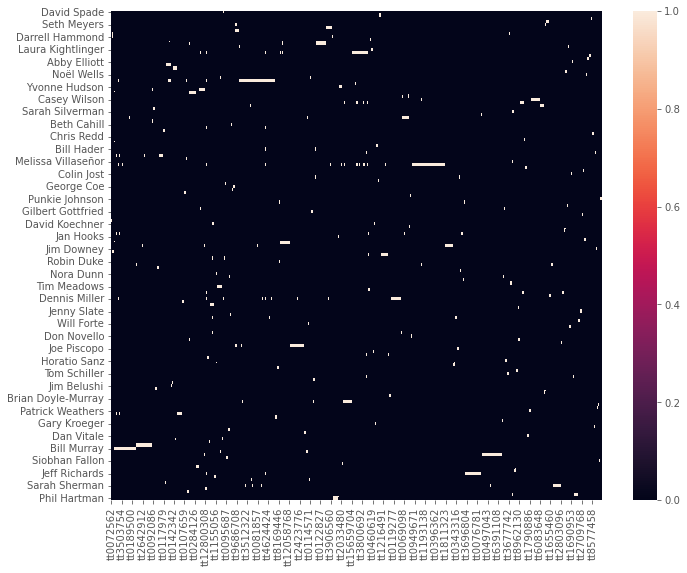

In [48]:
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(boolean_table_title_cols)
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

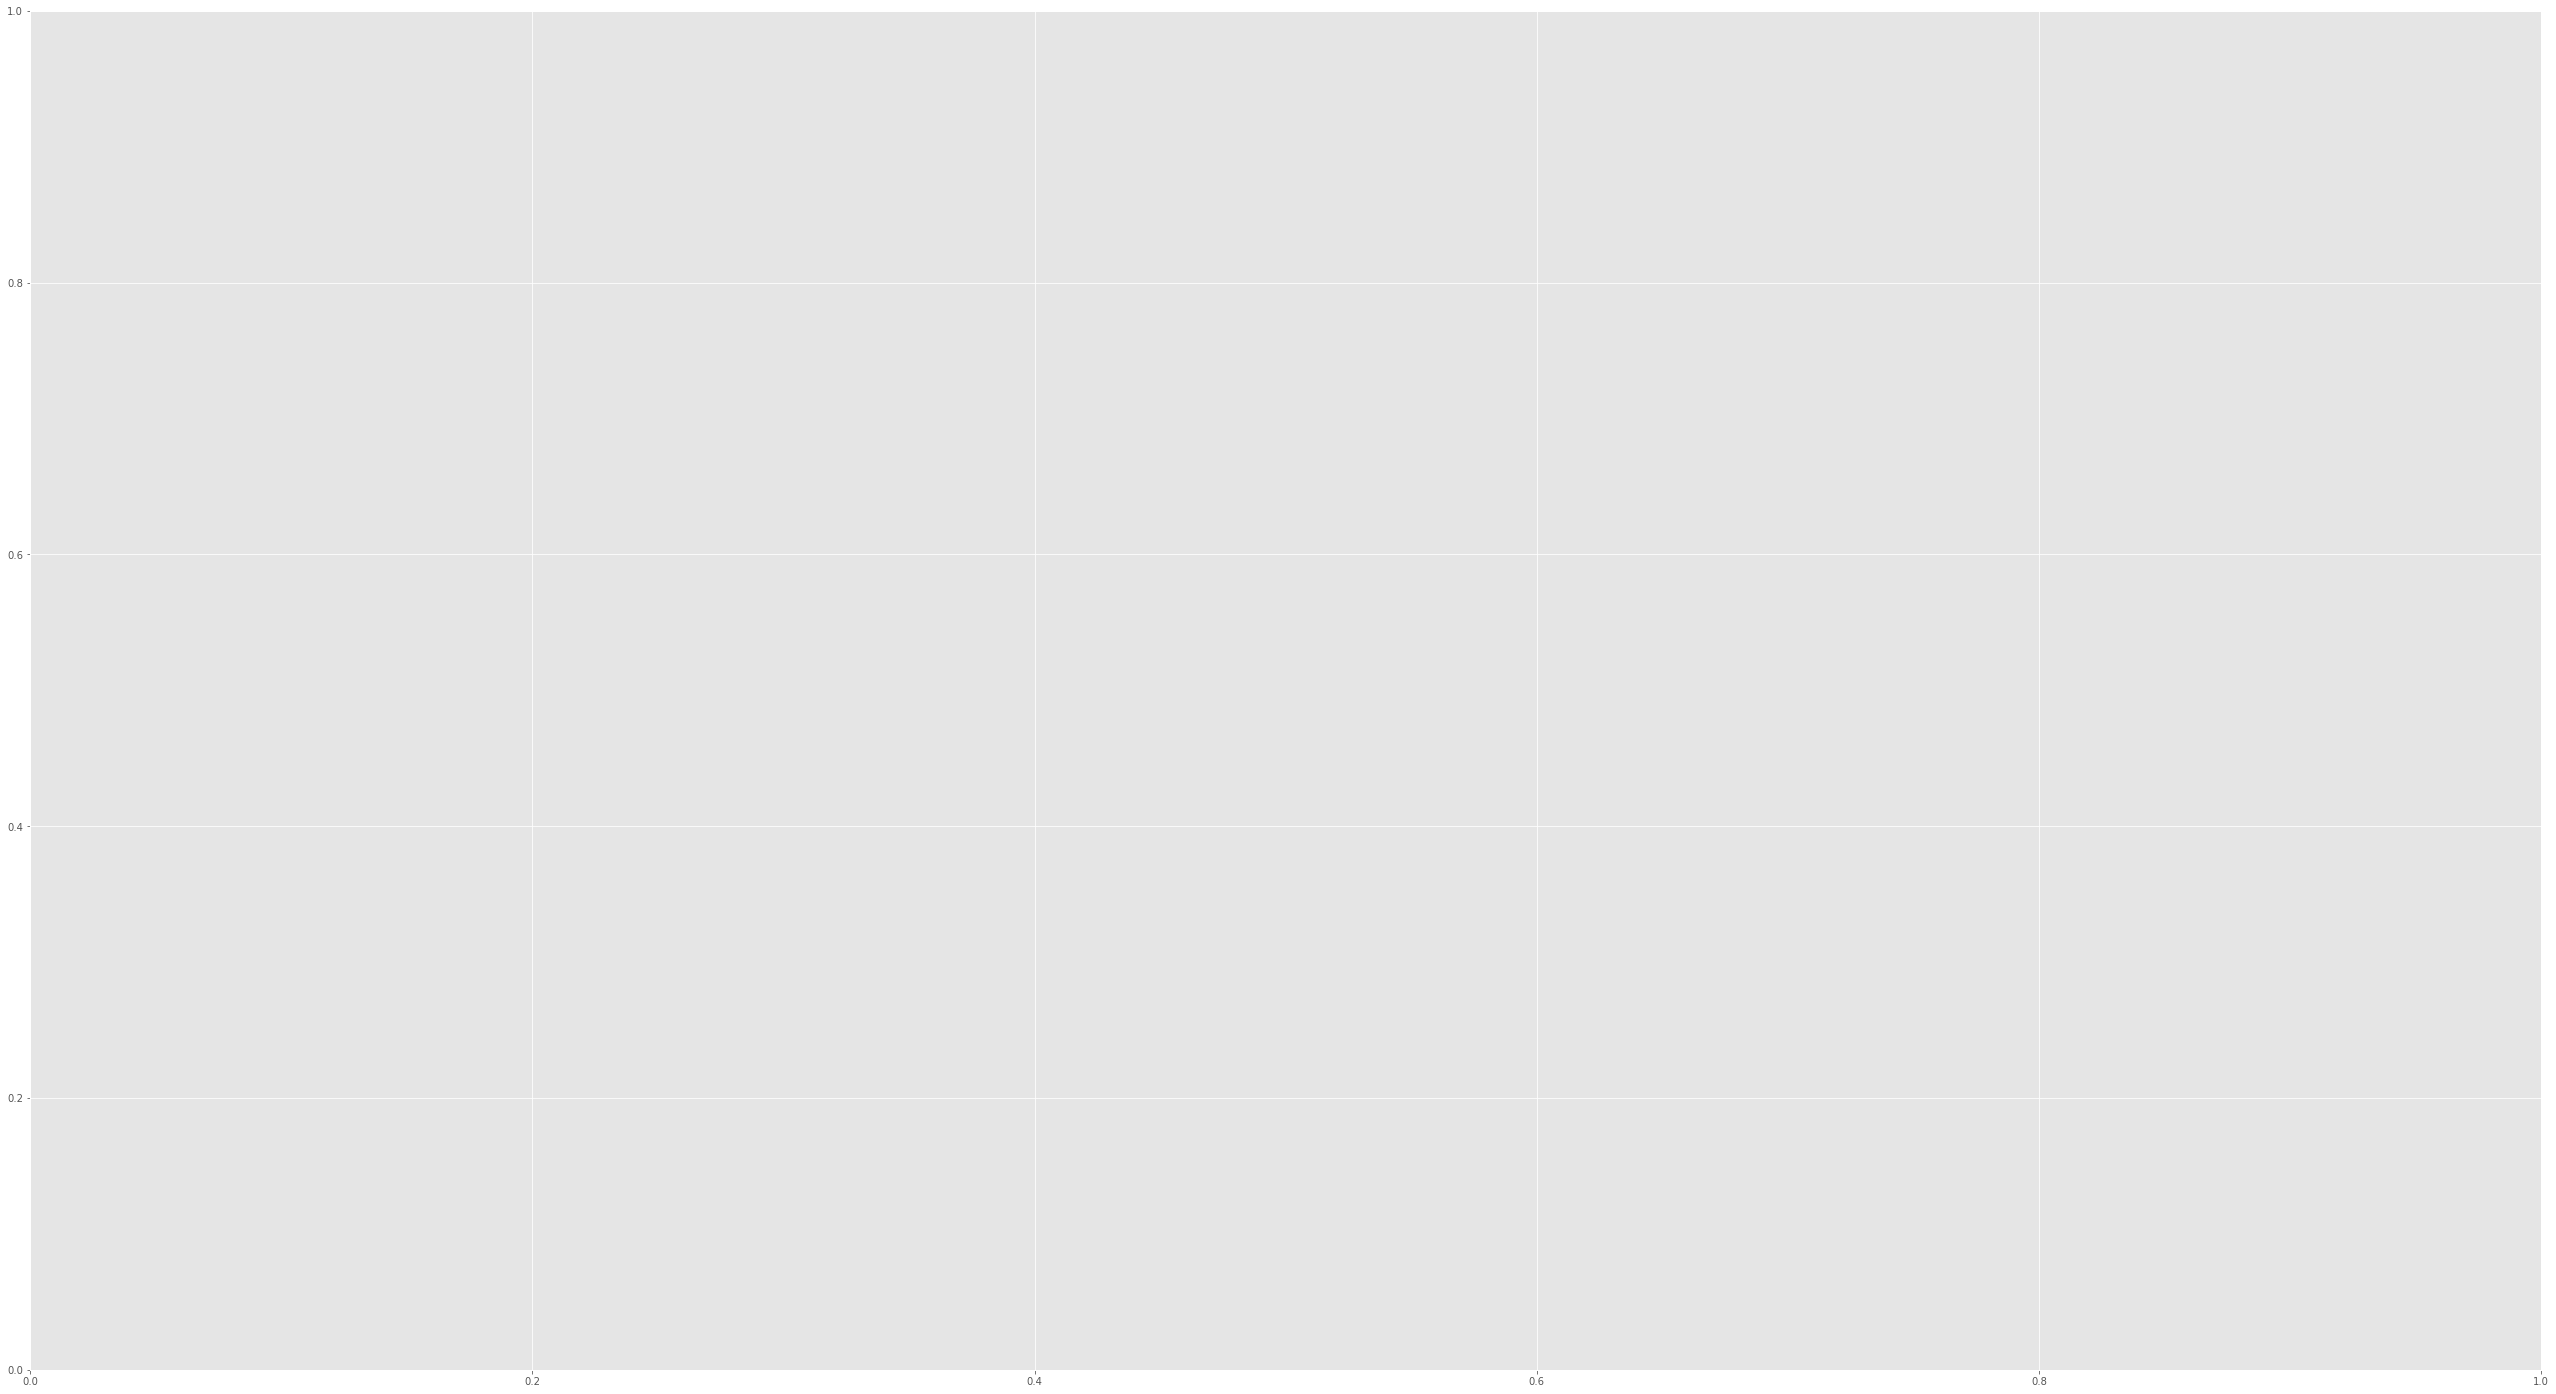

In [116]:
fig, ax = plt.subplots(figsize=(45, 25))
sb.heatmap(boolean_table_name_cols)
plt.show()

In [50]:
names_title_dict['Mike O\'Brien']

['tt9734382',
 'tt1387418',
 'tt0127341',
 'tt0153362',
 'tt0949671',
 'tt0109021',
 'tt2347497',
 'tt2247021',
 'tt0294941',
 'tt1326172',
 'tt2998406',
 'tt11348726',
 'tt1493558',
 'tt0401759',
 'tt15669416',
 'tt2156935',
 'tt0159876',
 'tt7498020',
 'tt0120841',
 'tt1357005',
 'tt0775529',
 'tt3972208',
 'tt0238305',
 'tt4397866',
 'tt3562462',
 'tt12661304',
 'tt7119506',
 'tt11394180',
 'tt9883024',
 'tt1170243',
 'tt1716744',
 'tt4742812',
 'tt14643040',
 'tt0335620',
 'tt1193138',
 'tt1448500',
 'tt4568496',
 'tt2828570',
 'tt0494864',
 'tt3783812',
 'tt0217061',
 'tt2423776',
 'tt4977374',
 'tt1366945',
 'tt2142935',
 'tt5352578',
 'tt1636189',
 'tt2300919',
 'tt0117652',
 'tt3906560',
 'tt0470023',
 'tt4229954',
 'tt0313038',
 'tt9090184',
 'tt1478338',
 'tt1100051',
 'tt0359950',
 'tt8554874',
 'tt2182211',
 'tt0281438',
 'tt1095174',
 'tt1636331',
 'tt0051297',
 'tt5774598',
 'tt0398291',
 'tt0238303',
 'tt3856408',
 'tt0464041',
 'tt0238304',
 'tt1730767',
 'tt0396362',
 

In [118]:
g = nx.DiGraph(same_title_dict)
g.add_nodes_from(same_title_dict.keys())
for k, v in same_title_dict.items():
    g.add_edges_from(([(k, t) for t in v]))
    node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'),
        line_width=2))
nx.draw(g,with_labels=True)

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(g.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text
# Create Network Graph
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=24,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))                )
fig.show()

NameError: name 'node_x' is not defined

In [117]:
# G = nx.random_geometric_graph(200, 0.125)
# # Create Edges
# # Add edges as disconnected lines in a single trace and nodes as a scatter trace

# edge_x = []
# edge_y = []
# for edge in G.edges():
#     x0, y0 = G.nodes[edge[0]]['pos']
#     x1, y1 = G.nodes[edge[1]]['pos']
#     edge_x.append(x0)
#     edge_x.append(x1)
#     edge_x.append(None)
#     edge_y.append(y0)
#     edge_y.append(y1)
#     edge_y.append(None)

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y,
#     line=dict(width=0.5, color='#888'),
#     hoverinfo='none',
#     mode='lines')

# node_x = []
# node_y = []
# for node in G.nodes():
#     x, y = G.nodes[node]['pos']
#     node_x.append(x)
#     node_y.append(y)

# node_trace = go.Scatter(
#     x=node_x, y=node_y,
#     mode='markers',
#     hoverinfo='text',
#     marker=dict(
#         showscale=True,
#         # colorscale options
#         #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
#         #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
#         #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
#         colorscale='YlGnBu',
#         reversescale=True,
#         color=[],
#         size=10,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
#         line_width=2))
# # Color Node Points
# # Color node points by the number of connections.

# # Another option would be to size points by the number of connections i.e. node_trace.marker.size = node_adjacencies

# node_adjacencies = []
# node_text = []
# for node, adjacencies in enumerate(G.adjacency()):
#     node_adjacencies.append(len(adjacencies[1]))
#     node_text.append('# of connections: '+str(len(adjacencies[1])))

# node_trace.marker.color = node_adjacencies
# node_trace.text = node_text
# # Create Network Graph
# fig = go.Figure(data=[edge_trace, node_trace],
#              layout=go.Layout(
#                 title='<br>Network graph made with Python',
#                 titlefont_size=16,
#                 showlegend=False,
#                 hovermode='closest',
#                 margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
#                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))                )
# fig.show()

John Belushi ['tt0072562', 'tt0077975', 'tt0078723', 'tt0080455']
John Belushi
[True, True, True, True]
Dan Aykroyd
[False, False, False, True]
Bill Murray
[True, False, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[True, False, False, False]
Dana Carvey
[True, False, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, False]
Mart

Mike O'Brien
[False, False, False, False]
Michael O'Donoghue
[False, False, False, False]
Cheri Oteri
[False, False, False, False]
Chris Parnell
[False, False, False, False]
Joe Piscopo
[False, False, False, False]
Amy Poehler
[False, False, False, False]
Emily Prager
[False, False, False, False]
Colin Quinn
[False, False, False, False]
Gilda Radner
[False, False, False, False]
Tony Rosato
[False, False, False, False]
Jeff Richards
[False, False, False, False]
Ann Risley
[False, False, False, False]
Tim Robinson
[False, False, False, False]
Harry Shearer
[False, False, False, False]
Charles Rocket
[False, False, False, False]
Maya Rudolph
[False, False, False, False]
Horatio Sanz
[False, False, False, False]
Tom Schiller
[False, False, False, False]
Paul Shaffer
[False, False, False, False]
Molly Shannon
[False, False, False, False]
Sarah Silverman
[False, False, False, False]
Robert Smigel
[False, False, False, False]
Pamela Stephenson
[False, False, False, False]
Jason Sudeikis
[Fals

[False, False, False, False]
Jenny Slate
[False, False, False, False]
Beck Bennett
[False, False, False, False]
Vanessa Bayer
[False, True, False, False]
Sasheer Zamata
[False, False, False, False]
Noël Wells
[False, True, False, False]
Luke Null
[False, True, False, False]
Melissa Villaseñor
[False, True, False, False]
Michael Che
[False, True, False, False]
Jay Pharoah
[False, True, False, False]
Jon Rudnitsky
[False, True, False, False]
James Austin Johnson
[False, True, False, False]
Chloe Fineman
[False, True, False, False]
Ego Nwodim
[False, True, False, False]
Brooks Wheelan
[False, True, False, False]
Cecily Strong
[False, True, False, False]
Aidy Bryant
[False, True, False, False]
Chris Redd
[False, True, False, False]
Jim Downey
[False, False, False, False]
Bowen Yang
[False, False, False, False]
Andrew Dismukes
[False, True, False, False]
Siobhan Fallon
[False, False, False, False]
Punkie Johnson
[False, False, False, False]
Dana Carvey ['tt0105793', 'tt0072562', 'tt0295427'

[False, False, False, False]
Tim Meadows
[False, False, False, False]
Kevin Nealon
[False, False, False, False]
David Spade
[False, False, False, False]
Fred Armisen
[False, False, False, False]
Peter Aykroyd
[False, False, False, False]
Morwenna Banks
[False, False, False, False]
Jim Breuer
[False, False, False, False]
A. Whitney Brown
[False, False, False, False]
Beth Cahill
[False, False, False, False]
Ellen Cleghorne
[False, False, False, False]
George Coe
[False, False, False, False]
Pete Davidson
[False, False, False, False]
Tom Davis
[False, False, False, False]
Denny Dillon
[False, False, False, False]
Brian Doyle-Murray
[False, False, False, True]
Rachel Dratch
[False, False, False, False]
Robin Duke
[False, False, False, False]
Dean Edwards
[False, False, False, False]
Chris Elliott
[False, False, False, False]
Jimmy Fallon
[False, False, False, False]
Tina Fey
[False, False, False, False]
Will Forte
[False, False, False, False]
Al Franken
[False, False, False, False]
Ana Gas

/Users/tzacks2/.conda/envs/DataViz2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


 ['tt0061240', 'tt0061296', 'tt0062994', 'tt0058797', 'tt0445934', 'tt0357413', 'tt5779664', 'tt11462908', 'tt1229340', 'tt0415306']
John Belushi
[False, False, False, False, False, False, False, False, False, False]
Dan Aykroyd
[False, False, False, False, False, False, False, False, False, False]
Bill Murray
[False, False, False, False, False, False, False, False, False, False]
Mike Myers
[False, False, False, False, False, False, False, False, False, False]
Chevy Chase
[False, False, False, False, False, False, False, False, False, False]
Billy Crystal
[False, False, False, False, False, False, False, False, False, False]
Joan Cusack
[False, False, False, False, False, False, False, False, False, False]
Robert Downey Jr.
[False, False, False, False, False, False, False, False, False, False]
Chris Farley
[False, False, False, False, False, False, False, False, False, False]
Janeane Garofalo
[False, False, False, False, False, False, False, False, False, False]
Julia Louis-Dreyfus
[Fa

[False, False, False, False]
Rob Riggle
[False, False, False, False]
Finesse Mitchell
[False, True, False, False]
Mikey Day
[False, True, False, False]
Andy Samberg
[False, True, False, False]
Paul Brittain
[False, True, False, False]
Nasim Pedrad
[False, False, False, False]
Colin Jost
[False, True, False, False]
Abby Elliott
[False, True, False, False]
John Milhiser
[False, True, False, False]
Alex Moffat
[False, False, False, False]
Aristotle Athari
[False, False, False, False]
Jenny Slate
[False, False, False, False]
Beck Bennett
[False, False, False, False]
Vanessa Bayer
[False, True, False, False]
Sasheer Zamata
[False, False, False, False]
Noël Wells
[False, True, False, False]
Luke Null
[False, True, False, False]
Melissa Villaseñor
[False, True, False, False]
Michael Che
[False, True, False, False]
Jay Pharoah
[False, True, False, False]
Jon Rudnitsky
[False, True, False, False]
James Austin Johnson
[False, True, False, False]
Chloe Fineman
[False, True, False, False]
Ego Nwod

Laraine Newman
[False, False, False, False]
Don Novello
[False, False, False, False]
Mike O'Brien
[False, False, False, False]
Michael O'Donoghue
[False, False, False, False]
Cheri Oteri
[False, False, False, False]
Chris Parnell
[False, False, False, False]
Joe Piscopo
[False, False, False, False]
Amy Poehler
[False, False, False, False]
Emily Prager
[False, False, False, False]
Colin Quinn
[False, False, False, False]
Gilda Radner
[False, False, False, False]
Tony Rosato
[False, False, False, False]
Jeff Richards
[False, False, False, False]
Ann Risley
[False, False, False, False]
Tim Robinson
[False, False, False, False]
Harry Shearer
[False, False, False, False]
Charles Rocket
[False, False, False, False]
Maya Rudolph
[False, False, False, False]
Horatio Sanz
[False, False, False, False]
Tom Schiller
[False, False, False, False]
Paul Shaffer
[False, False, False, False]
Molly Shannon
[False, False, False, False]
Sarah Silverman
[False, False, False, False]
Robert Smigel
[False, Fal

[False, False, False, False]
Jane Curtin
[False, False, False, False]
Nora Dunn
[False, False, False, False]
Tim Meadows
[False, False, False, False]
Kevin Nealon
[False, True, False, False]
David Spade
[False, False, False, False]
Fred Armisen
[False, True, False, False]
Peter Aykroyd
[False, False, False, False]
Morwenna Banks
[False, False, False, False]
Jim Breuer
[False, False, False, False]
A. Whitney Brown
[False, True, False, False]
Beth Cahill
[False, True, False, False]
Ellen Cleghorne
[False, False, False, False]
George Coe
[False, False, False, False]
Pete Davidson
[False, True, False, False]
Tom Davis
[False, True, False, False]
Denny Dillon
[False, False, False, False]
Brian Doyle-Murray
[False, False, False, False]
Rachel Dratch
[False, False, False, False]
Robin Duke
[True, True, True, True]
Dean Edwards
[False, False, False, False]
Chris Elliott
[True, True, False, False]
Jimmy Fallon
[False, False, False, False]
Tina Fey
[False, False, False, False]
Will Forte
[False,

Ana Gasteyer ['tt0377092', 'tt1232200', 'tt4366830', 'tt0207201']
John Belushi
[False, False, False, False]
Dan Aykroyd
[False, False, False, False]
Bill Murray
[False, False, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, False, False, False]
Dana Carvey
[False, False, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, Fal

Darrell Hammond ['tt0072562', 'tt0118747', 'tt0799949', 'tt0306047']
John Belushi
[True, False, False, False]
Dan Aykroyd
[False, True, False, False]
Bill Murray
[True, False, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[True, False, False, False]
Dana Carvey
[True, False, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, False

Chris Kattan ['tt0120770', 'tt0279493', 'tt0185371', 'tt2479478']
John Belushi
[False, False, False, False]
Dan Aykroyd
[False, False, False, False]
Bill Murray
[False, False, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, False, False, False]
Dana Carvey
[False, False, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, Fal

Jan Hooks
[False, False, False, False]
Yvonne Hudson
[False, False, False, False]
Melanie Hutsell
[False, False, False, False]
Victoria Jackson
[False, False, False, False]
Leslie Jones
[False, False, False, False]
Chris Kattan
[False, False, False, False]
Tim Kazurinsky
[False, False, False, False]
Laura Kightlinger
[False, False, False, False]
Taran Killam
[False, False, False, False]
David Koechner
[False, False, False, False]
Gary Kroeger
[False, False, False, False]
Matthew Laurance
[True, True, True, True]
Gail Matthius
[False, False, False, False]
Michael McKean
[False, False, False, False]
Mark McKinney
[False, False, False, False]
Kate McKinnon
[False, False, False, False]
Laurie Metcalf
[False, False, False, False]
Dennis Miller
[False, False, False, False]
Jerry Minor
[False, False, False, False]
Tracy Morgan
[False, False, False, False]
Garrett Morris
[False, False, False, False]
Laraine Newman
[False, False, False, False]
Don Novello
[False, False, False, False]
Mike O'Bri

Jerry Minor ['tt0323633', 'tt0401003', 'tt2463288', 'tt0357413', 'tt0817538']
John Belushi
[False, False, False, False, False]
Dan Aykroyd
[False, False, False, False, False]
Bill Murray
[False, False, False, False, False]
Mike Myers
[False, False, False, False, False]
Chevy Chase
[False, False, False, False, False]
Billy Crystal
[False, False, False, False, False]
Joan Cusack
[False, False, False, False, False]
Robert Downey Jr.
[False, False, False, False, False]
Chris Farley
[False, False, False, False, False]
Janeane Garofalo
[False, False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False, False]
Eddie Murphy
[False, False, False, False, False]
Jim Belushi
[False, False, False, False, False]
Dana Carvey
[False, False, False, False, False]
Adam Sandler
[False, False, False, False, False]
Christopher Guest
[False, False, False, False, False]
Anthony Michael Hall
[False, False, False, False, False]
Jon Lovitz
[False, False, False, False, False]
Jay Mohr
[False, Fal

Cheri Oteri ['tt0141369', 'tt0405336', 'tt0175142', 'tt0119528']
John Belushi
[False, False, False, False]
Dan Aykroyd
[False, False, False, False]
Bill Murray
[False, False, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, False, False, False]
Dana Carvey
[False, False, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, Fals

Cecily Strong
[True, False, False, False]
Aidy Bryant
[True, False, False, False]
Chris Redd
[True, False, False, False]
Jim Downey
[False, False, False, False]
Bowen Yang
[False, False, False, False]
Andrew Dismukes
[True, False, False, False]
Siobhan Fallon
[False, False, False, False]
Punkie Johnson
[False, False, False, False]
Tony Rosato ['tt0088582', 'tt0075578', 'tt0117593', 'tt0207701']
John Belushi
[False, False, False, False]
Dan Aykroyd
[False, False, False, False]
Bill Murray
[False, False, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, False, False, False]
Dana Carvey
[False, False, False, False]
Adam 

[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, False, False, False]
Dana Carvey
[False, False, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, False]
Martin Short
[False, False, False, True]
Ben Stiller
[False, False, False, False]
Damon Wayans
[False, False, False, False]
Christine Ebersole
[False, False, False, False]
Will Ferrell
[False, False, False, False]
Jane Curtin
[False, False, False, False]
Nora Dunn
[False, False, False, False]
Tim Meadows
[False, False, False, False]
Kevin Nealon
[False, False, False, False]
David Spade
[False, False, False, False]
Fred Armisen
[False, False, False, False]
Peter Aykroyd
[False, False, False, False]
Mor

[False, True, False, False]
Tim Robinson
[False, True, False, False]
Harry Shearer
[False, False, False, False]
Charles Rocket
[False, False, False, False]
Maya Rudolph
[False, False, False, False]
Horatio Sanz
[False, False, False, False]
Tom Schiller
[False, True, False, False]
Paul Shaffer
[False, False, False, False]
Molly Shannon
[False, False, False, False]
Sarah Silverman
[False, False, False, False]
Robert Smigel
[True, True, True, True]
Pamela Stephenson
[False, False, False, False]
Jason Sudeikis
[False, False, False, False]
Julia Sweeney
[False, False, False, False]
Terry Sweeney
[False, False, False, False]
Kenan Thompson
[False, True, False, False]
Danitra Vance
[False, False, False, False]
Dan Vitale
[False, True, False, False]
Patrick Weathers
[False, False, False, False]
Casey Wilson
[False, False, False, False]
Fred Wolf
[True, True, False, False]
Alan Zweibel
[False, True, False, False]
Seth Meyers
[False, True, False, False]
Lauren Holt
[False, True, False, False]
Mi

Patrick Weathers ['tt1790886', 'tt0094291', 'tt1996346', 'tt1741243']
John Belushi
[False, False, False, False]
Dan Aykroyd
[False, False, False, False]
Bill Murray
[False, False, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, False, False, False]
Dana Carvey
[False, False, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False,

John Milhiser
[False, False, False, False]
Alex Moffat
[False, False, False, False]
Aristotle Athari
[False, False, False, False]
Jenny Slate
[False, False, False, False]
Beck Bennett
[False, False, False, False]
Vanessa Bayer
[False, False, False, False]
Sasheer Zamata
[False, False, False, False]
Noël Wells
[False, False, False, False]
Luke Null
[False, False, False, False]
Melissa Villaseñor
[False, False, False, False]
Michael Che
[False, False, False, False]
Jay Pharoah
[False, False, False, False]
Jon Rudnitsky
[False, False, False, False]
James Austin Johnson
[False, False, False, False]
Chloe Fineman
[False, False, False, False]
Ego Nwodim
[False, False, False, False]
Brooks Wheelan
[False, False, False, False]
Cecily Strong
[False, False, False, False]
Aidy Bryant
[False, False, False, False]
Chris Redd
[False, False, False, False]
Jim Downey
[False, False, False, False]
Bowen Yang
[False, False, False, False]
Andrew Dismukes
[False, False, False, False]
Siobhan Fallon
[False,

Will Ferrell
[False, False, False, False]
Jane Curtin
[False, False, False, False]
Nora Dunn
[False, False, False, False]
Tim Meadows
[False, False, False, False]
Kevin Nealon
[False, True, False, False]
David Spade
[False, False, False, False]
Fred Armisen
[False, True, False, False]
Peter Aykroyd
[False, False, False, False]
Morwenna Banks
[False, False, False, False]
Jim Breuer
[False, False, False, False]
A. Whitney Brown
[False, True, False, False]
Beth Cahill
[False, True, False, False]
Ellen Cleghorne
[False, False, False, False]
George Coe
[False, False, False, False]
Pete Davidson
[False, True, False, False]
Tom Davis
[False, True, False, False]
Denny Dillon
[False, False, False, False]
Brian Doyle-Murray
[False, False, False, False]
Rachel Dratch
[False, False, False, False]
Robin Duke
[False, True, False, False]
Dean Edwards
[False, False, False, False]
Chris Elliott
[False, True, False, False]
Jimmy Fallon
[False, False, False, False]
Tina Fey
[False, False, False, False]
W

John Milhiser ['tt1289401', 'tt0072562', 'tt4061080', 'tt5990096']
John Belushi
[False, True, False, False]
Dan Aykroyd
[False, False, False, False]
Bill Murray
[False, True, False, False]
Mike Myers
[False, False, False, False]
Chevy Chase
[False, False, False, False]
Billy Crystal
[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, True, False, False]
Dana Carvey
[False, True, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, False]

[False, False, False, False]
Leslie Jones
[True, False, False, False]
Chris Kattan
[False, False, False, False]
Tim Kazurinsky
[True, False, False, False]
Laura Kightlinger
[False, False, False, False]
Taran Killam
[True, False, False, False]
David Koechner
[False, False, False, False]
Gary Kroeger
[True, False, False, False]
Matthew Laurance
[False, False, False, False]
Gail Matthius
[True, False, False, False]
Michael McKean
[False, False, False, False]
Mark McKinney
[False, False, False, False]
Kate McKinnon
[True, False, False, False]
Laurie Metcalf
[False, False, False, False]
Dennis Miller
[False, False, False, False]
Jerry Minor
[False, False, False, False]
Tracy Morgan
[True, False, False, False]
Garrett Morris
[True, False, False, False]
Laraine Newman
[False, False, False, False]
Don Novello
[True, False, False, False]
Mike O'Brien
[False, False, False, False]
Michael O'Donoghue
[True, False, False, False]
Cheri Oteri
[False, False, False, False]
Chris Parnell
[False, False, 

[False, False, False, False]
Joan Cusack
[False, False, False, False]
Robert Downey Jr.
[False, False, False, False]
Chris Farley
[False, False, False, False]
Janeane Garofalo
[False, False, False, False]
Julia Louis-Dreyfus
[False, False, False, False]
Eddie Murphy
[False, False, False, False]
Jim Belushi
[False, True, False, False]
Dana Carvey
[False, True, False, False]
Adam Sandler
[False, False, False, False]
Christopher Guest
[False, False, False, False]
Anthony Michael Hall
[False, False, False, False]
Jon Lovitz
[False, False, False, False]
Jay Mohr
[False, False, False, False]
Randy Quaid
[False, False, False, False]
Chris Rock
[False, False, False, False]
Rob Schneider
[False, False, False, False]
Martin Short
[False, False, False, False]
Ben Stiller
[False, False, False, False]
Damon Wayans
[False, False, False, False]
Christine Ebersole
[False, False, False, False]
Will Ferrell
[False, False, False, False]
Jane Curtin
[False, False, False, False]
Nora Dunn
[False, False, Fa

Paul Shaffer
[False, False, False]
Molly Shannon
[False, False, False]
Sarah Silverman
[False, False, False]
Robert Smigel
[False, False, False]
Pamela Stephenson
[False, False, False]
Jason Sudeikis
[False, False, False]
Julia Sweeney
[False, False, False]
Terry Sweeney
[False, False, False]
Kenan Thompson
[False, False, False]
Danitra Vance
[False, False, False]
Dan Vitale
[False, False, False]
Patrick Weathers
[False, False, False]
Casey Wilson
[False, False, False]
Fred Wolf
[False, False, False]
Alan Zweibel
[False, False, False]
Seth Meyers
[False, False, False]
Lauren Holt
[False, False, False]
Michaela Watkins
[False, False, False]
Heidi Gardner
[False, False, False]
Sarah Sherman
[False, False, False]
Bobby Moynihan
[False, False, False]
Kristen Wiig
[False, False, False]
Kyle Mooney
[False, False, False]
Rob Riggle
[False, False, False]
Finesse Mitchell
[False, False, False]
Mikey Day
[False, False, False]
Andy Samberg
[False, False, False]
Paul Brittain
[False, False, False]

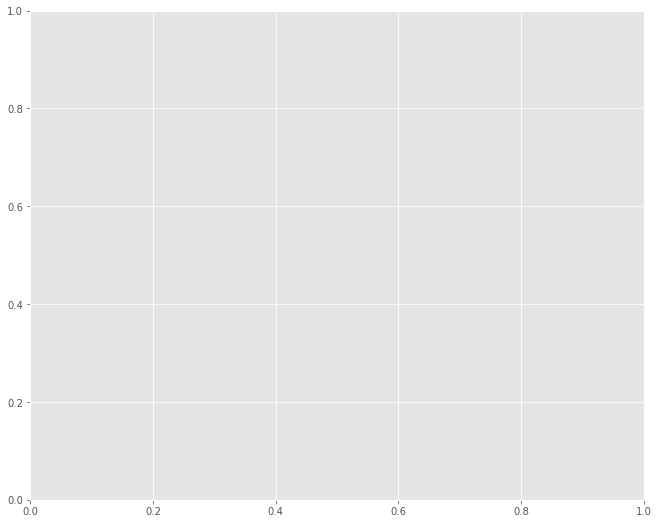

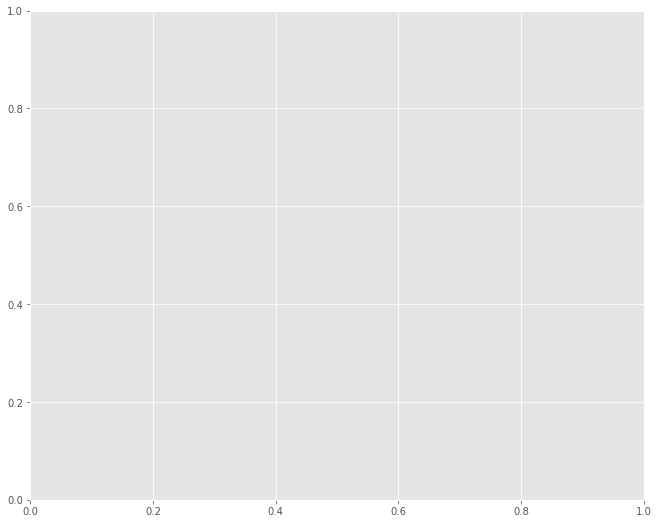

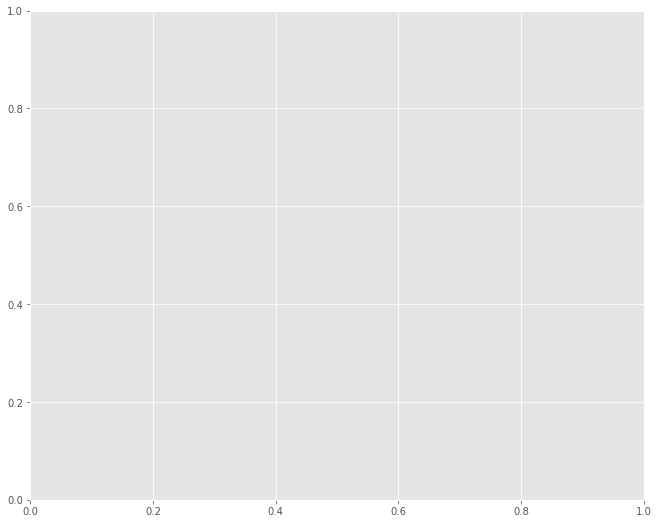

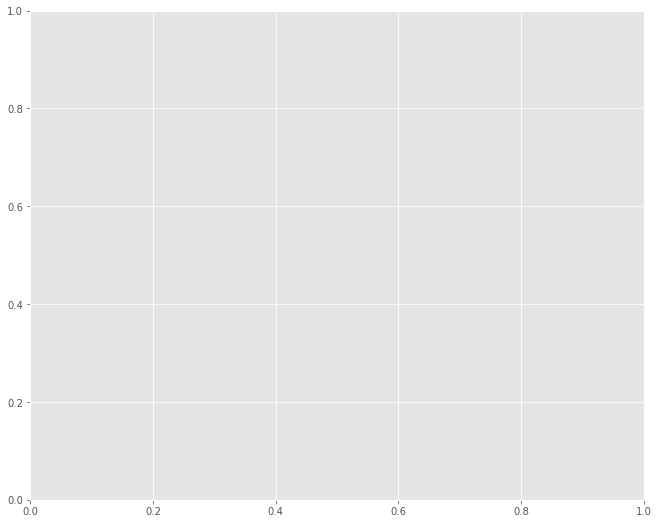

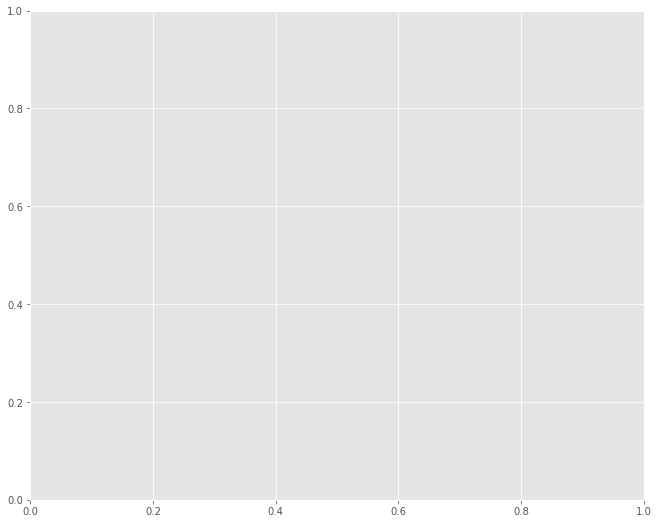

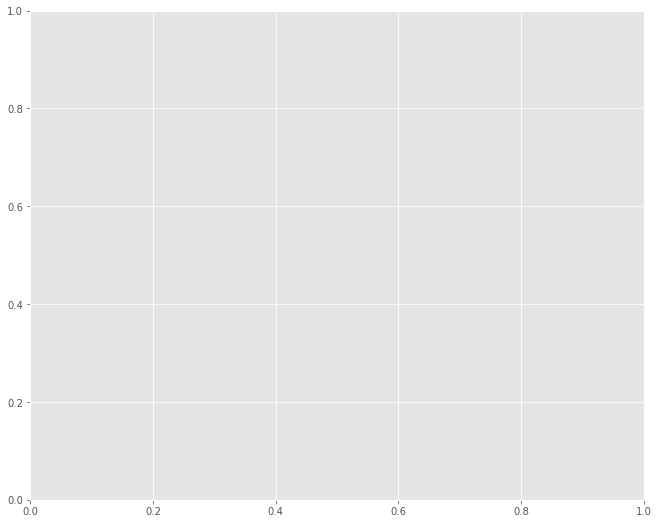

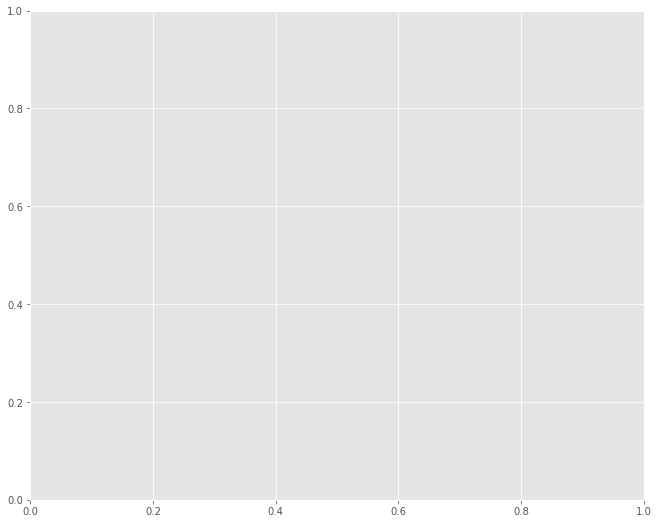

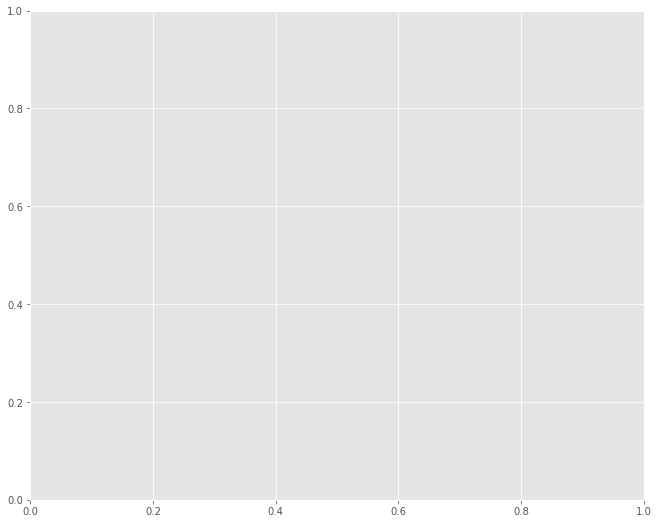

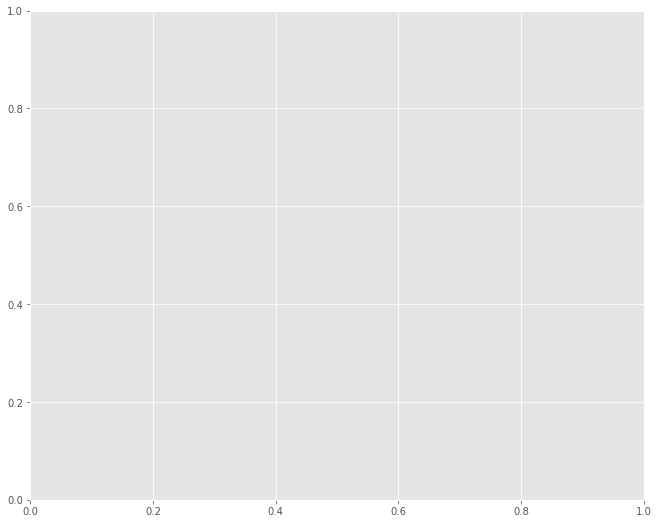

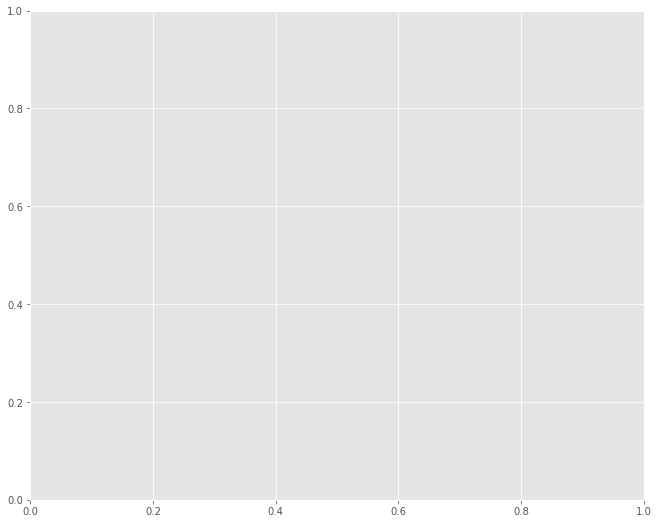

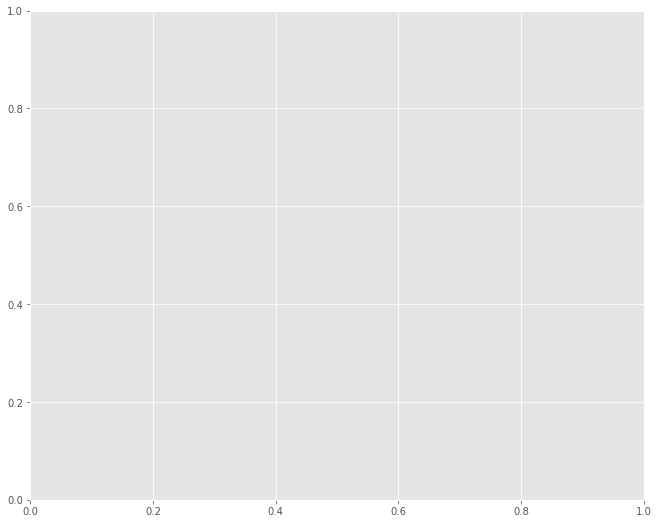

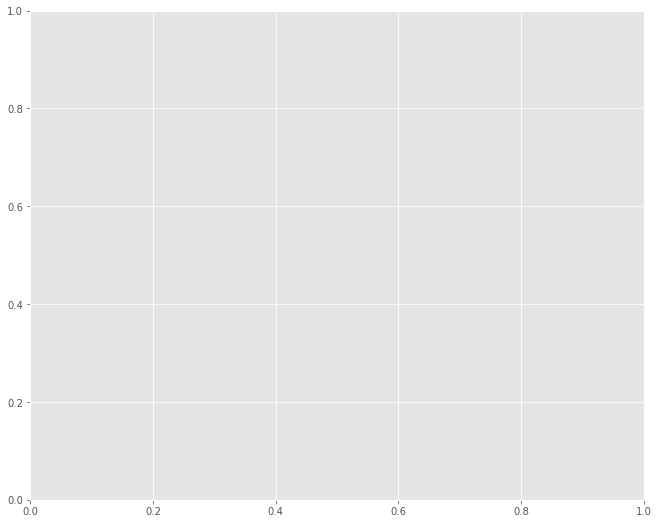

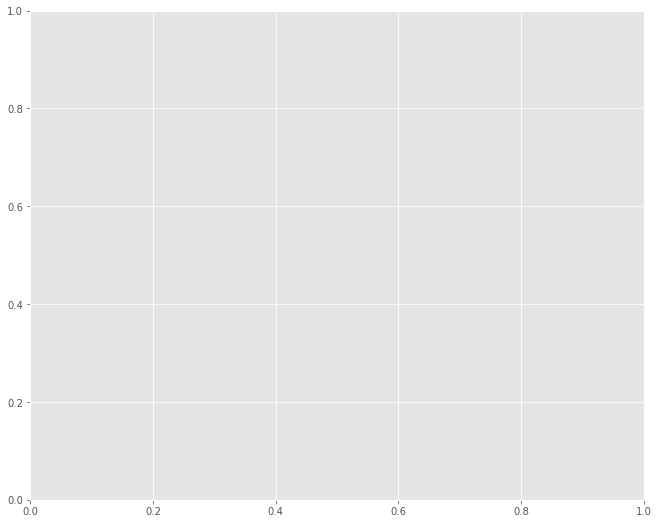

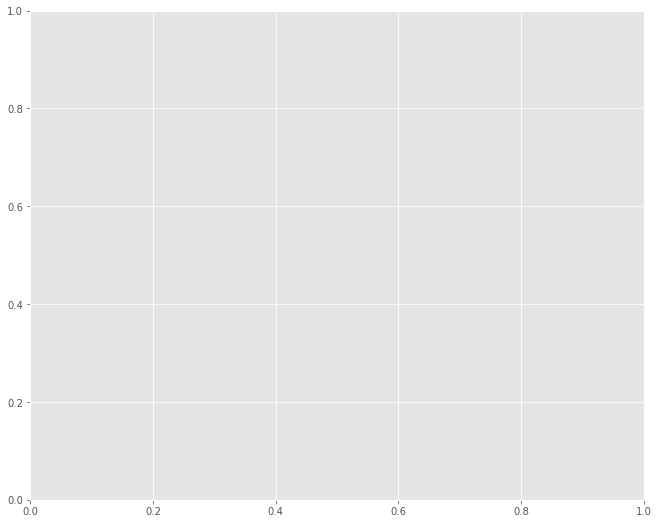

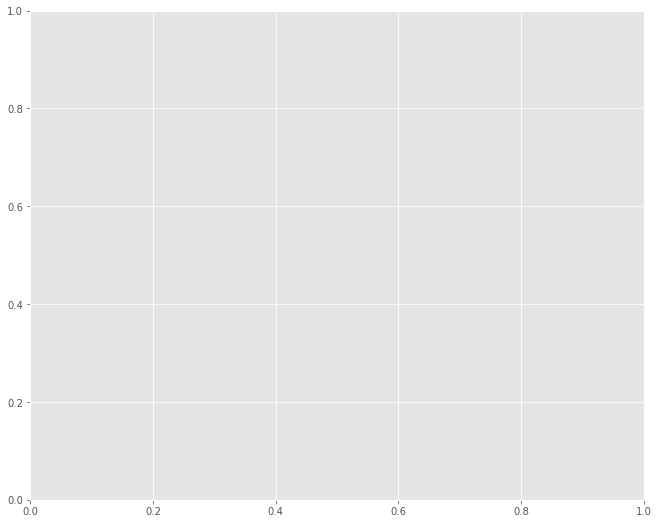

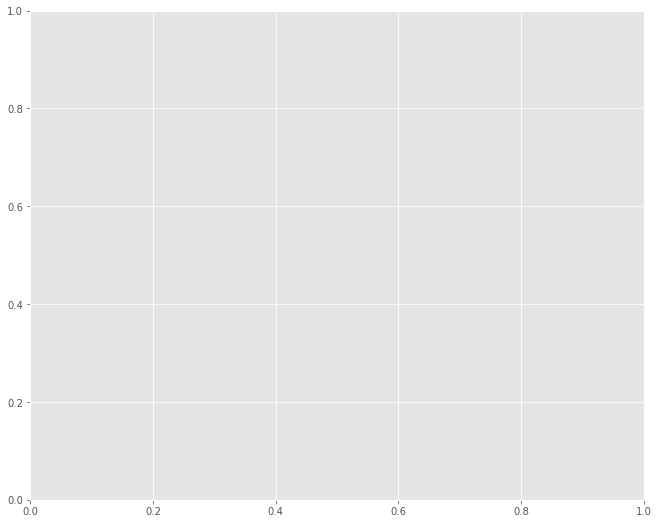

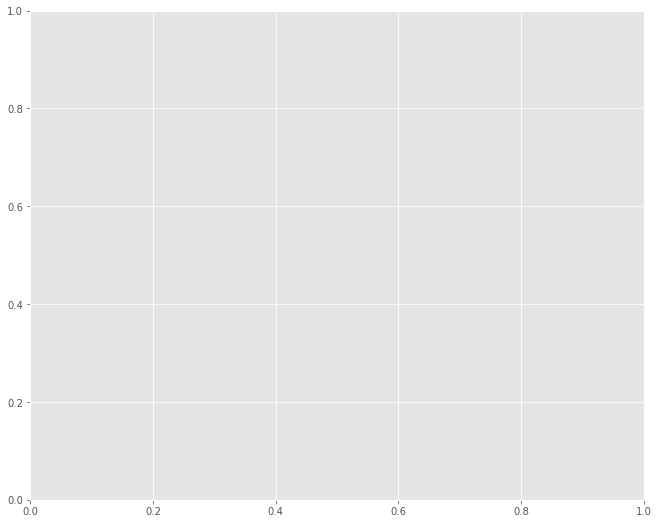

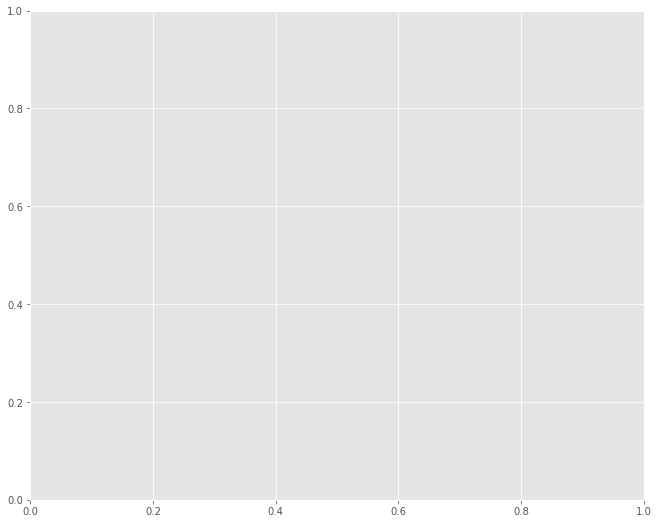

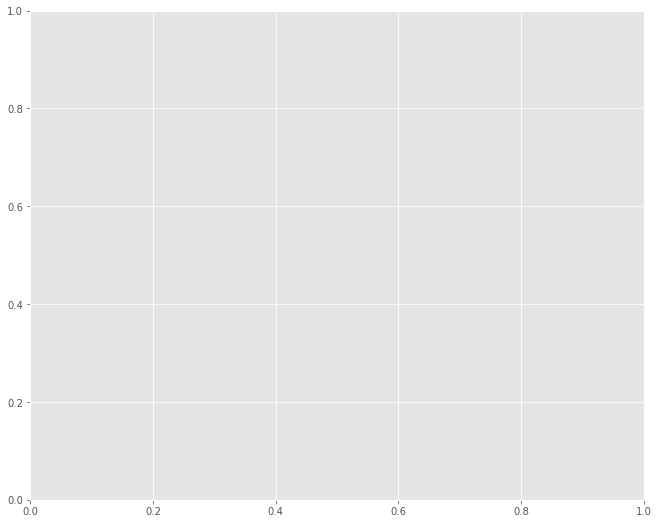

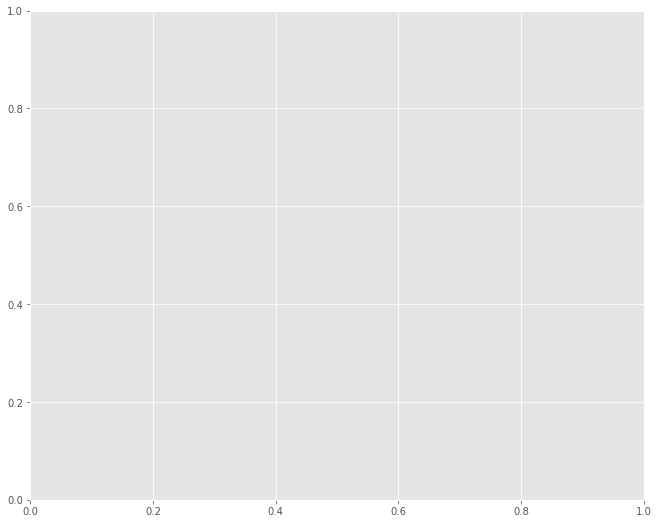

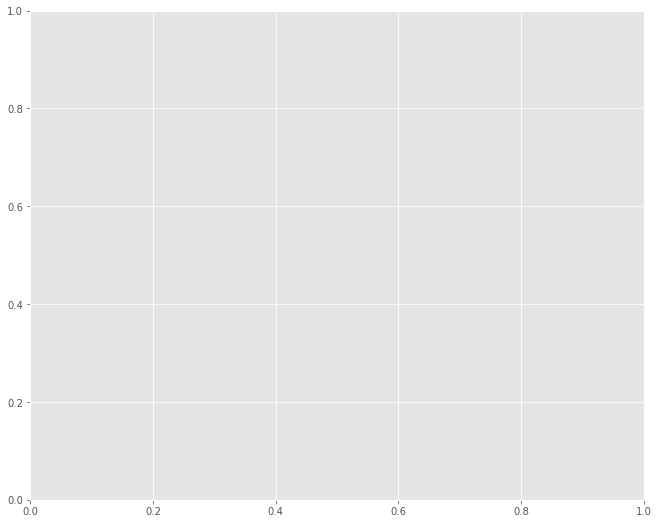

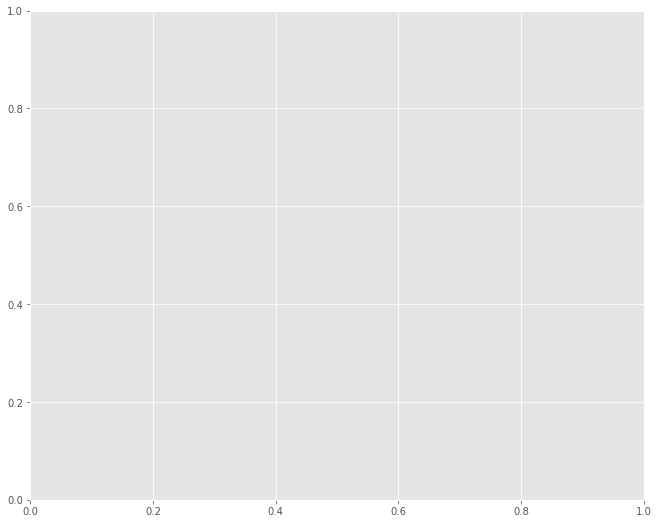

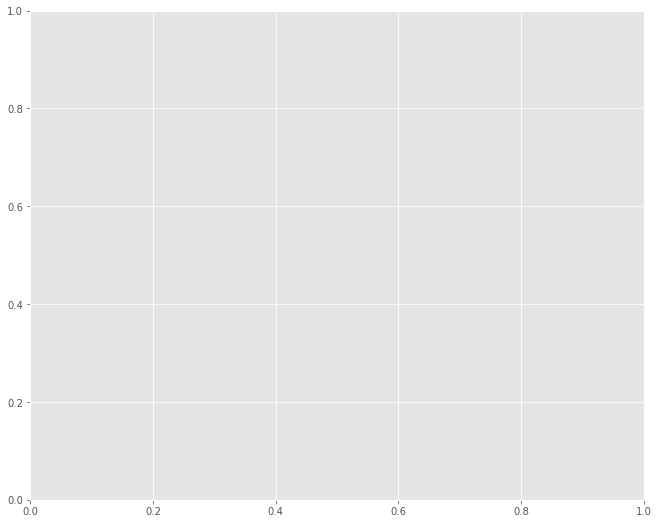

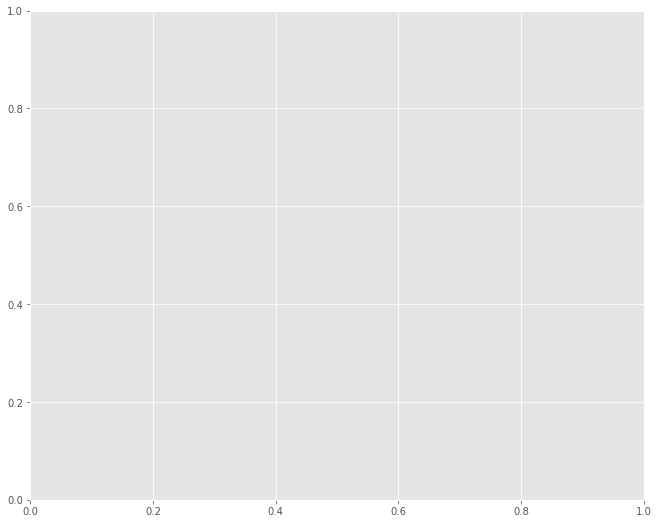

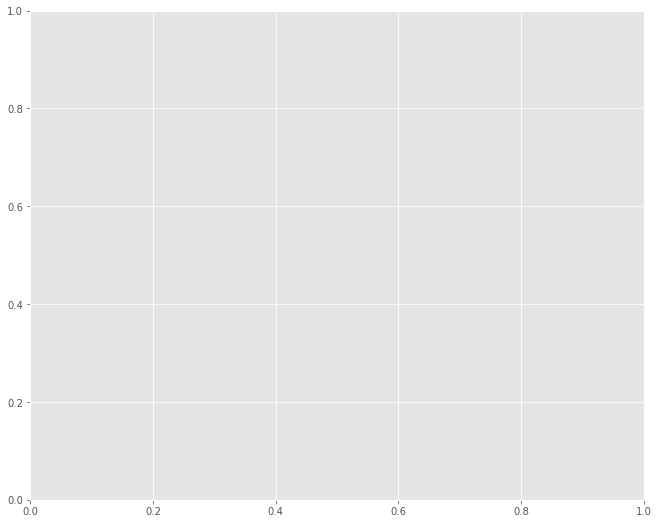

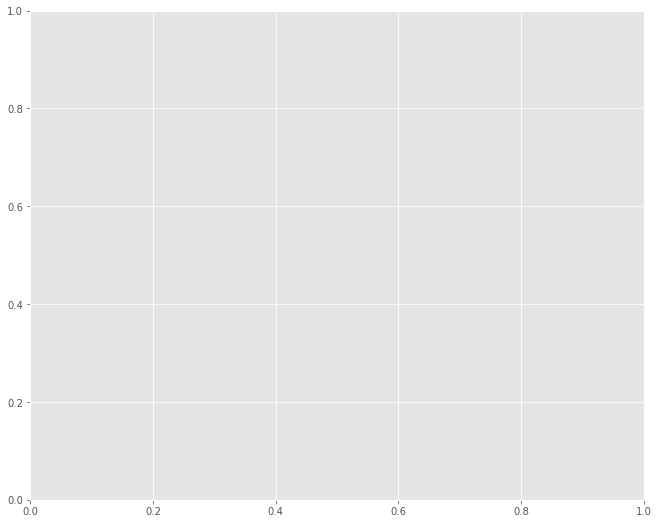

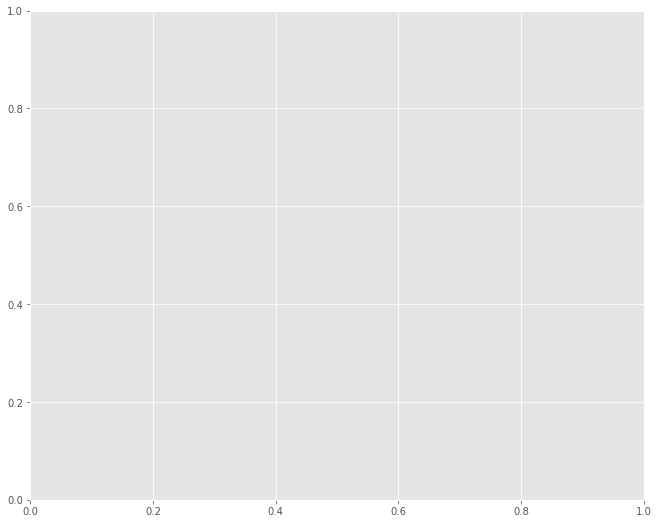

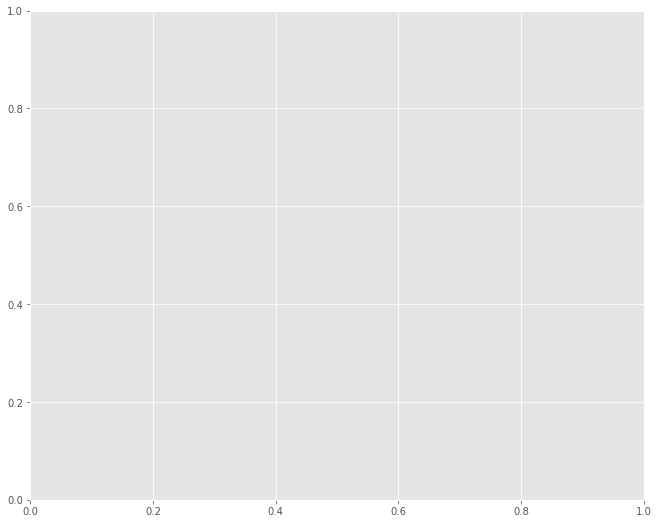

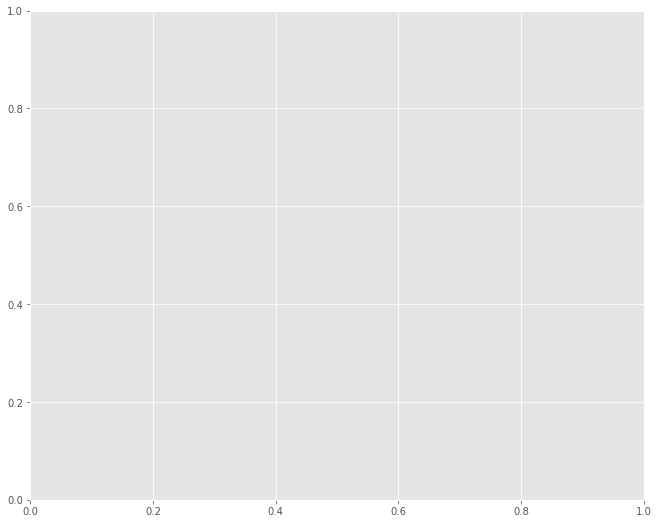

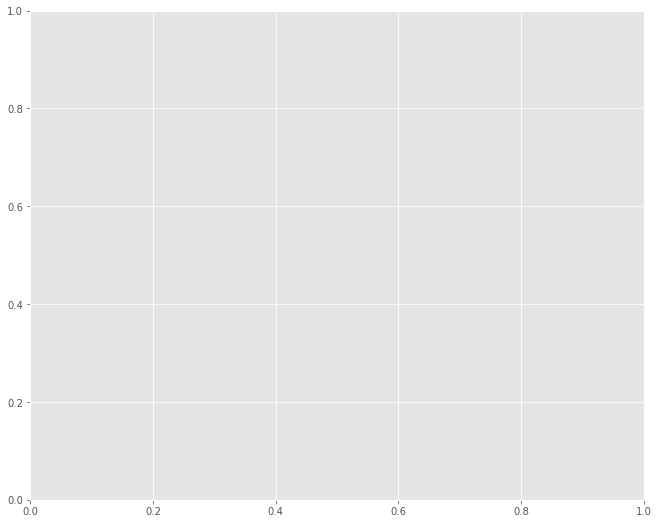

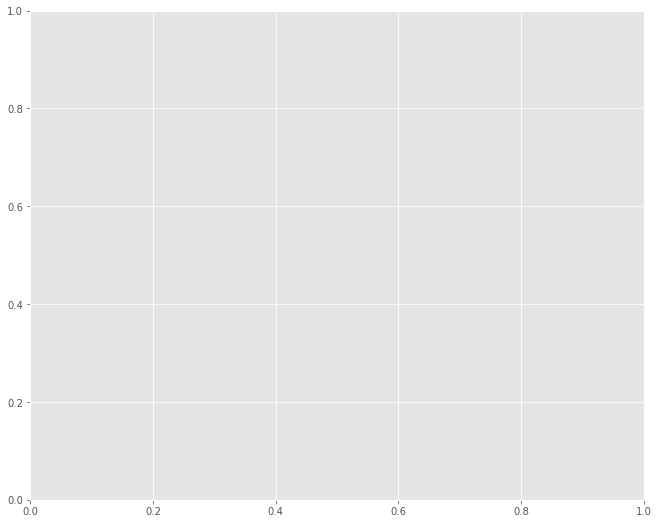

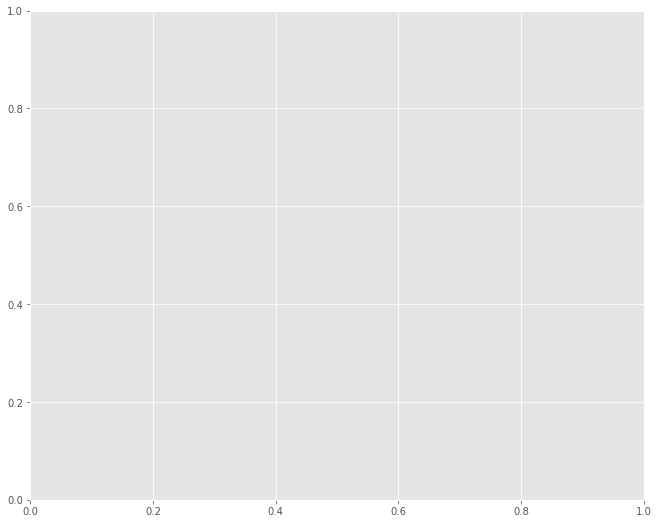

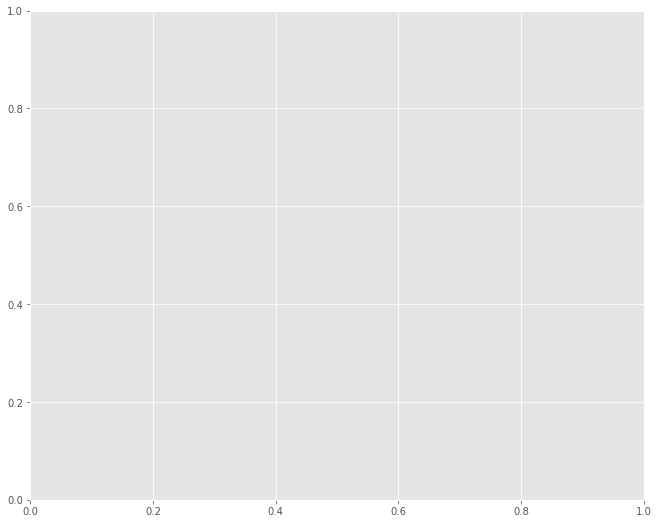

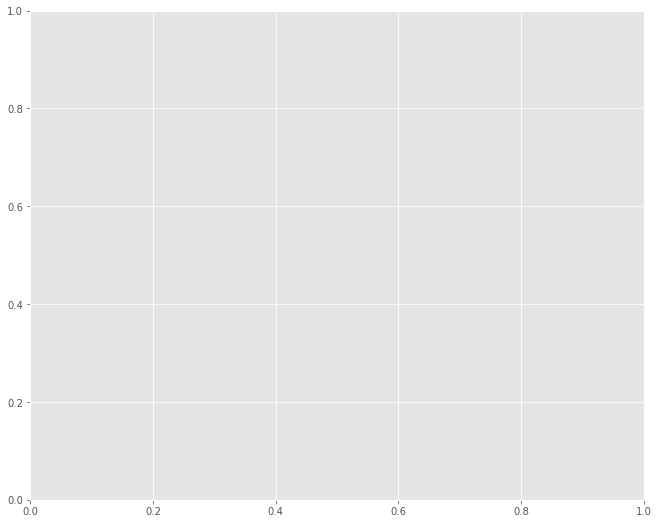

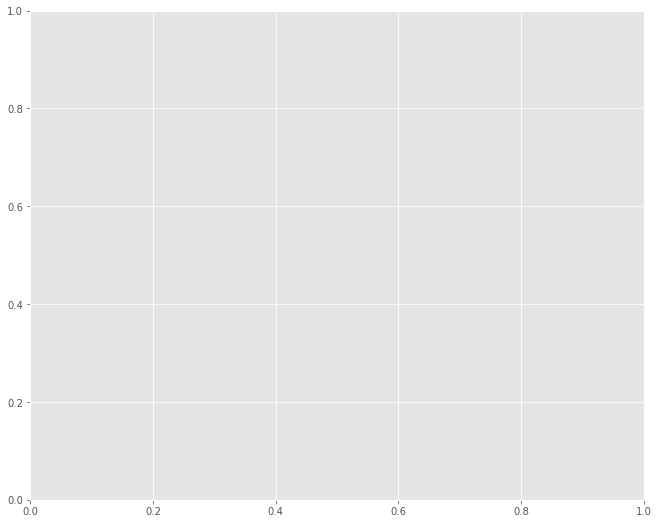

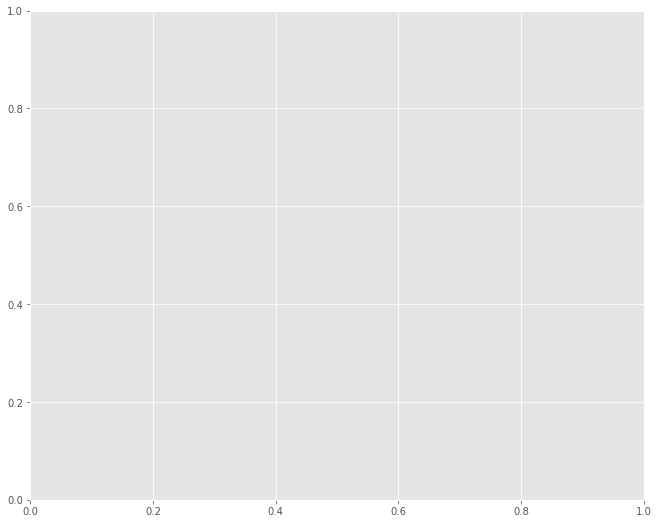

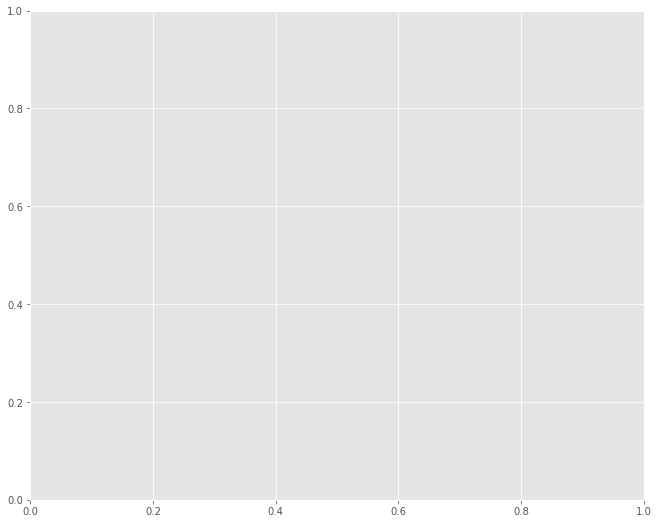

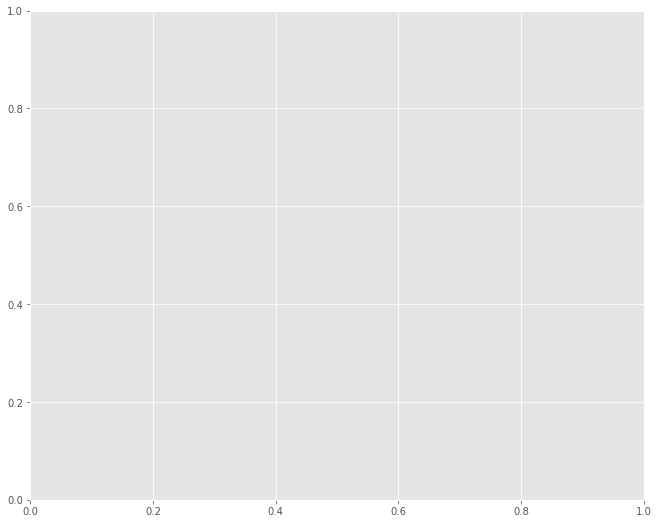

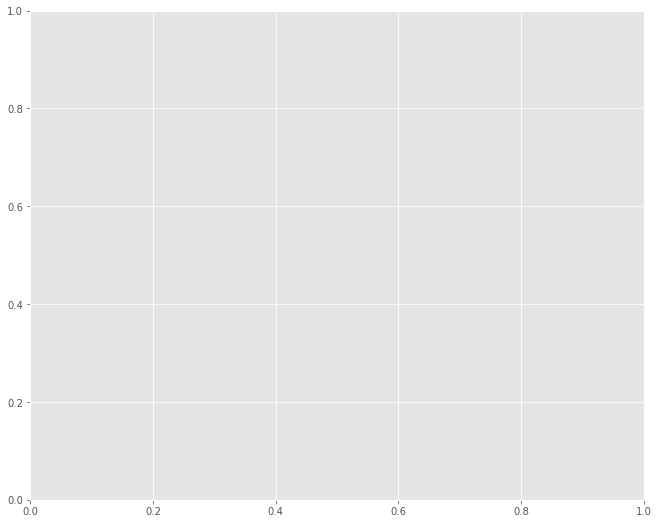

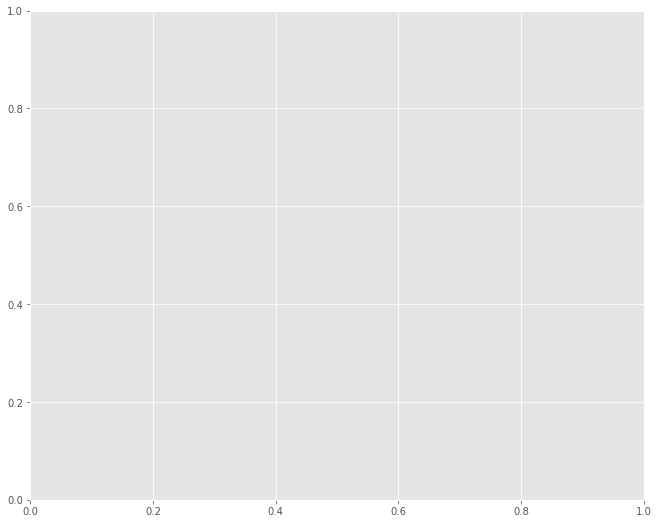

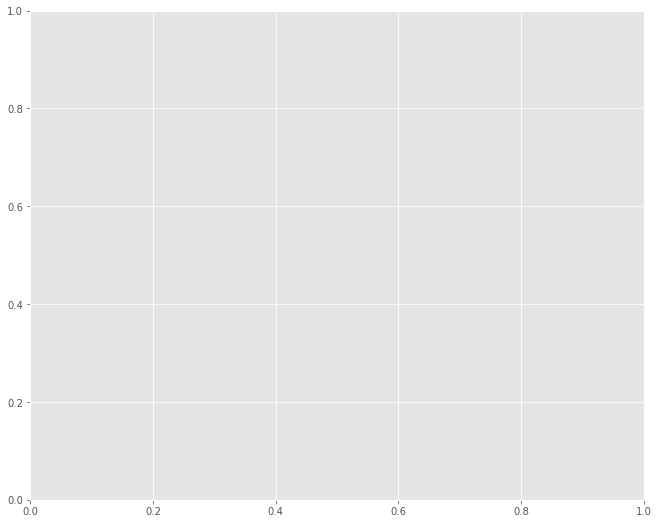

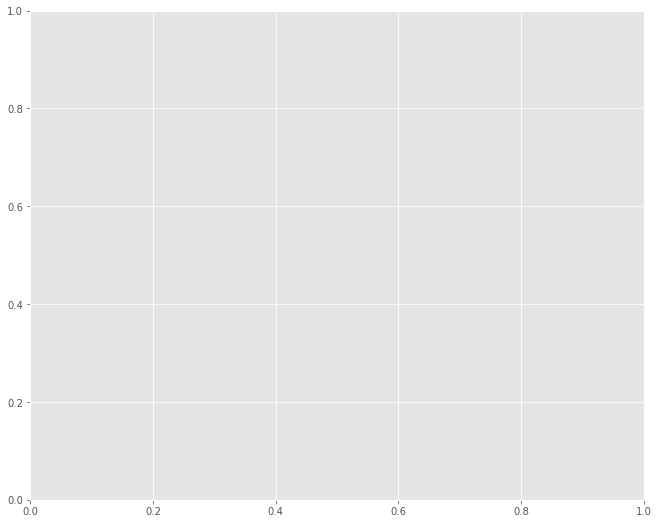

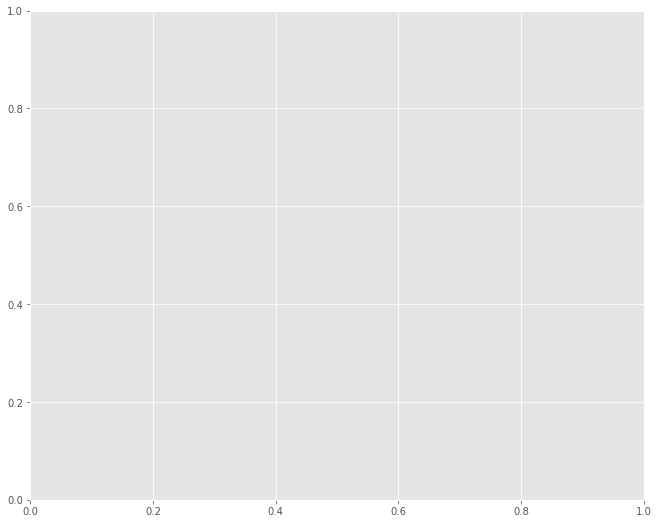

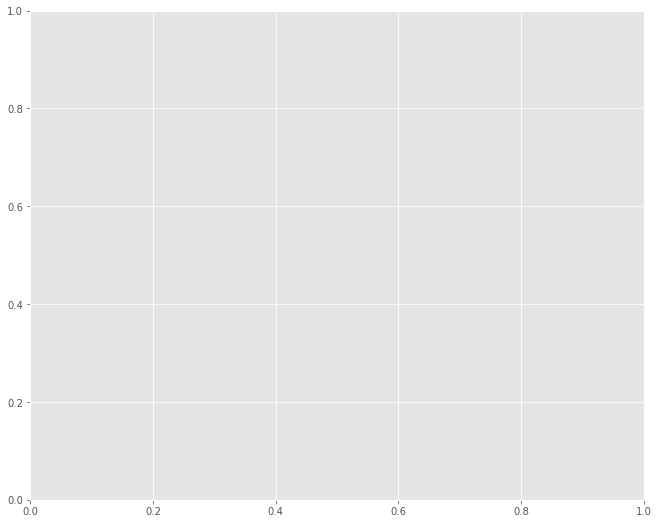

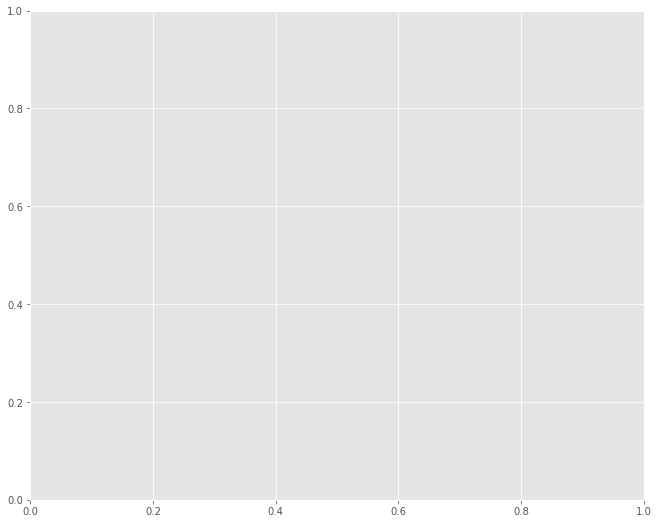

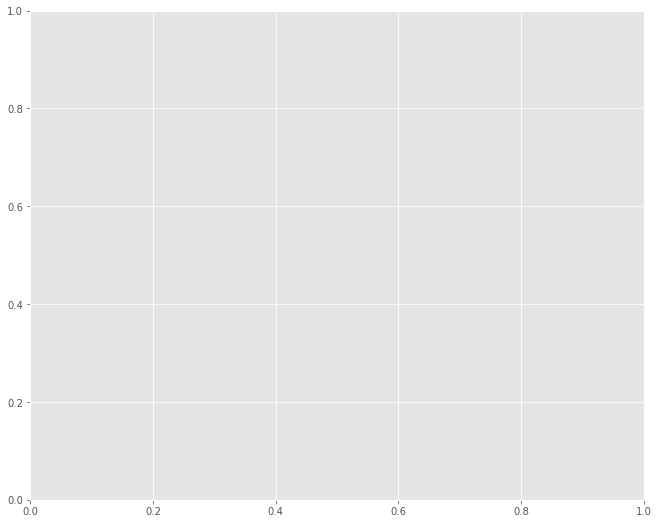

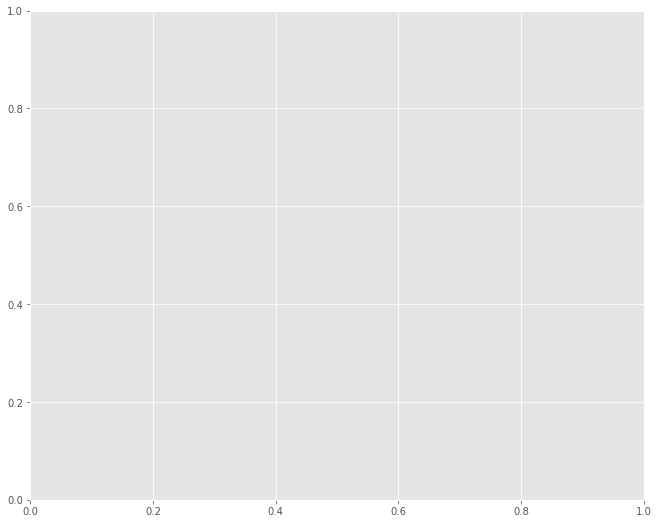

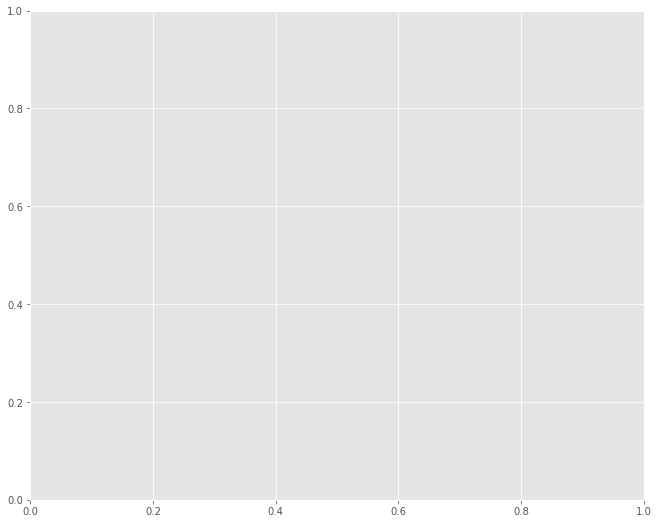

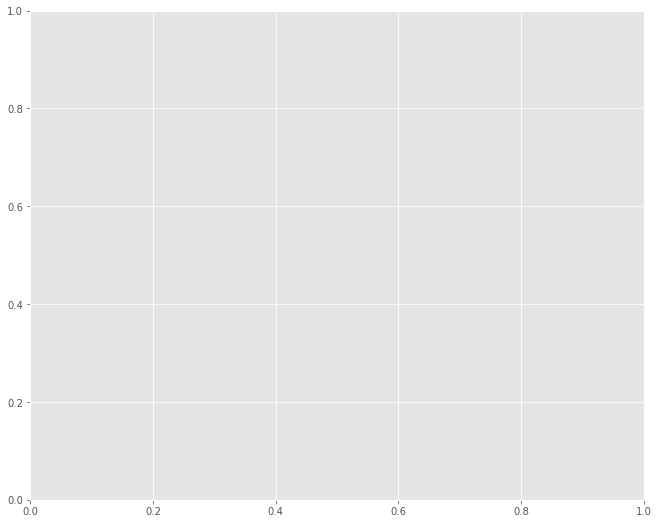

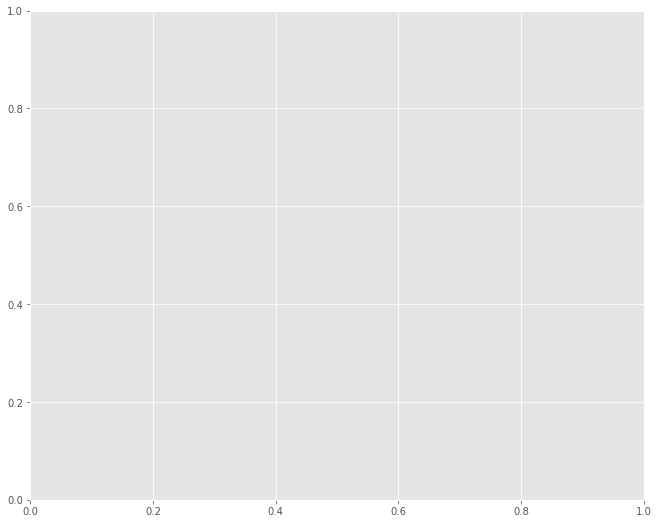

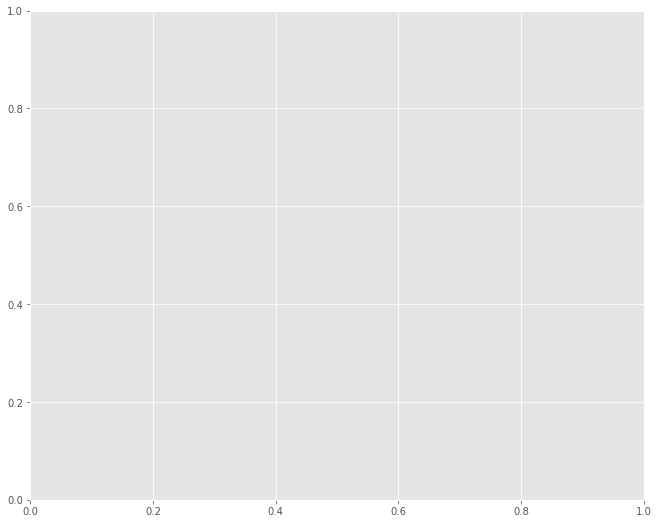

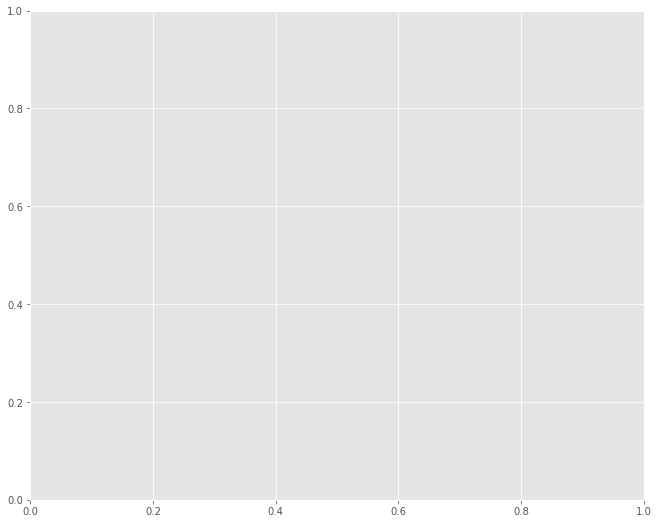

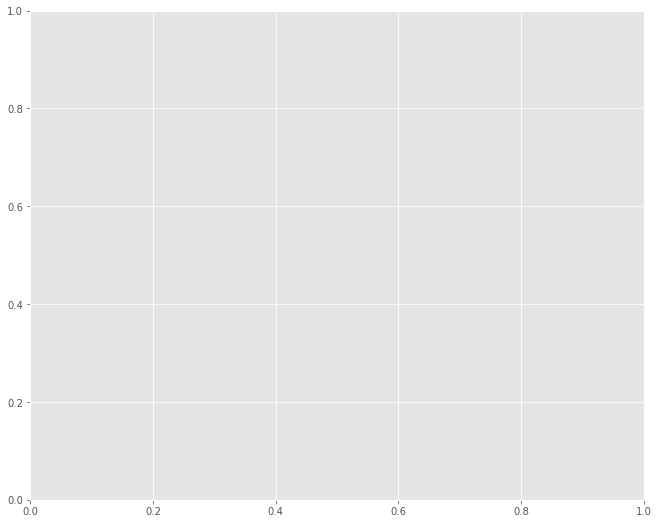

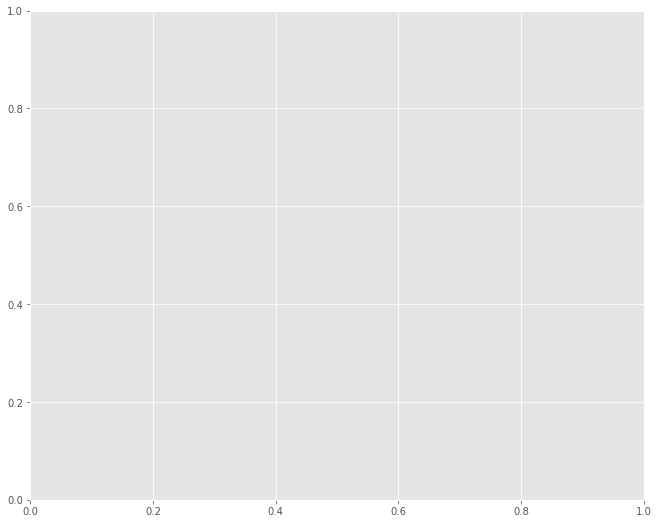

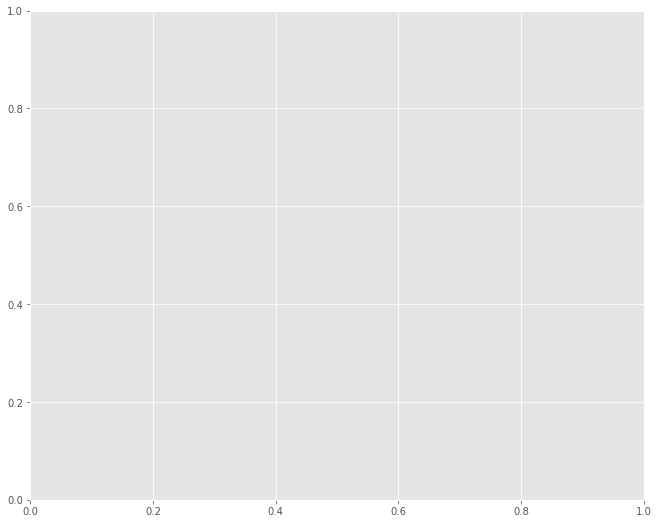

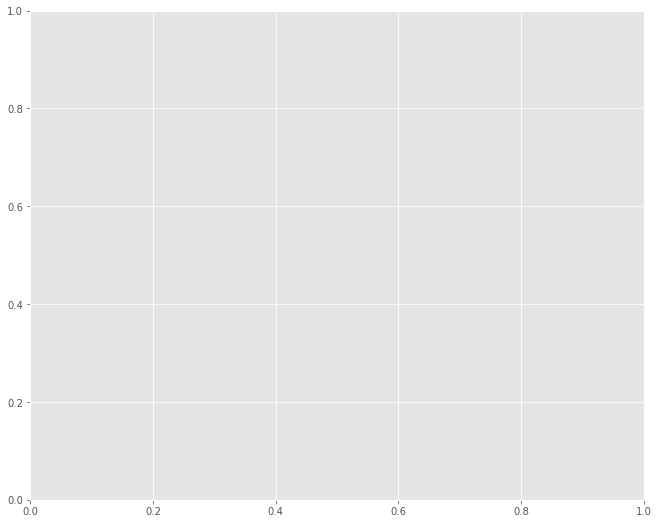

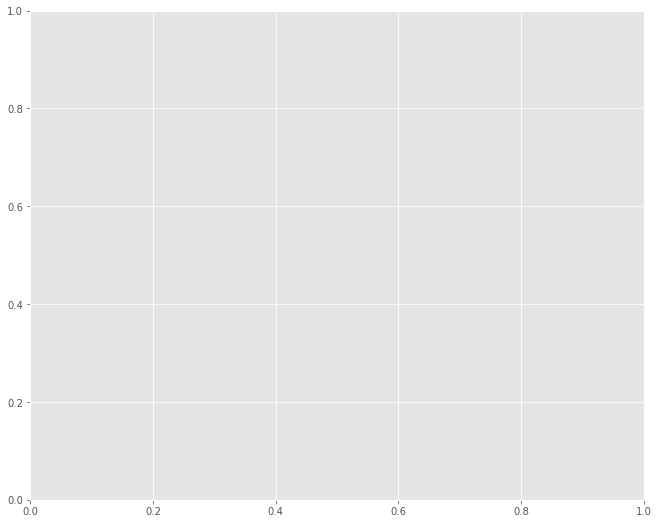

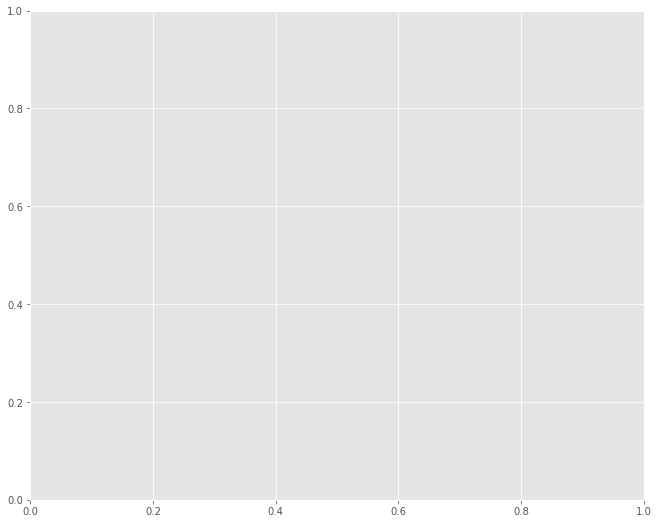

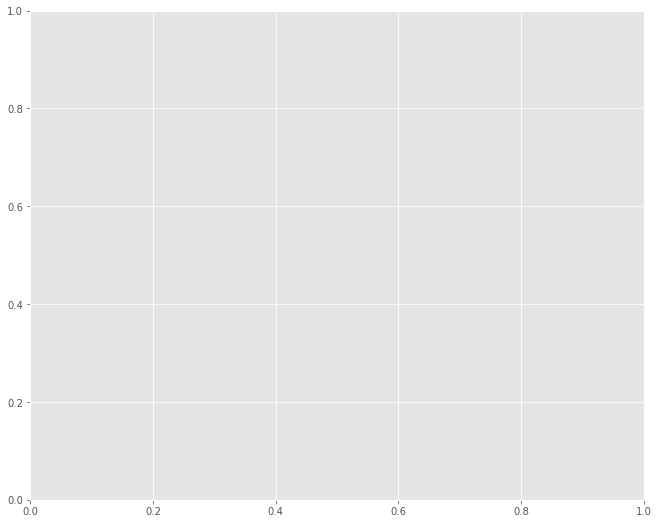

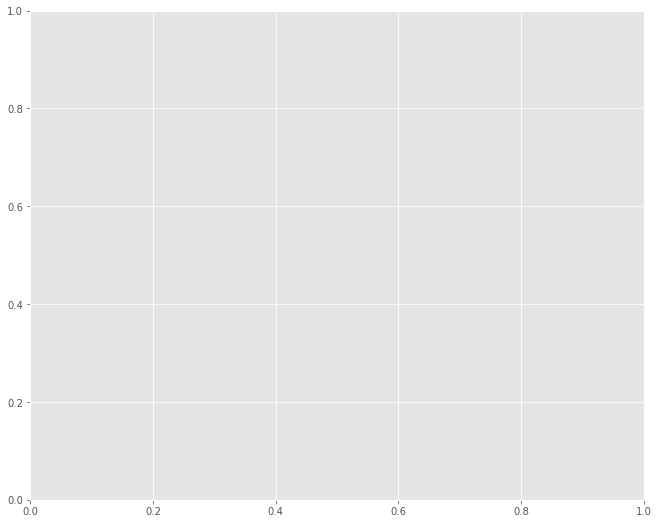

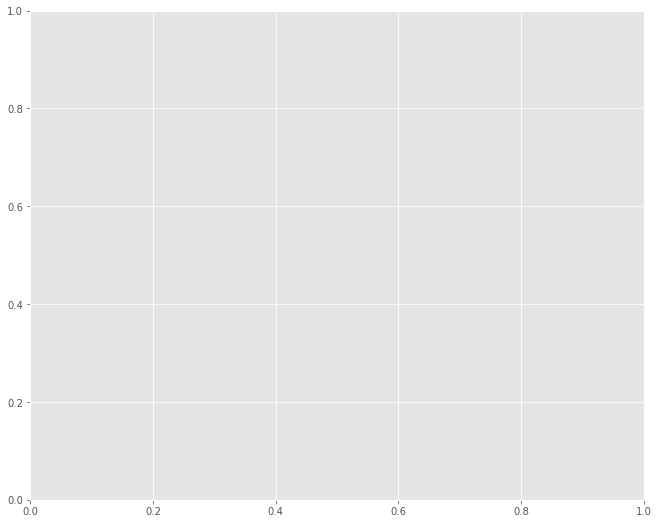

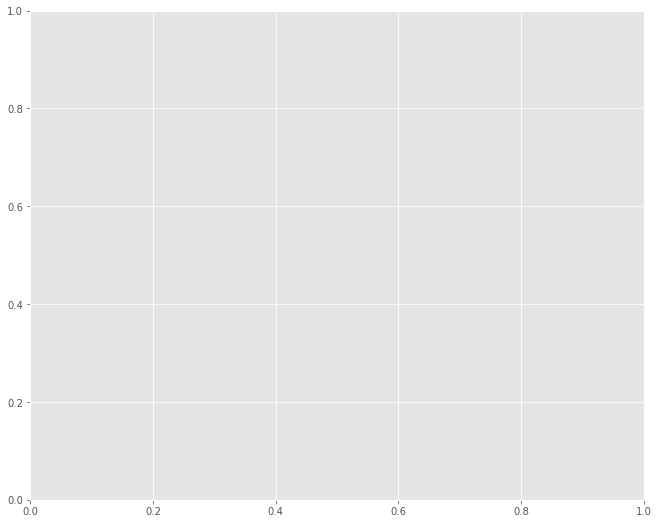

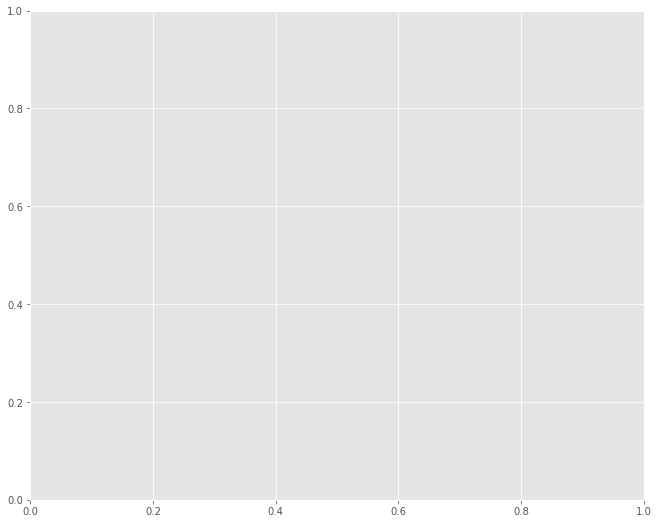

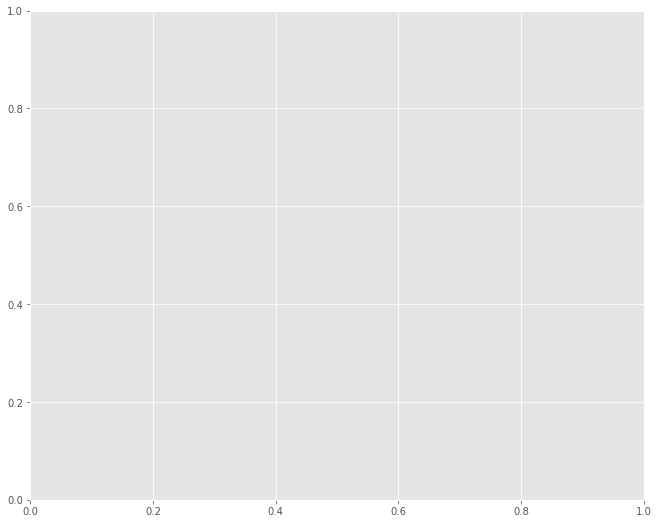

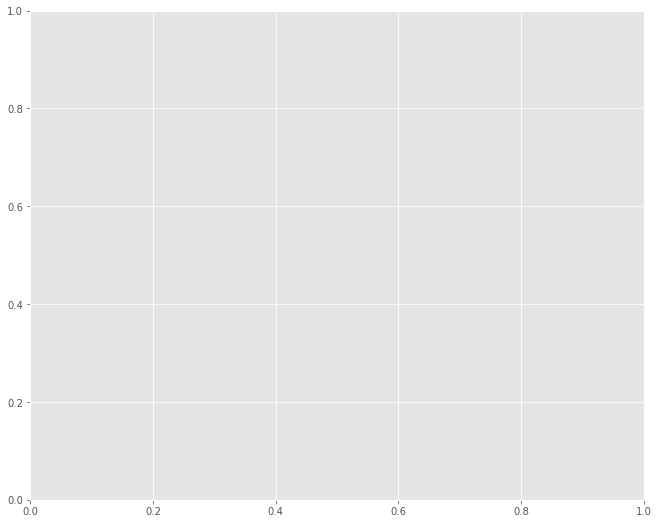

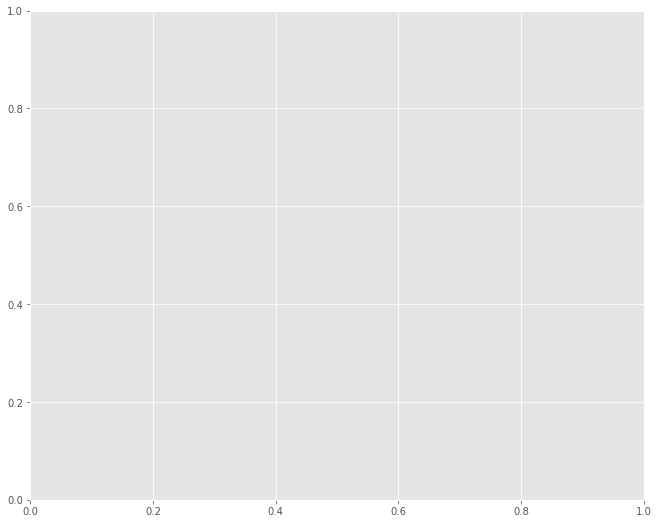

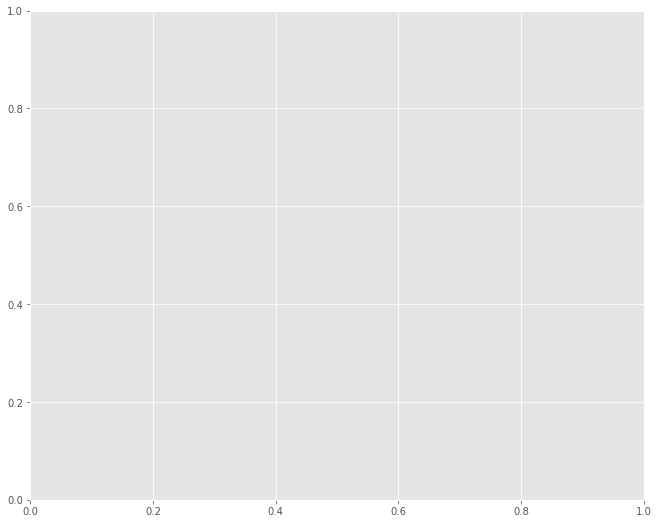

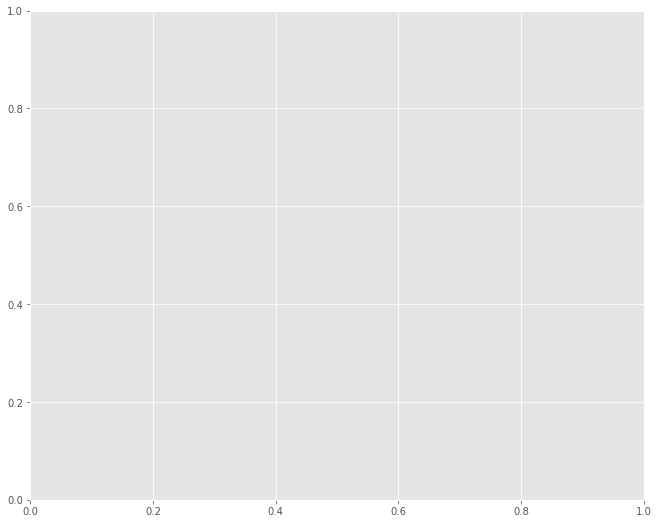

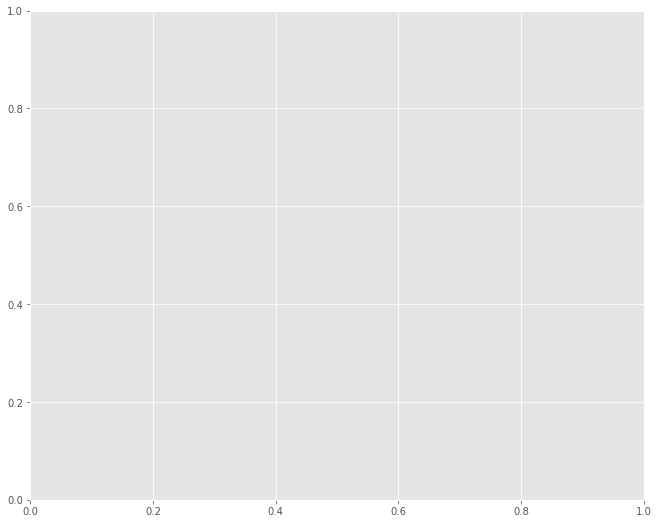

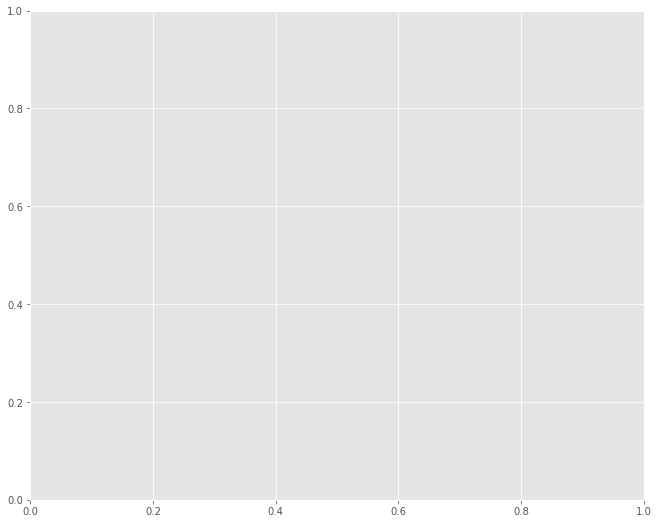

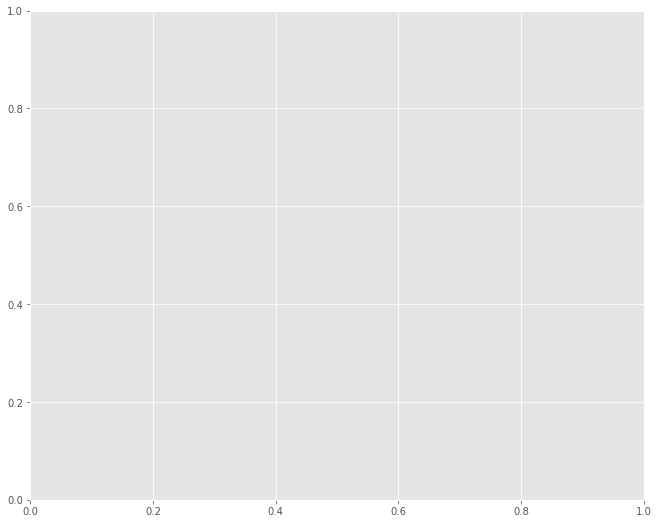

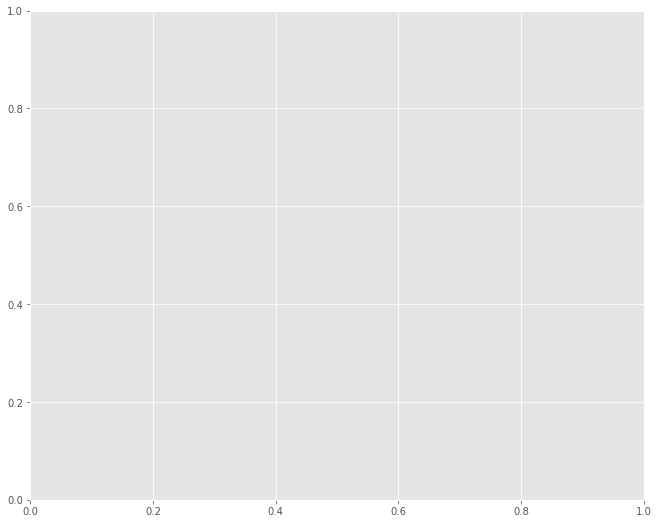

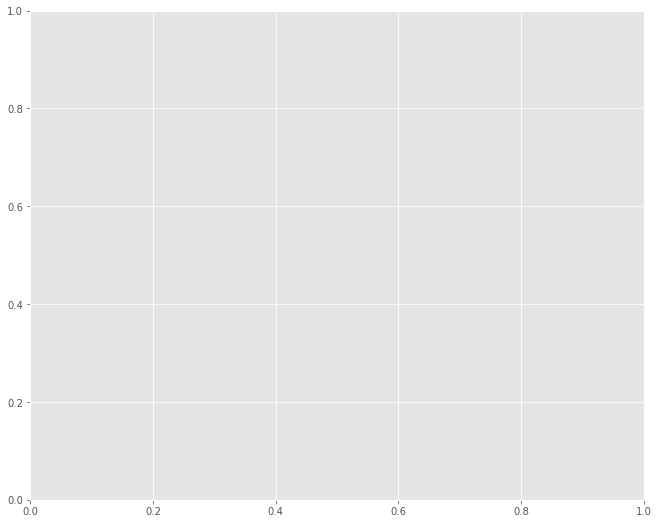

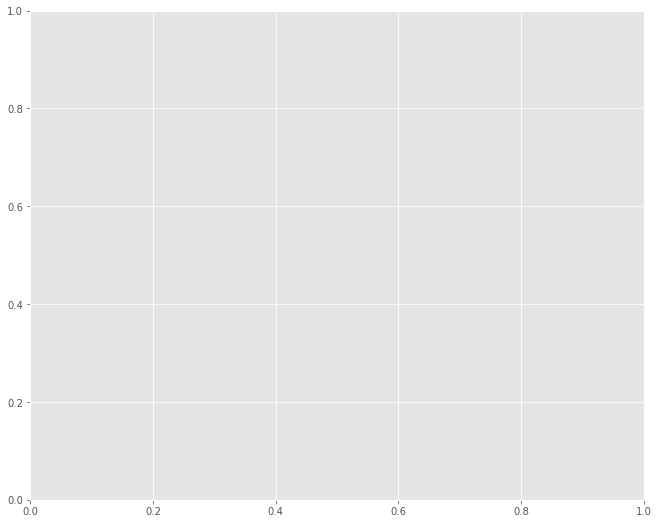

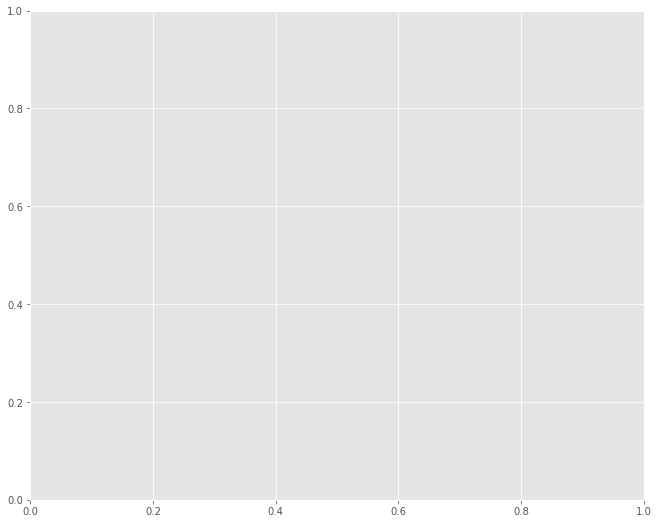

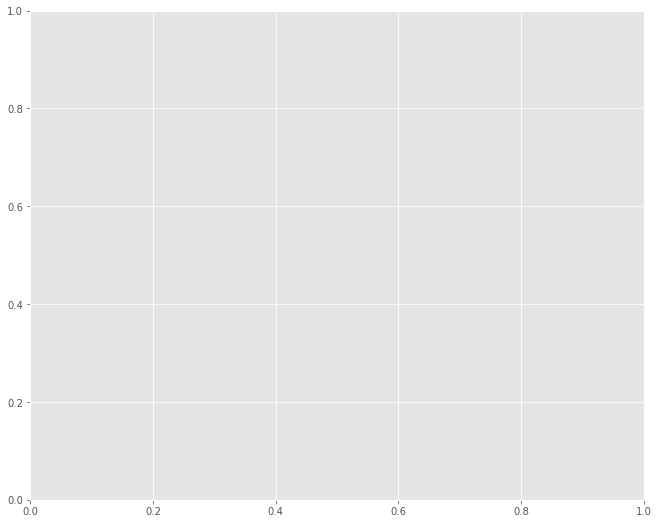

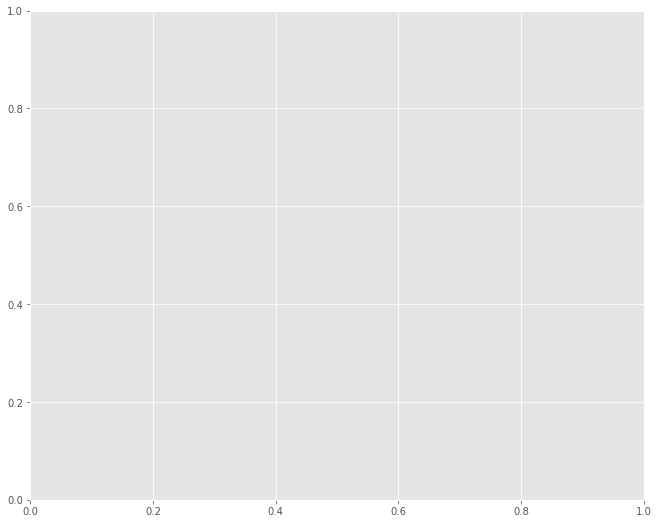

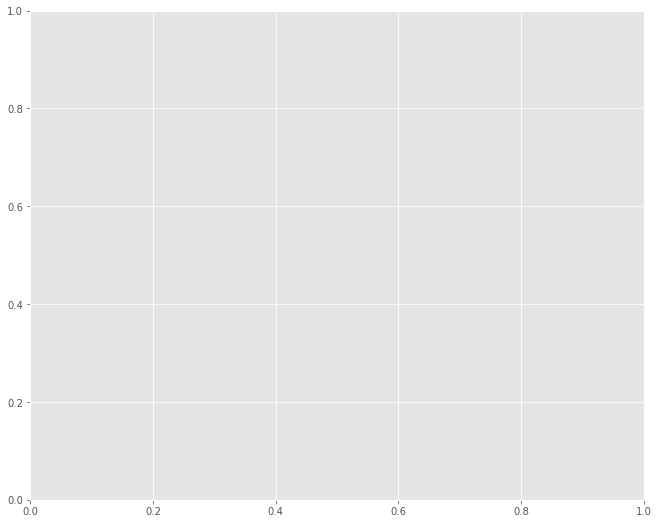

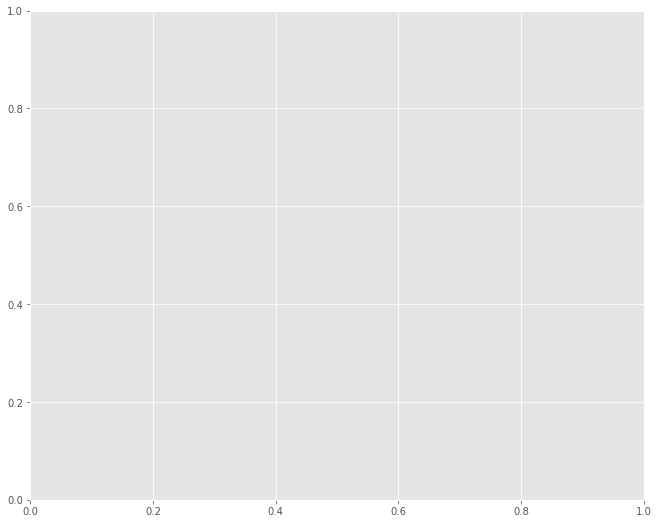

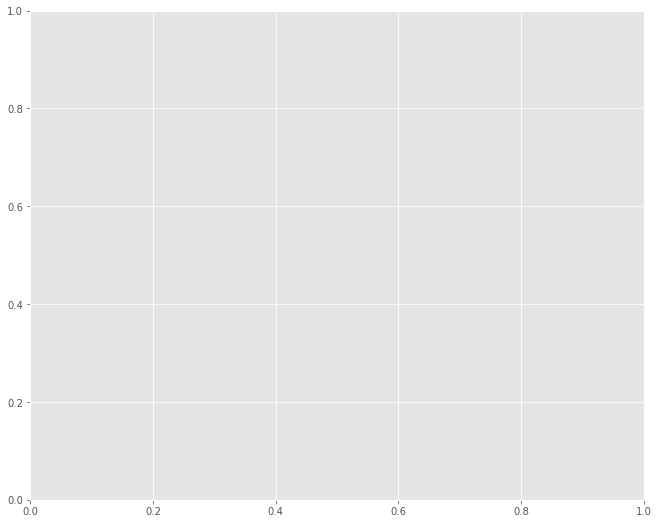

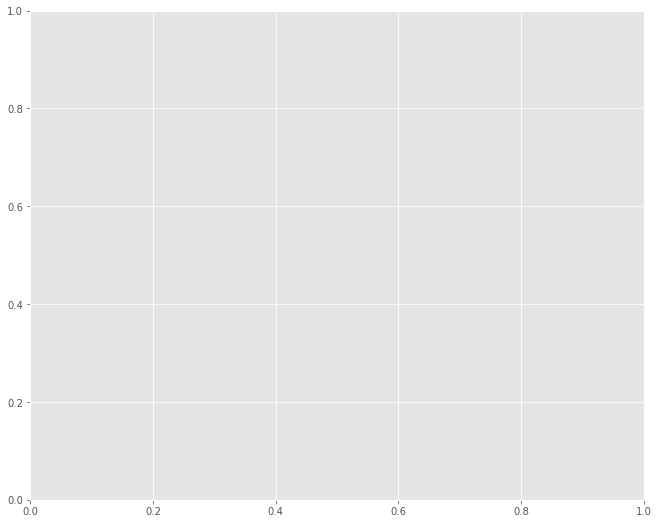

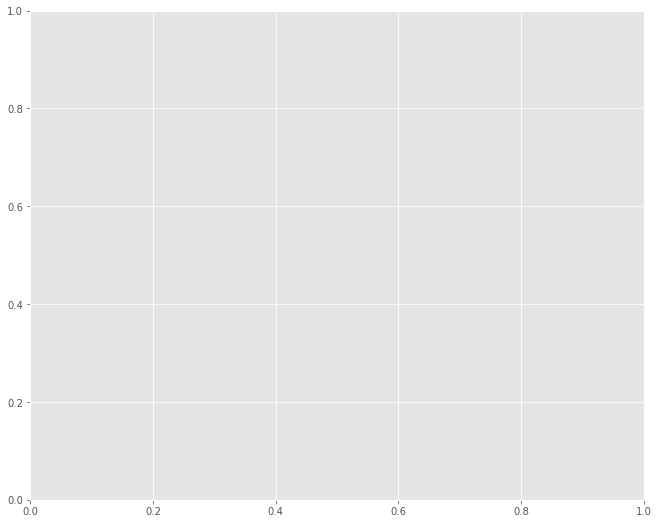

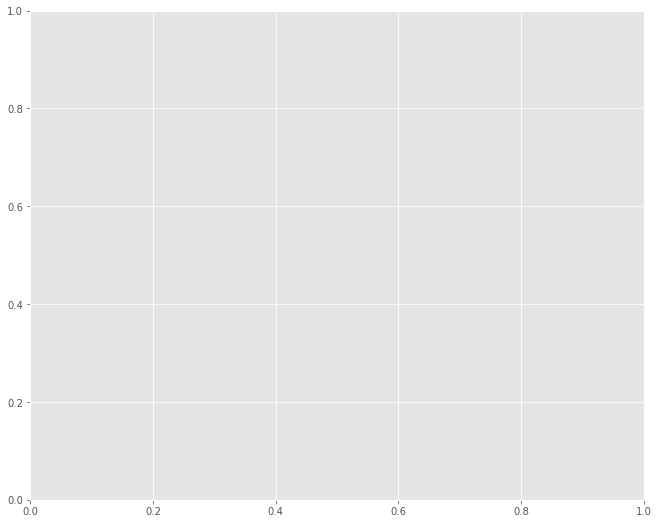

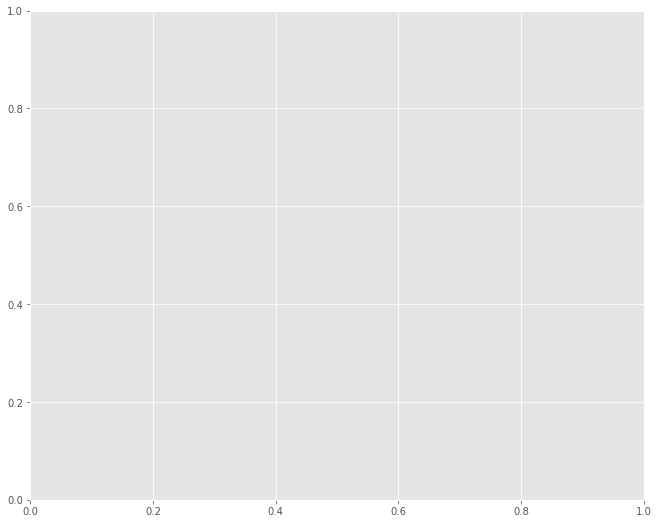

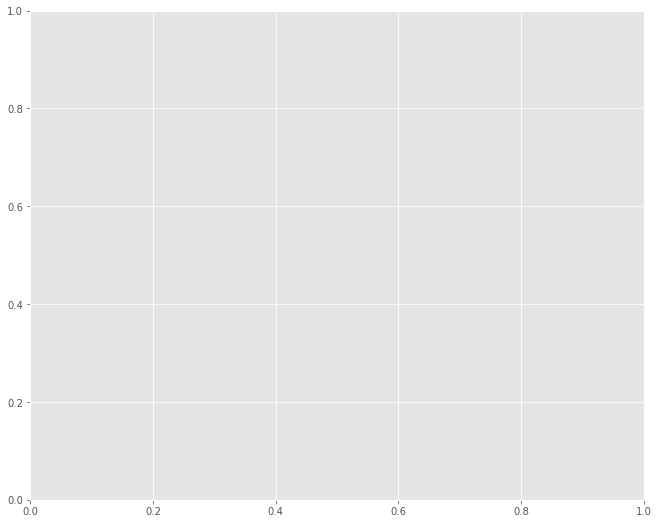

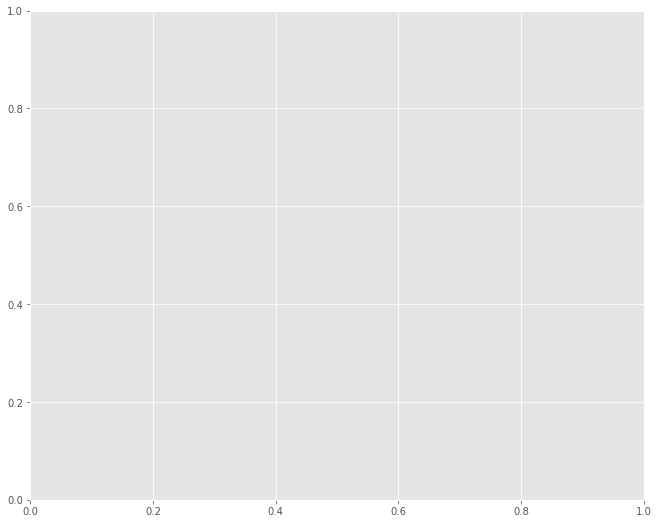

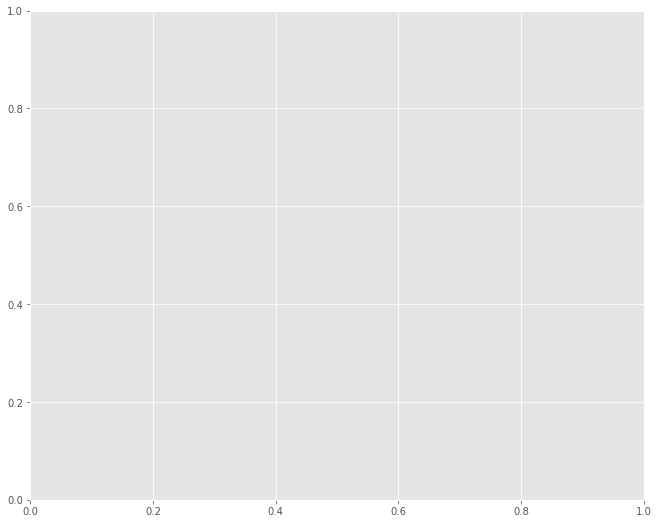

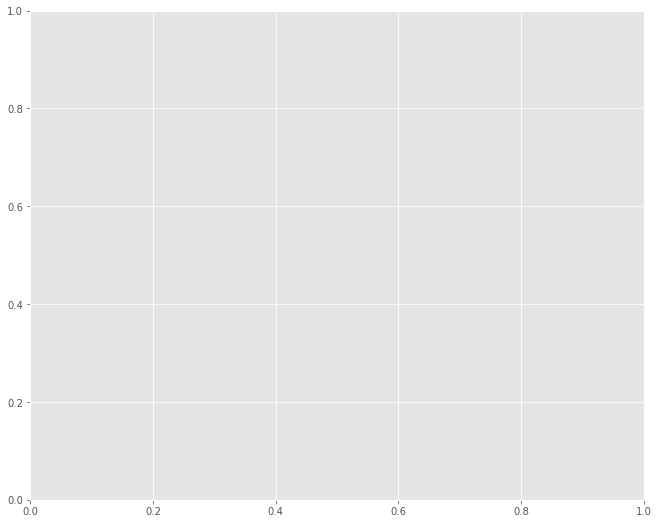

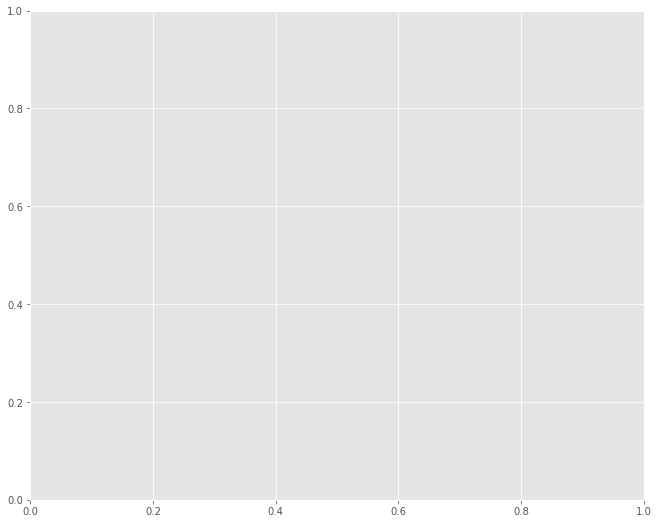

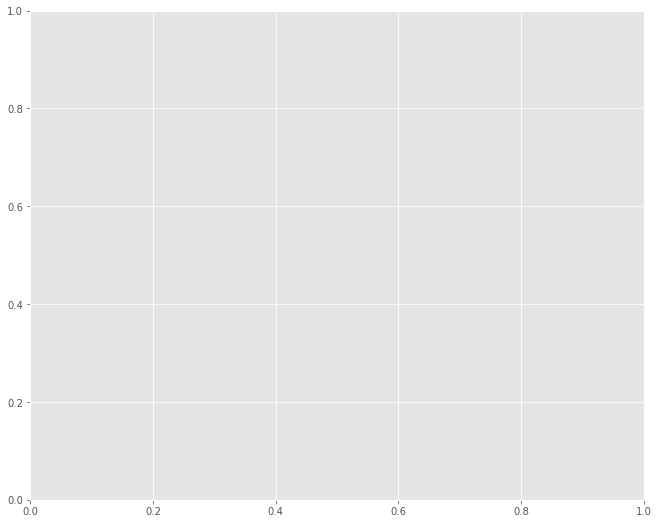

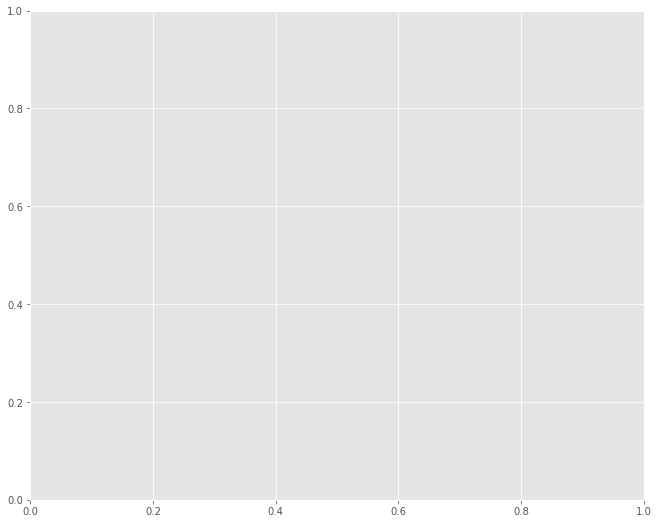

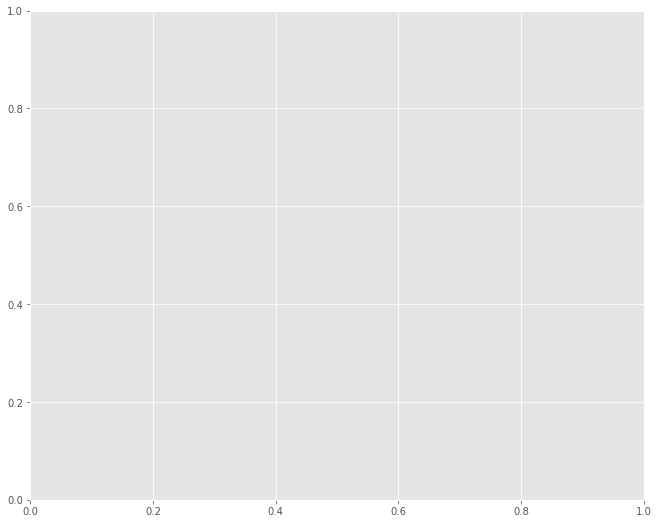

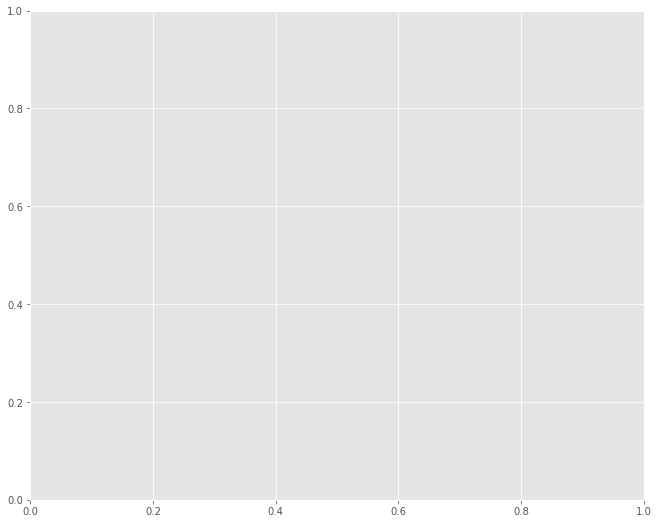

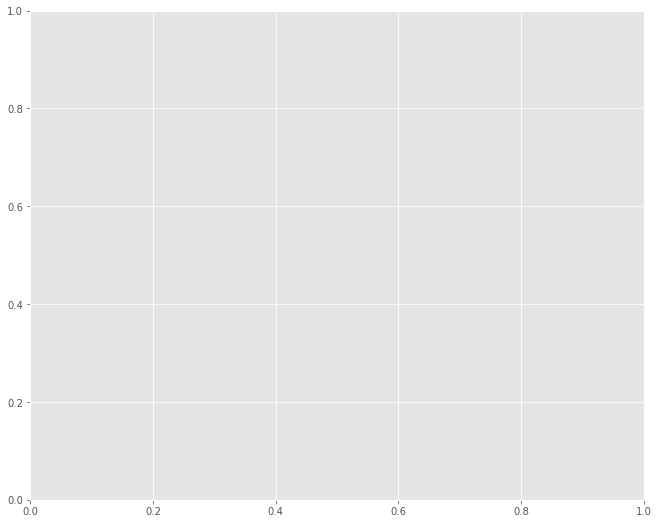

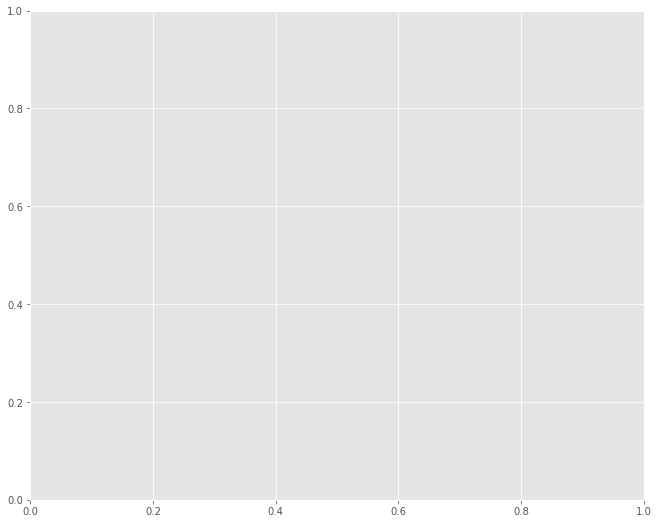

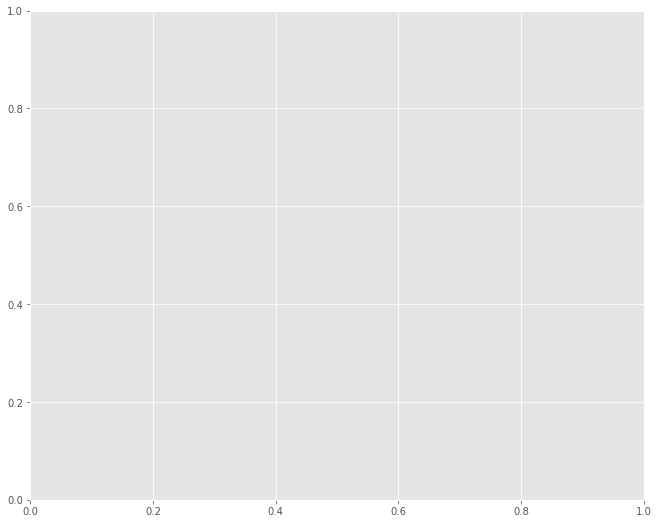

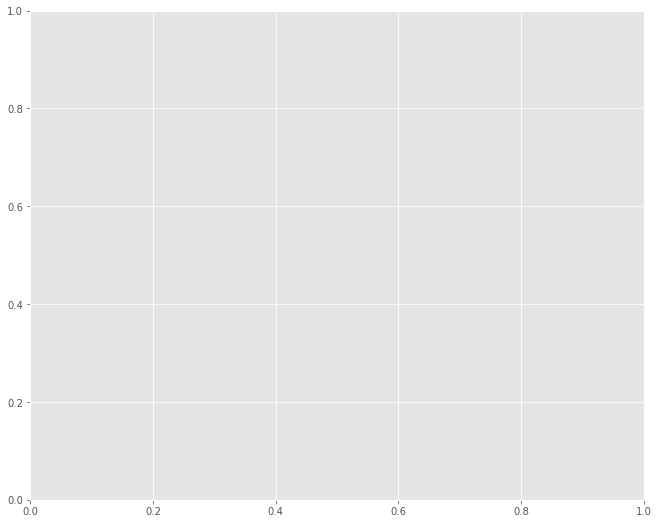

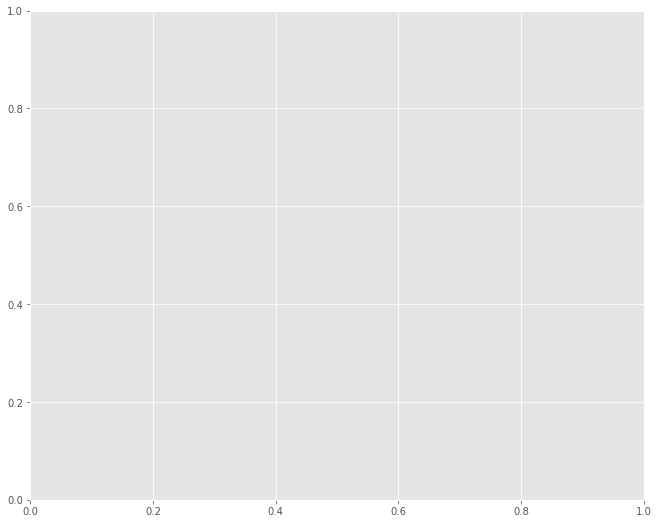

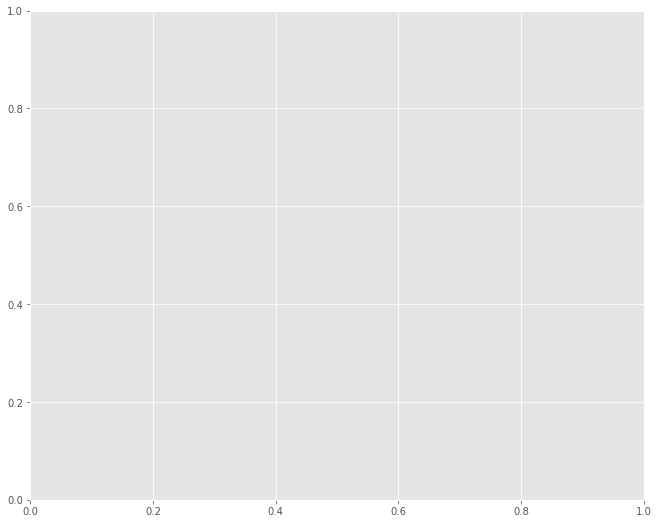

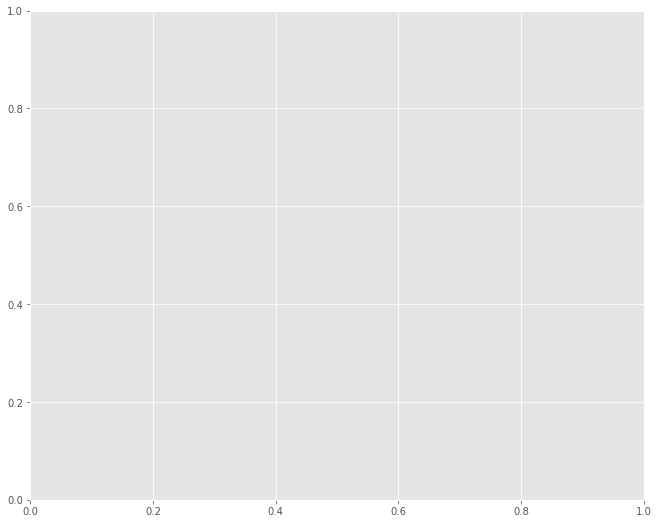

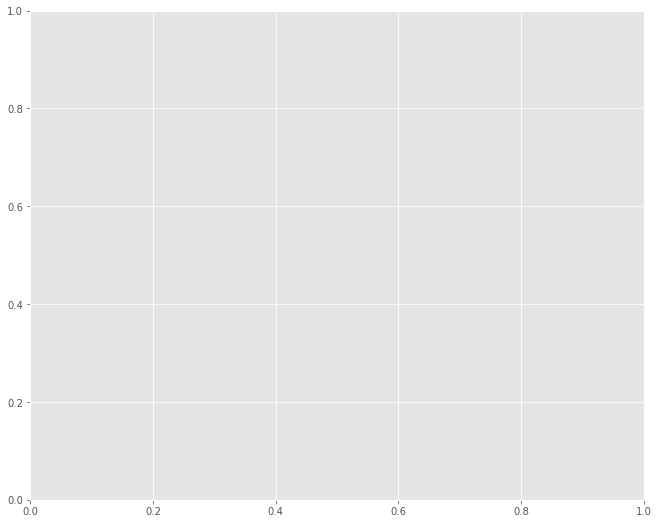

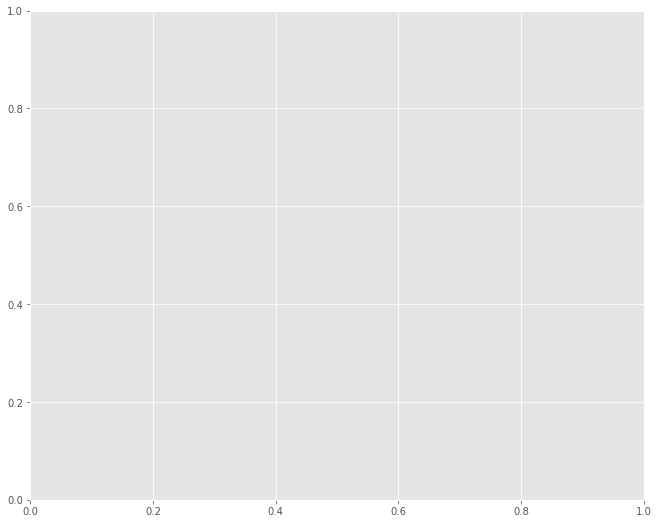

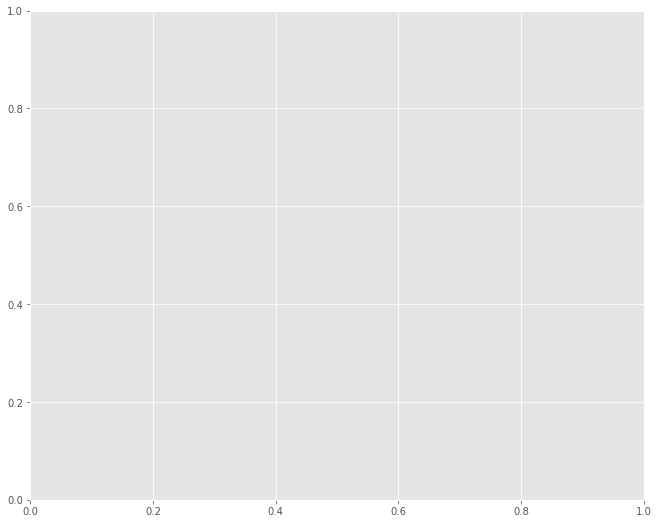

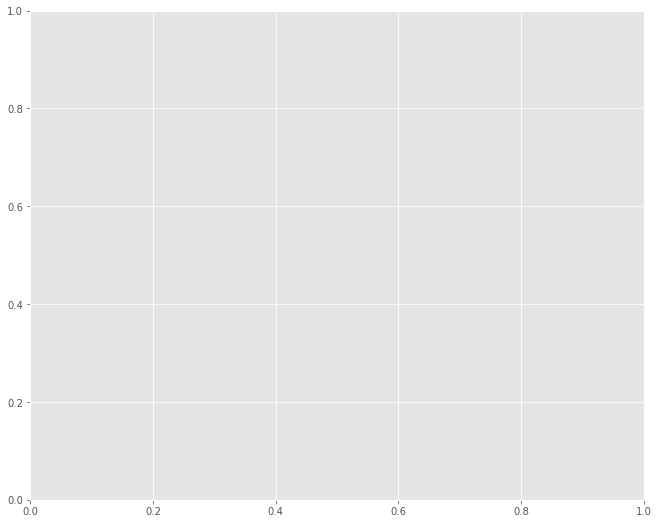

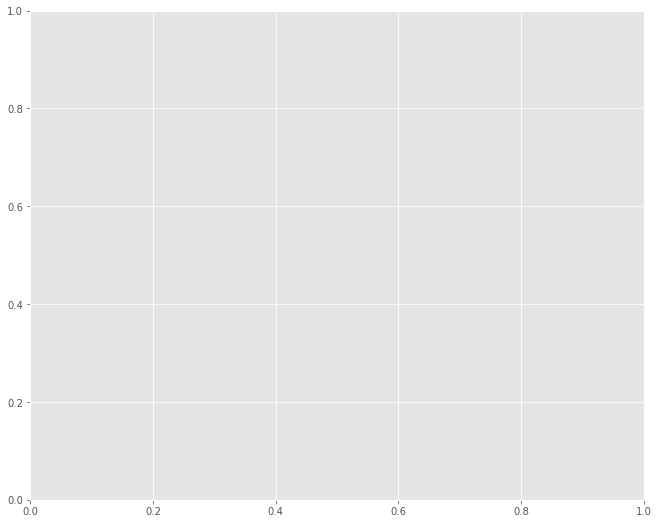

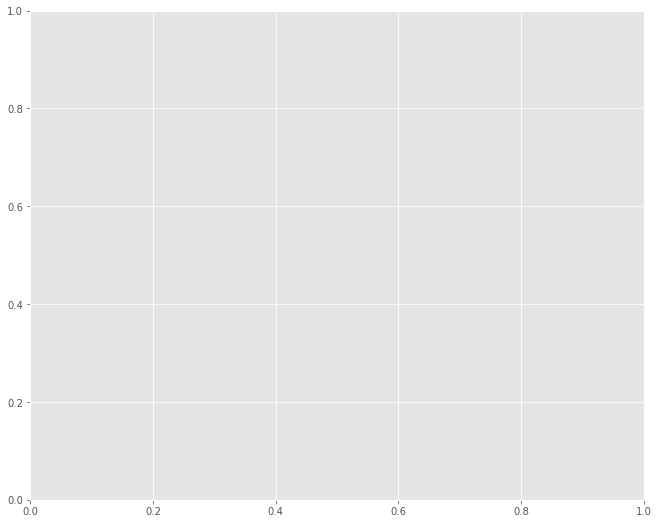

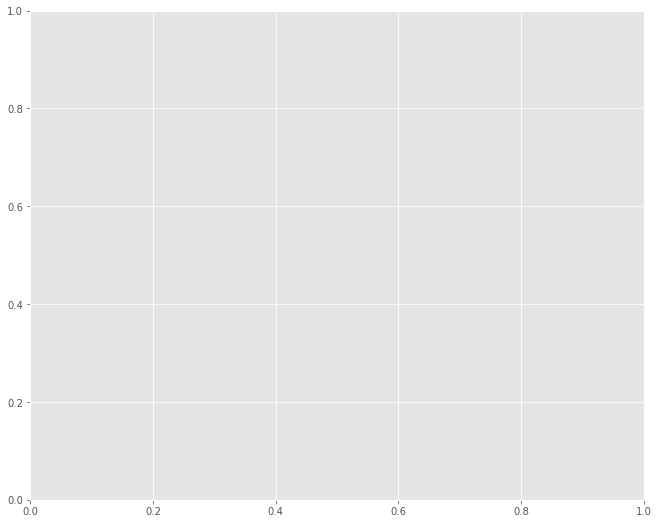

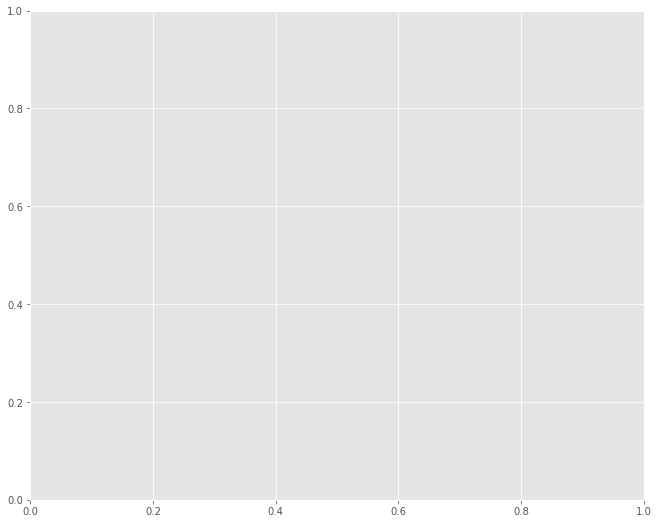

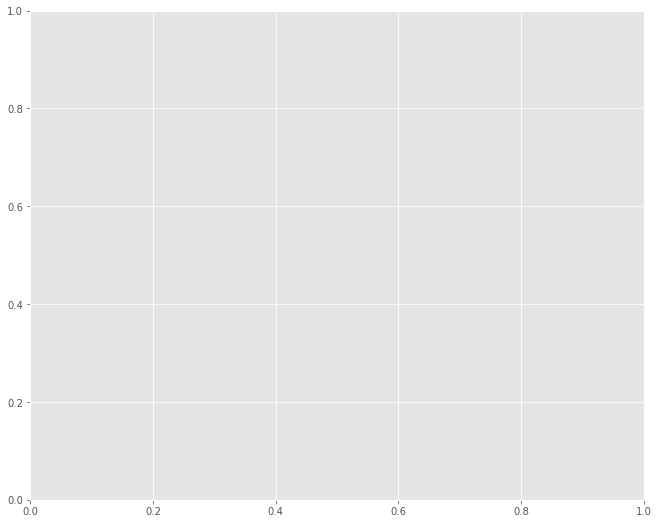

Error in callback <function flush_figures at 0x7fd30a266680> (for post_execute):


KeyboardInterrupt: 

In [52]:
for actor in names_title_dict:
    fig, ax = plt.subplots(figsize=(11, 9))
    # https://stackoverflow.com/questions/41964618/boolean-matrix-form-pythons-dict-of-lists
    values = names_title_dict[actor]
    print(actor,values)
    data = {}
    boolean_table_name_cols = pd.DataFrame(data, columns=values)

    for key in names_title_dict:
        print(key)
        data[actor] = [True if value in names_title_dict[key] else False for value in values]
        print(data[actor])
#         for index in boolean_table_name_cols:
#             boolean_table_name_cols.append(data[actor])
        boolean_table_name_cols
        
#         sb.heatmap(boolean_table_name_cols)
#     plt.GridSpec(boolean_table_title_cols,ncols=len(values))
#     plt.show()

In [99]:
data = {}
for actor in names_title_dict:
    # https://stackoverflow.com/questions/41964618/boolean-matrix-form-pythons-dict-of-lists
    values = names_title_dict[actor]
    headers = values[:]
    headers.insert(0,'actor')
    print(headers)
    print(values)

#     print(actor,values)
    
    actor_dict_2d = [headers]

    for key in names_title_dict:
#         print(key)
#         data[actor] = [True if value in names_title_dict[key] else False for value in values]
#         print(data[actor])
        t_or_f = [True if value in names_title_dict[key] else False for value in values]
        t_or_f.insert(0,key)
        actor_dict_2d.append(t_or_f)
    data[actor] = actor_dict_2d
# print(data)


['actor', 'tt0072562', 'tt0077975', 'tt0078723', 'tt0080455']
['tt0072562', 'tt0077975', 'tt0078723', 'tt0080455']
['actor', 'tt0118747', 'tt0087332', 'tt0097428', 'tt0080455']
['tt0118747', 'tt0087332', 'tt0097428', 'tt0080455']
['actor', 'tt1687207', 'tt2784678', 'tt0122145', 'tt3603706', 'tt1810727', 'tt5156614', 'tt16589596', 'tt2282941', 'tt1538443', 'tt13998382', 'tt3091734', 'tt4742812', 'tt1740656', 'tt14779558', 'tt3872944', 'tt0362270', 'tt3790306', 'tt3503754', 'tt2243836', 'tt2357748', 'tt0281438', 'tt1732762', 'tt1490534', 'tt1600694', 'tt0448004', 'tt0128445', 'tt2356940', 'tt4571940', 'tt1837678', 'tt3147486', 'tt2828570', 'tt0351810', 'tt0335266', 'tt5774598', 'tt1884251', 'tt1210095', 'tt2147467', 'tt1972582', 'tt0457251', 'tt2450652', 'tt0961721', 'tt0189500', 'tt3231836', 'tt0072562', 'tt1748122', 'tt12762460', 'tt2202391', 'tt0288154', 'tt1911645', 'tt0115367', 'tt0499556', 'tt0097132', 'tt6384192']
['tt1687207', 'tt2784678', 'tt0122145', 'tt3603706', 'tt1810727', '

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

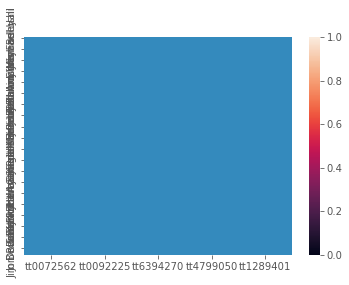

In [114]:
Kate_table = pd.DataFrame(data['Kate McKinnon']).set_index(0)
Kate_table
header = Kate_table.iloc[0]
Kate_table.columns = header
Kate_table = pd.DataFrame(Kate_table[1:], columns=header)
# Kate_table.values[0:]
Kate_table.columns
# sb.heatmap(Kate_table)

John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark 

Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel

Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davi

Tim Robinson
Harry Shearer
Charles Rocket
Maya Rudolph
Horatio Sanz
Tom Schiller
Paul Shaffer
Molly Shannon
Sarah Silverman
Robert Smigel
Pamela Stephenson
Jason Sudeikis
Julia Sweeney
Terry Sweeney
Kenan Thompson
Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim 

/Users/tzacks2/.conda/envs/DataViz2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).




Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. W

Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner


John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark 

Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark McKinney
Kate McKinnon
Laurie Metcalf
Dennis Miller
Jerry Minor
Tracy Morgan
Garrett Morris
Laraine Newman
Don Novello
Mike O'Brien
Michael O'Donoghue
Cheri Oteri
Chris Parnell
Joe Piscopo
Amy Poehler
Emily Prager
Colin Quinn
Gilda Radner
Tony Rosato
Jeff Richards
Ann Risley
Tim Robinson
Harry Shearer
Charles Rocket
Maya Rudolph
Horatio Sanz
Tom Schiller
Paul Shaffer
Molly Shannon
Sarah Silverman
Robert Smigel
Pamela Stephenson
Jason Sudeikis
Julia Sweeney
Terry Sweeney
Kenan Thompson
Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Vil

Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nor

Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Mea

Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark McKinney
Kate McKinnon
Laurie Metcalf
Dennis Miller
Jerry Minor
Tracy Morgan
Garrett Morris
Laraine Newman
Don Novello
Mike O'Brien
Michael O'Donoghue
Cheri Oteri
Chris Parnell
Joe Piscopo
Amy Poehler
Emily Prager
Colin Quinn
Gilda Radner
Tony Rosato
Jeff Richards
Ann Risley
Tim Robinson
Harry Shearer
Charles Rocket
Maya Rudolph
Horatio Sanz
Tom Schiller
Paul Shaffer
Molly Shannon
Sarah Silverman
Robert Smigel
Pamela Stephenson
Jason Sudeikis
Julia Sweeney
Terry Swee

John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark 

Jason Sudeikis
Julia Sweeney
Terry Sweeney
Kenan Thompson
Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Da

Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark McKinney
Kate McKinnon
Laurie Metcalf
Dennis Miller
Jerry Mi

Mike O'Brien
Michael O'Donoghue
Cheri Oteri
Chris Parnell
Joe Piscopo
Amy Poehler
Emily Prager
Colin Quinn
Gilda Radner
Tony Rosato
Jeff Richards
Ann Risley
Tim Robinson
Harry Shearer
Charles Rocket
Maya Rudolph
Horatio Sanz
Tom Schiller
Paul Shaffer
Molly Shannon
Sarah Silverman
Robert Smigel
Pamela Stephenson
Jason Sudeikis
Julia Sweeney
Terry Sweeney
Kenan Thompson
Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
D

Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Ric

John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark 

Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dill

Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Vic

Robert Smigel
Pamela Stephenson
Jason Sudeikis
Julia Sweeney
Terry Sweeney
Kenan Thompson
Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schne

Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark McKinney
Kate McKinnon
Laurie Metcalf

Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Micha

Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel

Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Wh

Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Ay

John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nora Dunn
Tim Meadows
Kevin Nealon
David Spade
Fred Armisen
Peter Aykroyd
Morwenna Banks
Jim Breuer
A. Whitney Brown
Beth Cahill
Ellen Cleghorne
George Coe
Pete Davidson
Tom Davis
Denny Dillon
Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark 

Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Meyers
Lauren Holt
Michaela Watkins
Heidi Gardner
Sarah Sherman
Bobby Moynihan
Kristen Wiig
Kyle Mooney
Rob Riggle
Finesse Mitchell
Mikey Day
Andy Samberg
Paul Brittain
Nasim Pedrad
Colin Jost
Abby Elliott
John Milhiser
Alex Moffat
Aristotle Athari
Jenny Slate
Beck Bennett
Vanessa Bayer
Sasheer Zamata
Noël Wells
Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon
John Belushi
Dan Aykroyd
Bill Murray
Mike Myers
Chevy Chase
Billy Crystal
Joan Cusack
Robert Downey Jr.
Chris Farley
Janeane Garofalo
Julia Louis-Dreyfus
Eddie Murphy
Jim Belushi
Dana Carvey
Adam Sandler
Christopher Guest
Anthony Michael Hall
Jon Lovitz
Jay Mohr
Randy Quaid
Chris Rock
Rob Schneider
Martin Short
Ben Stiller
Damon Wayans
Christine Ebersole
Will Ferrell
Jane Curtin
Nor

Brian Doyle-Murray
Rachel Dratch
Robin Duke
Dean Edwards
Chris Elliott
Jimmy Fallon
Tina Fey
Will Forte
Al Franken
Ana Gasteyer
Gilbert Gottfried
Mary Gross
Bill Hader
Brad Hall
Rich Hall
Darrell Hammond
Phil Hartman
Jan Hooks
Yvonne Hudson
Melanie Hutsell
Victoria Jackson
Leslie Jones
Chris Kattan
Tim Kazurinsky
Laura Kightlinger
Taran Killam
David Koechner
Gary Kroeger
Matthew Laurance
Gail Matthius
Michael McKean
Mark McKinney
Kate McKinnon
Laurie Metcalf
Dennis Miller
Jerry Minor
Tracy Morgan
Garrett Morris
Laraine Newman
Don Novello
Mike O'Brien
Michael O'Donoghue
Cheri Oteri
Chris Parnell
Joe Piscopo
Amy Poehler
Emily Prager
Colin Quinn
Gilda Radner
Tony Rosato
Jeff Richards
Ann Risley
Tim Robinson
Harry Shearer
Charles Rocket
Maya Rudolph
Horatio Sanz
Tom Schiller
Paul Shaffer
Molly Shannon
Sarah Silverman
Robert Smigel
Pamela Stephenson
Jason Sudeikis
Julia Sweeney
Terry Sweeney
Kenan Thompson
Danitra Vance
Dan Vitale
Patrick Weathers
Casey Wilson
Fred Wolf
Alan Zweibel
Seth Me

Luke Null
Melissa Villaseñor
Michael Che
Jay Pharoah
Jon Rudnitsky
James Austin Johnson
Chloe Fineman
Ego Nwodim
Brooks Wheelan
Cecily Strong
Aidy Bryant
Chris Redd
Jim Downey
Bowen Yang
Andrew Dismukes
Siobhan Fallon


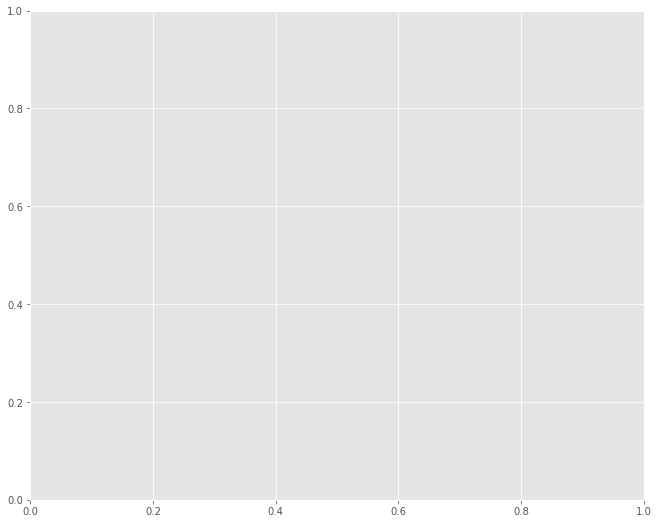

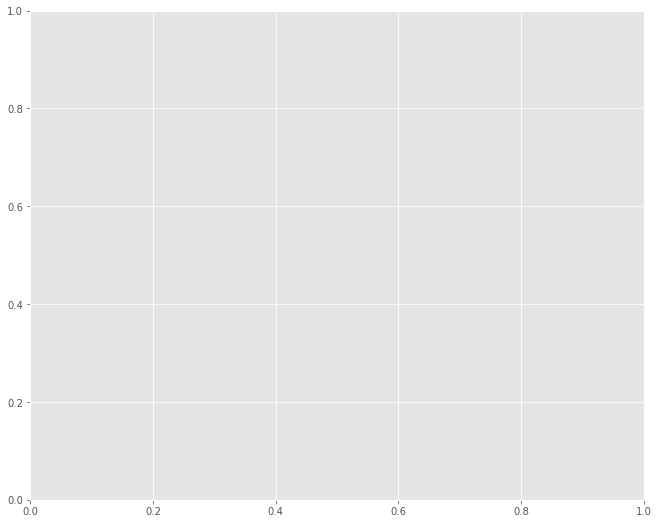

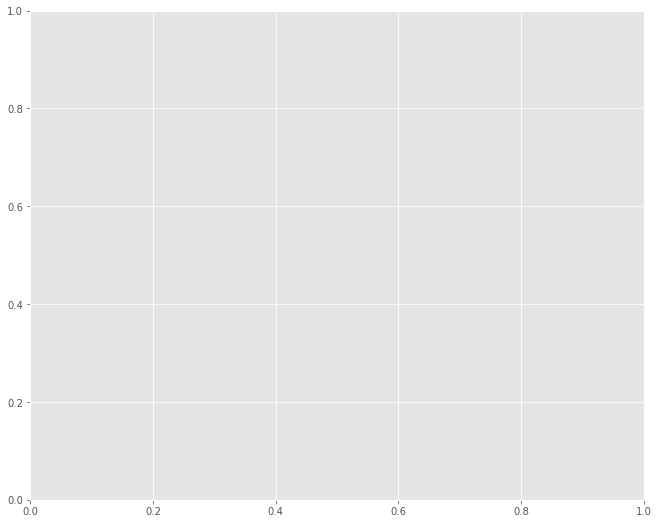

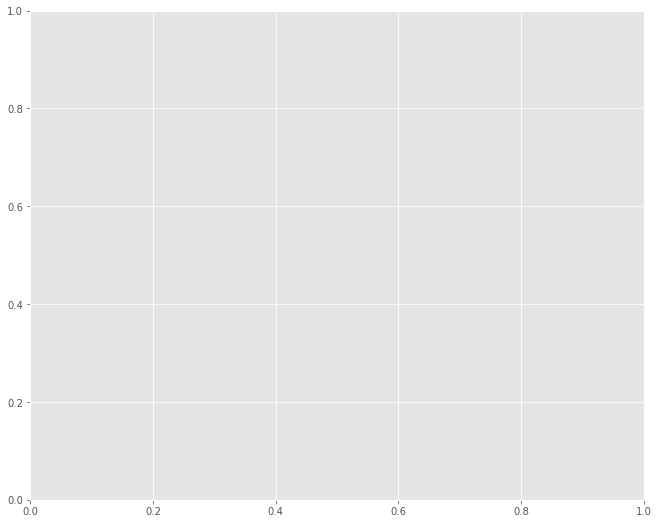

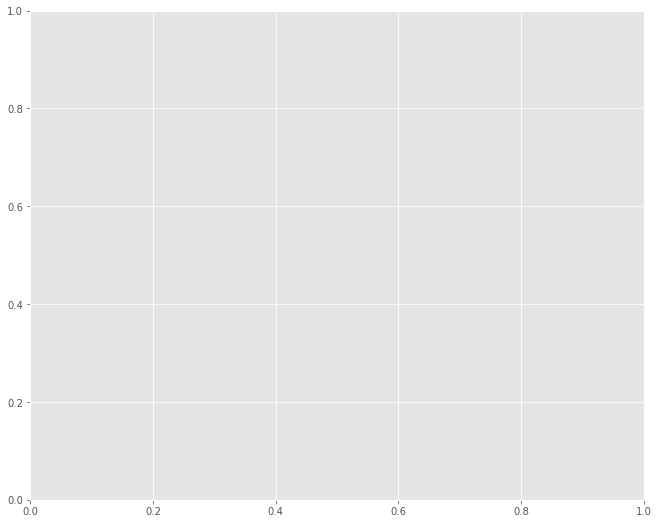

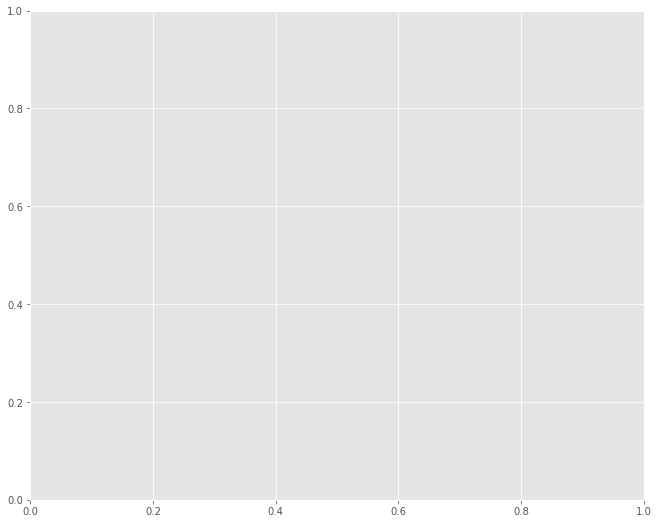

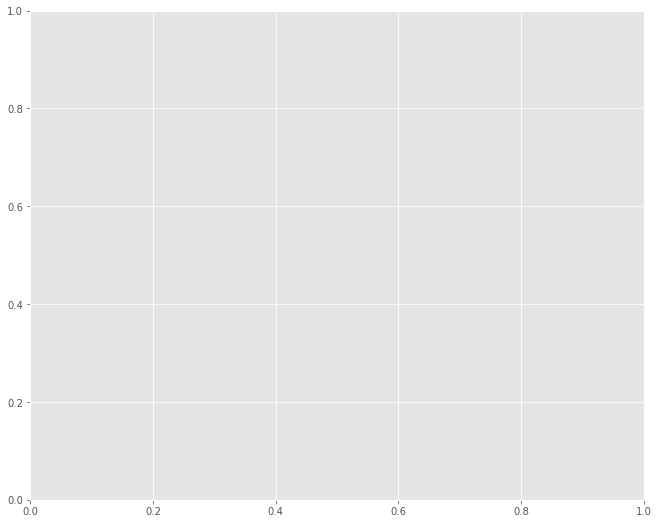

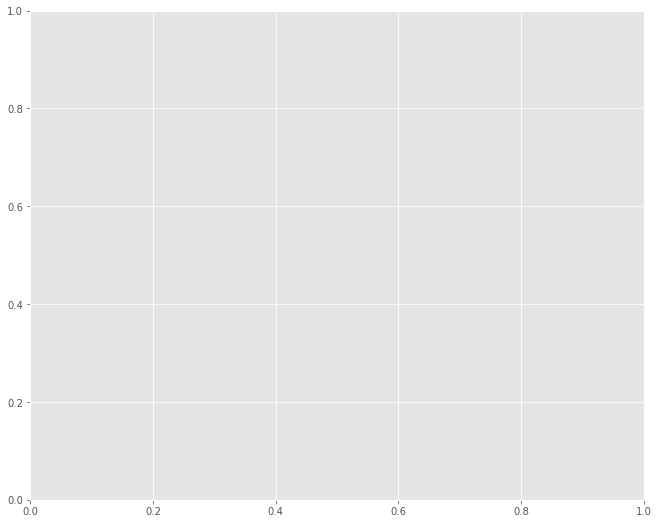

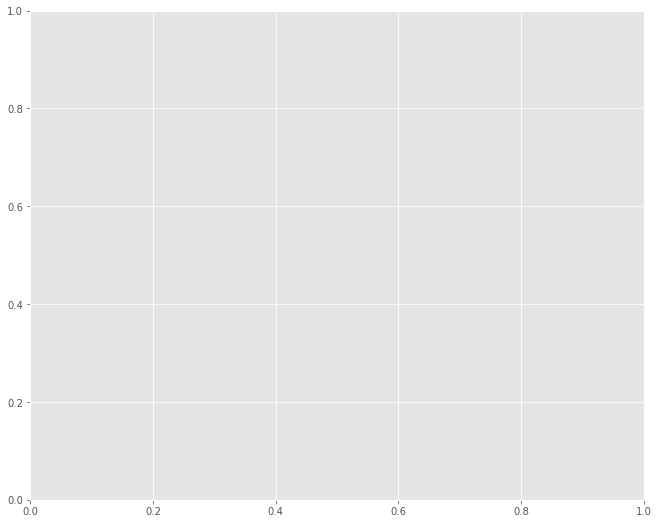

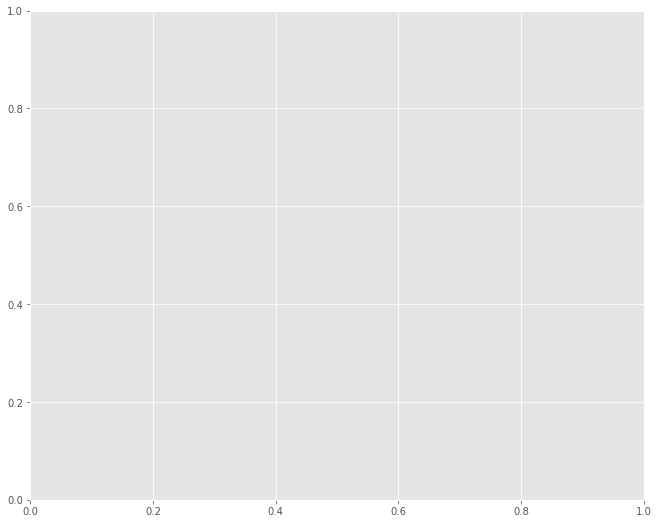

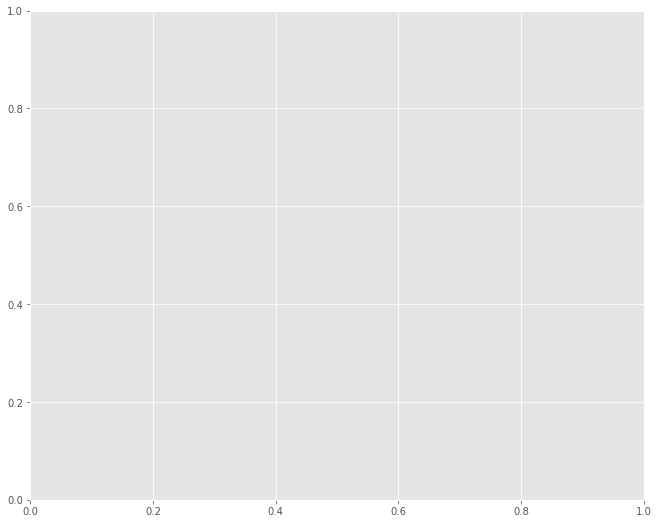

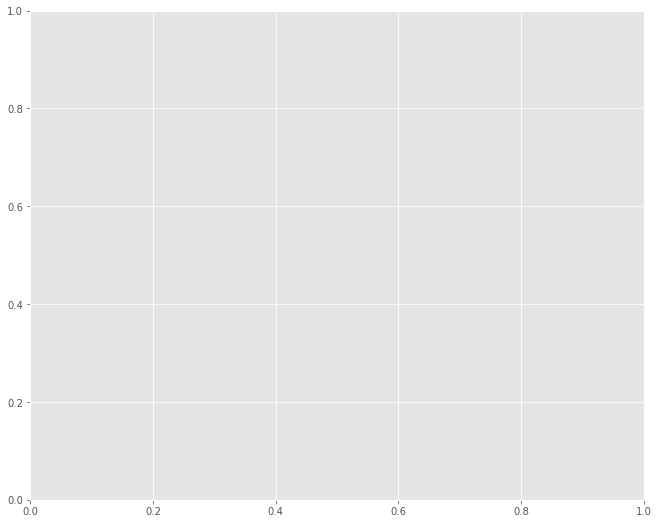

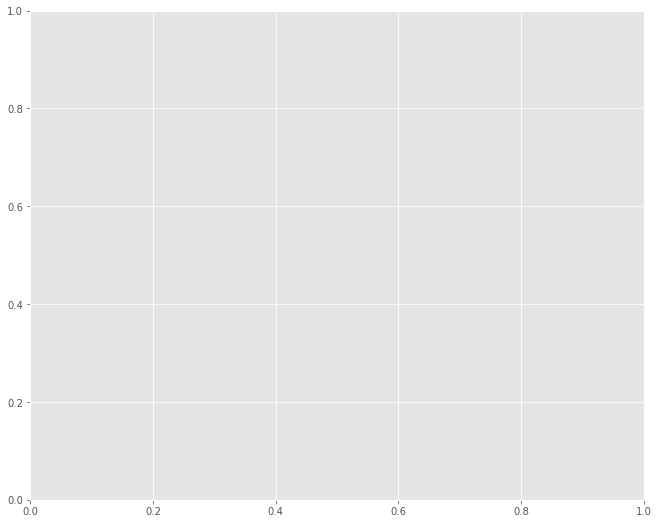

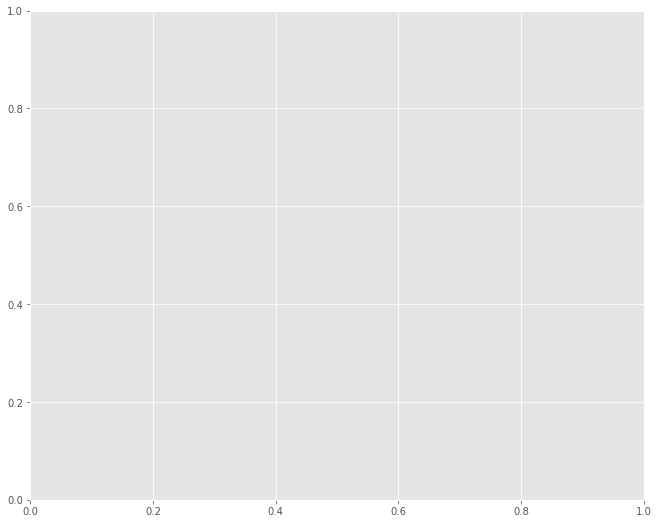

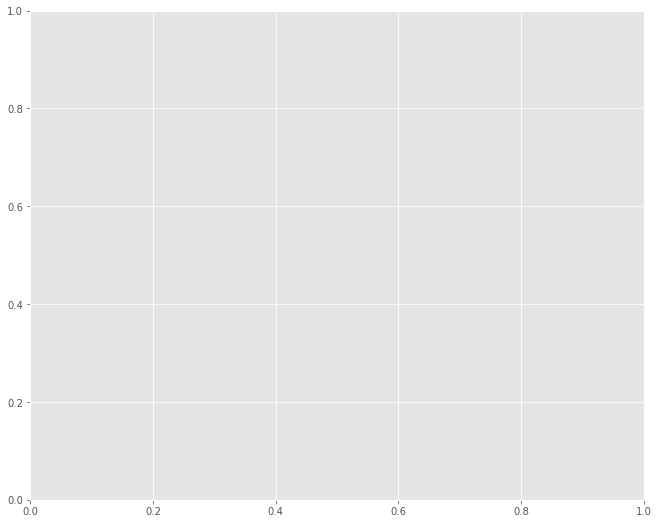

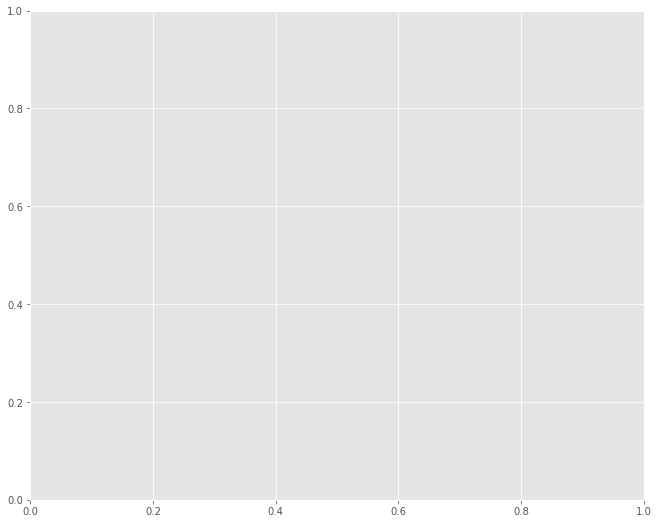

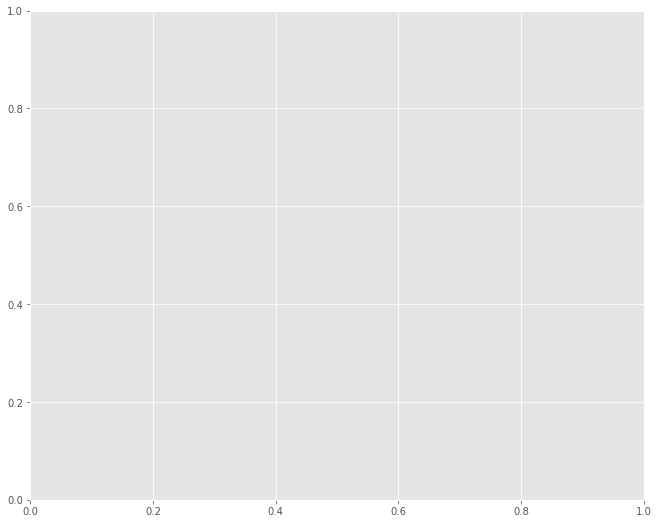

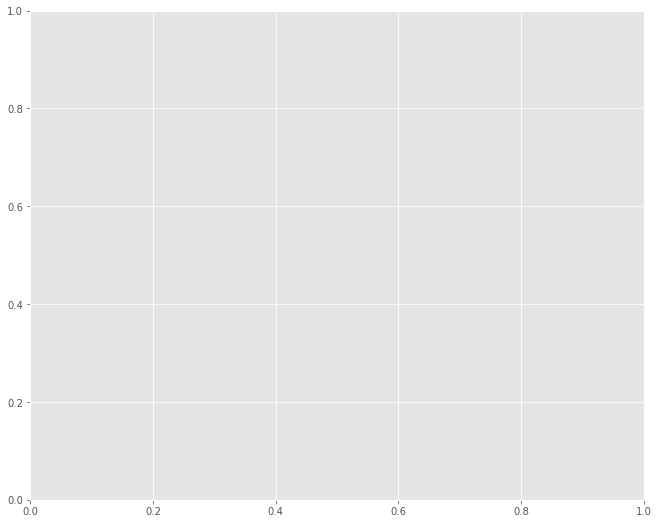

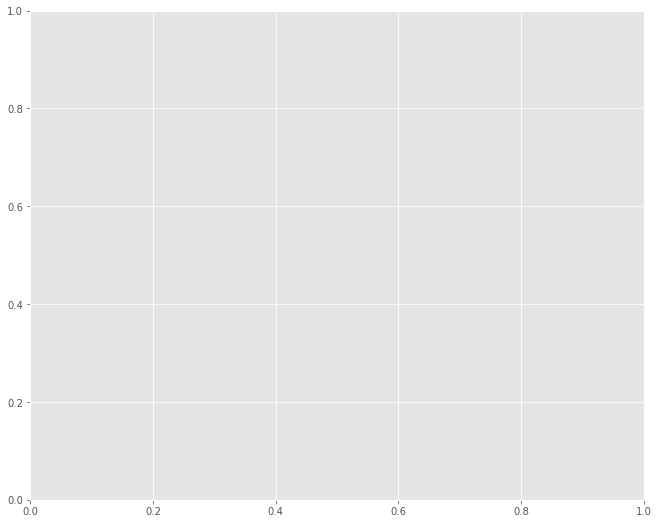

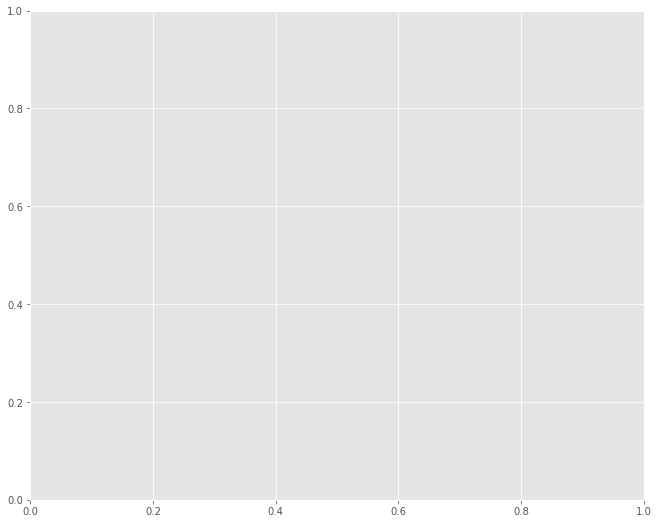

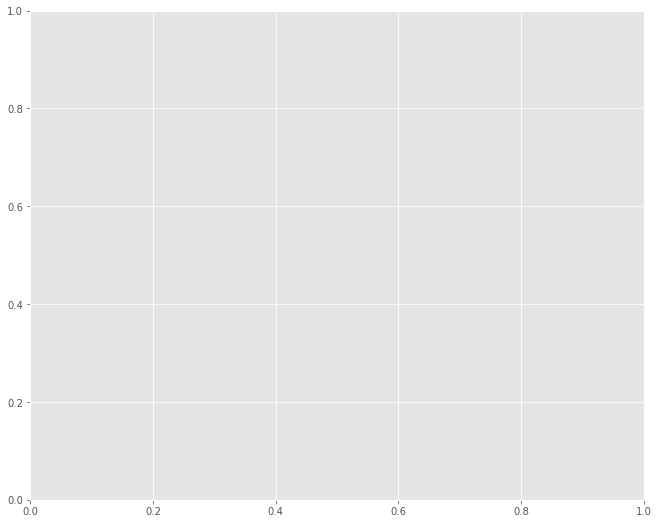

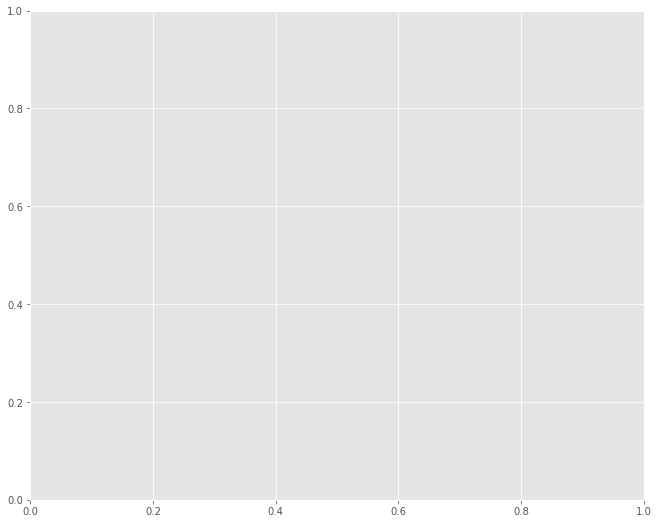

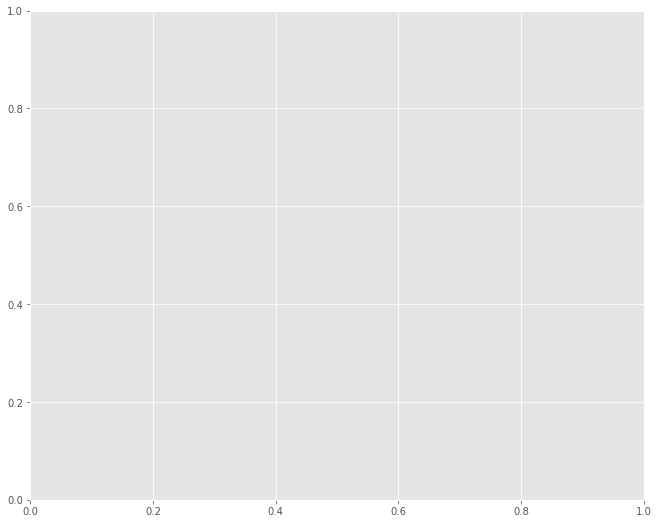

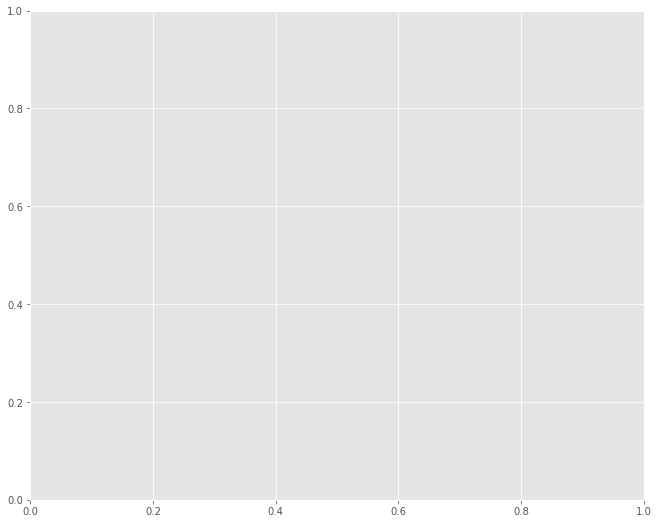

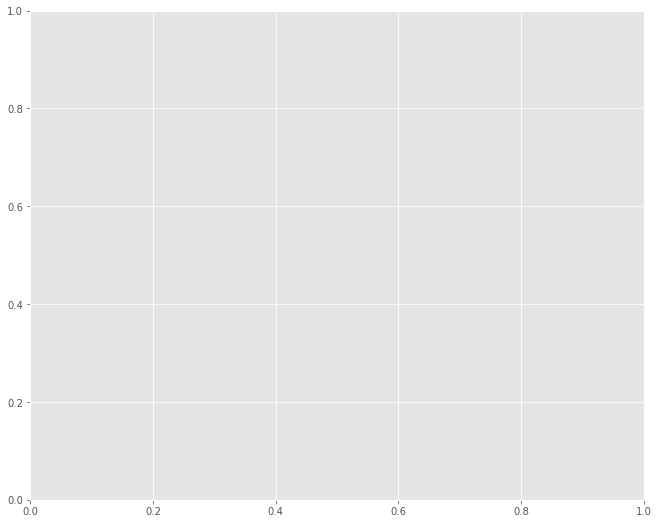

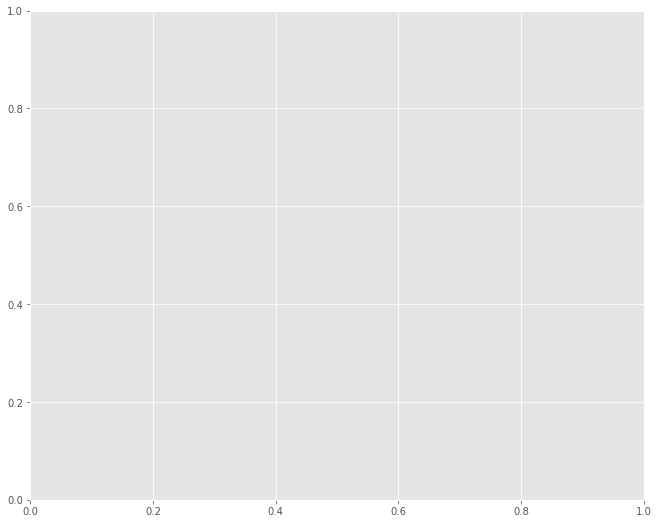

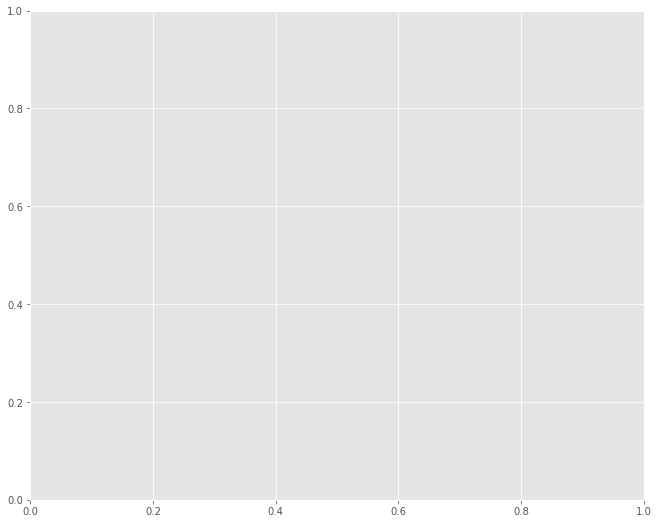

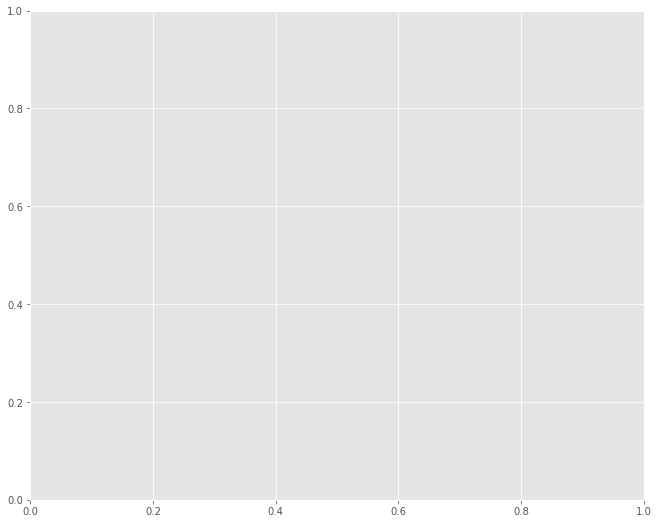

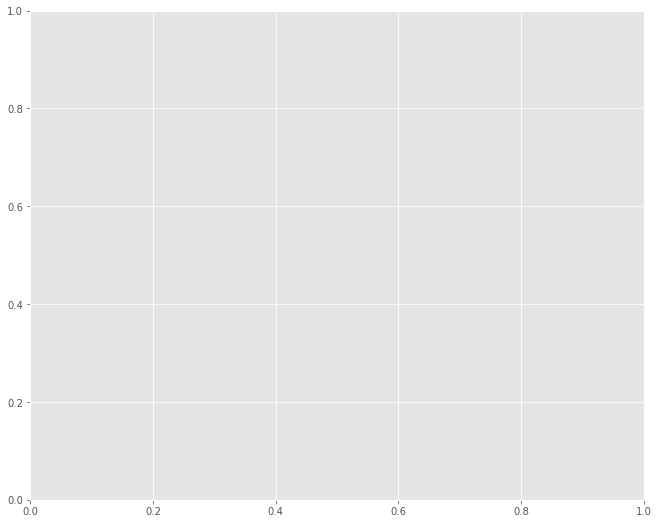

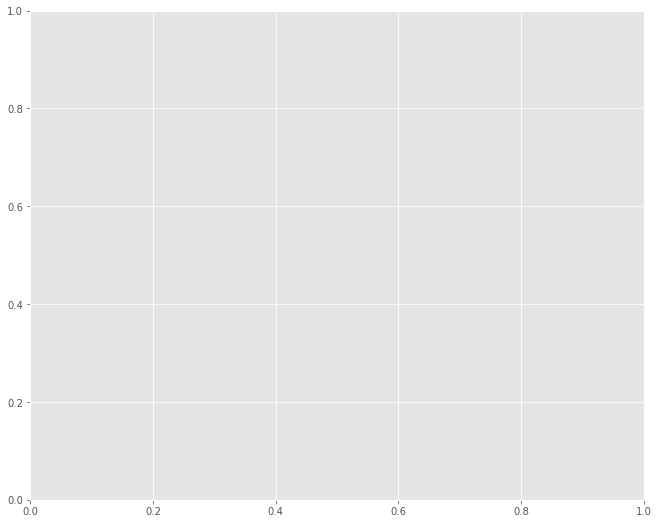

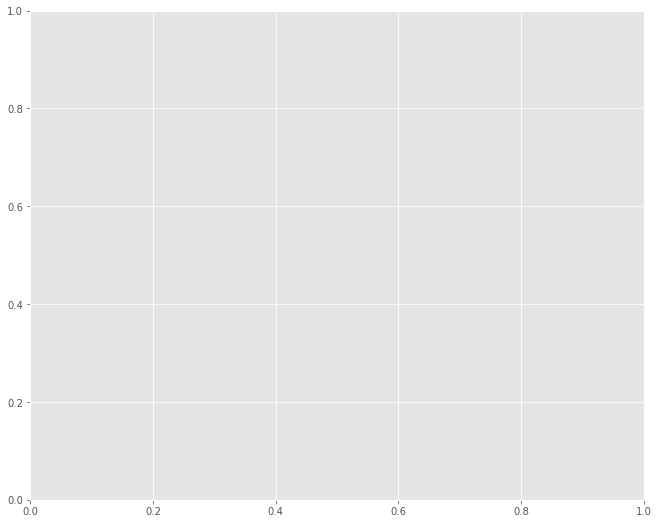

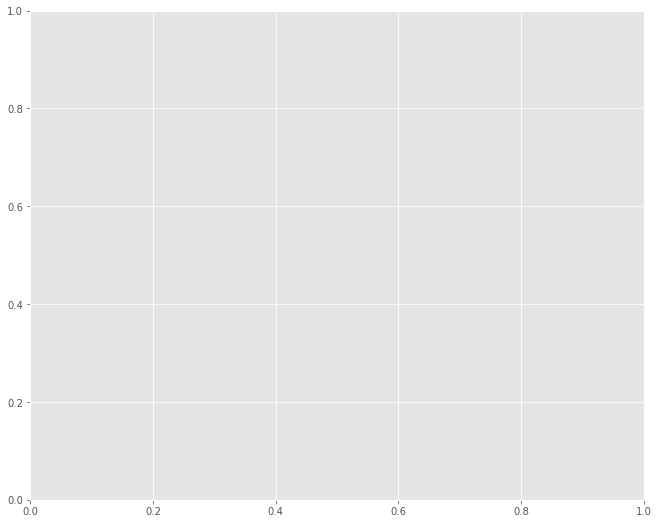

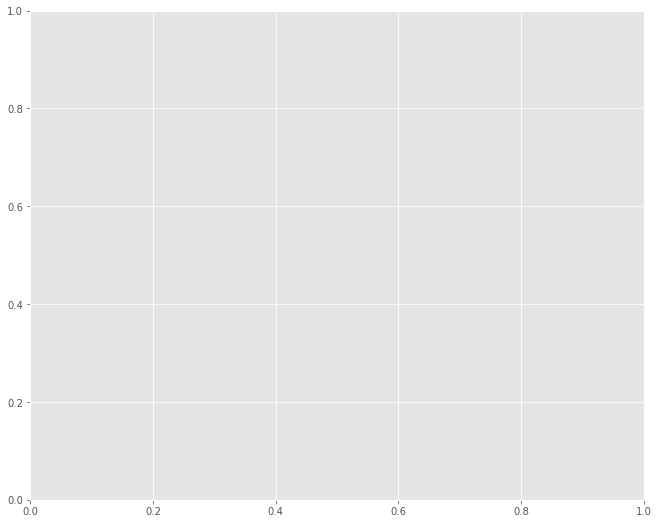

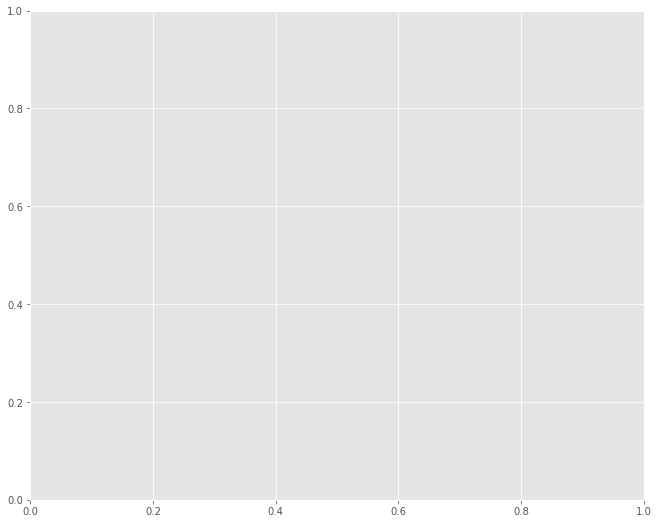

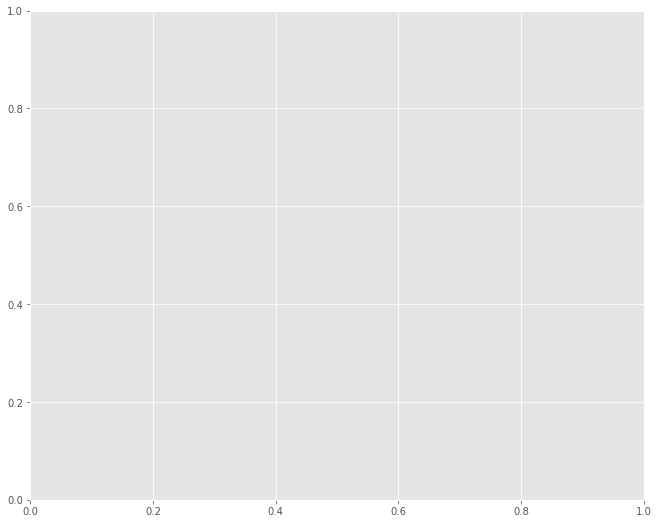

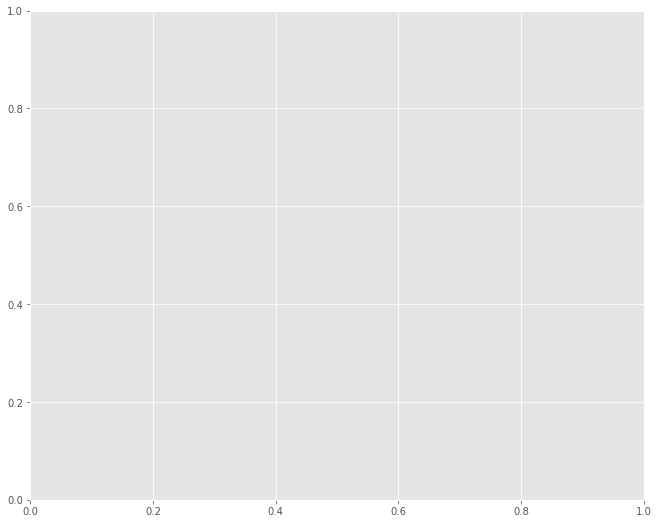

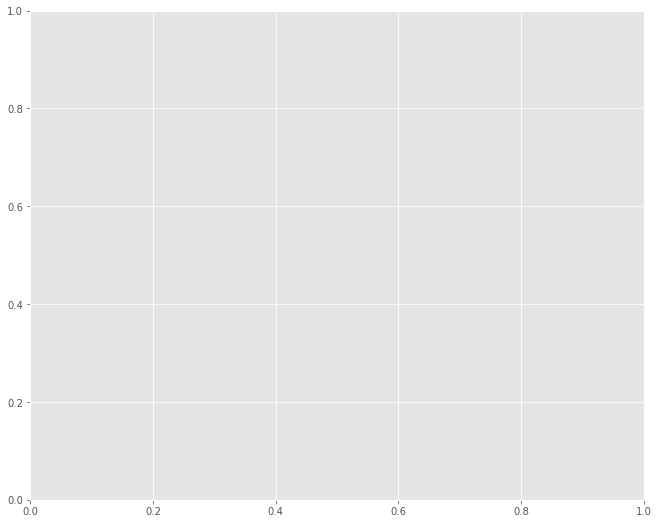

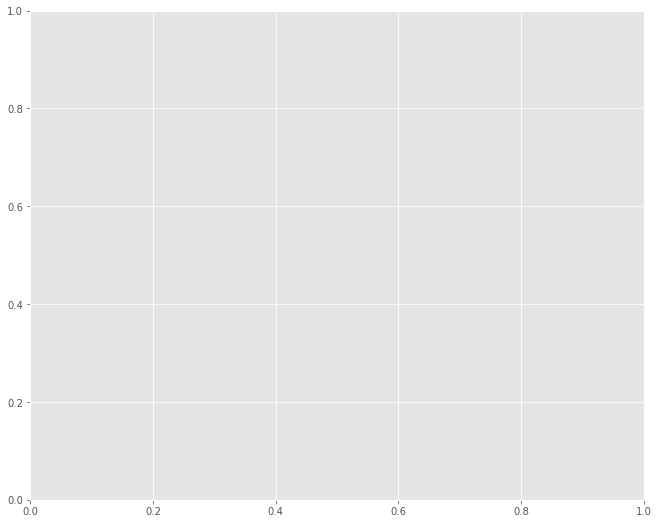

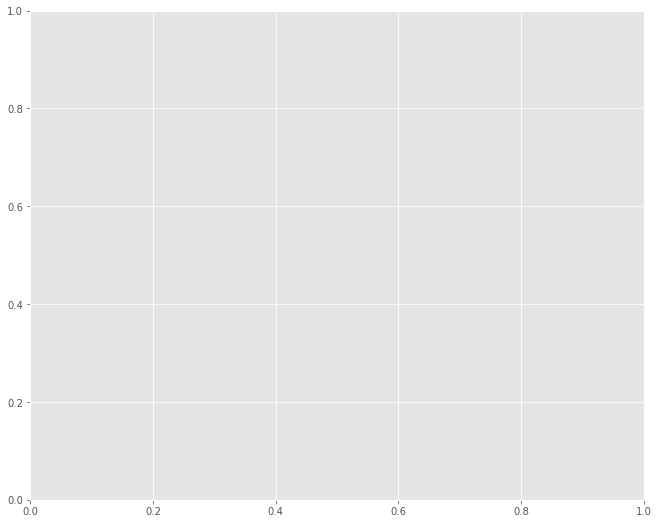

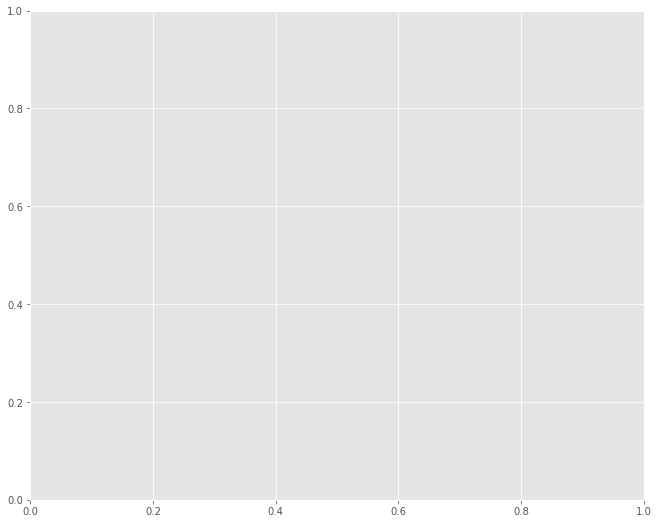

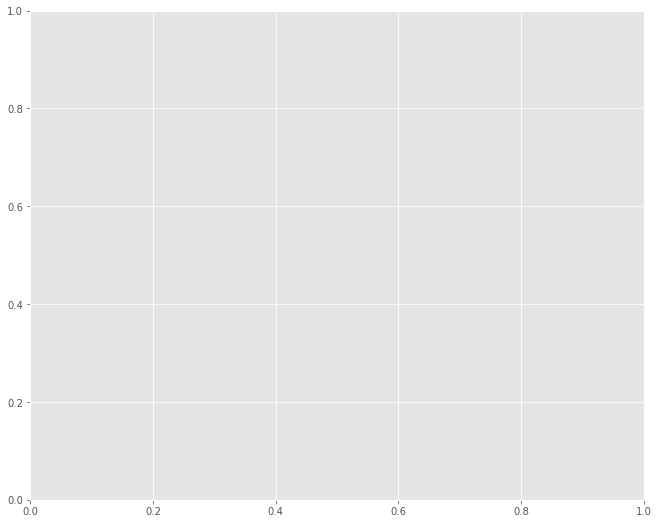

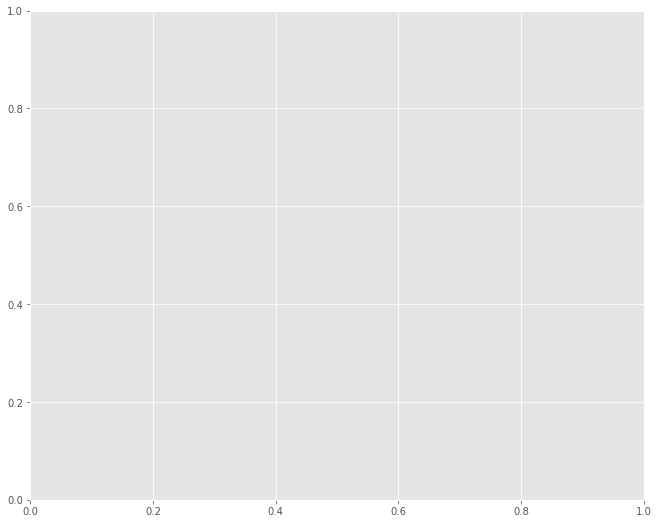

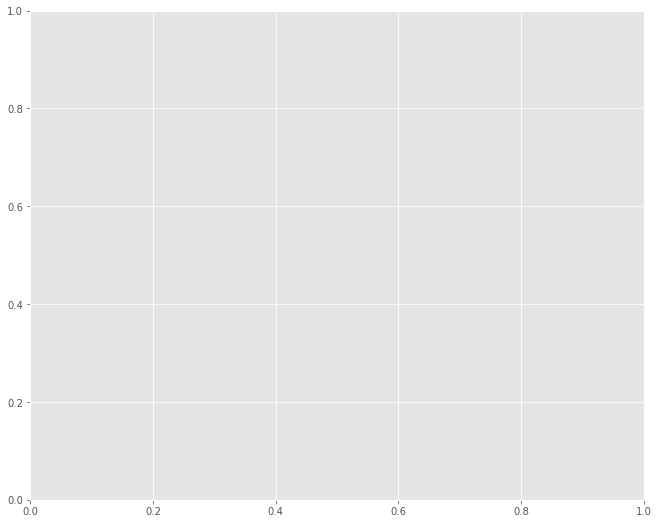

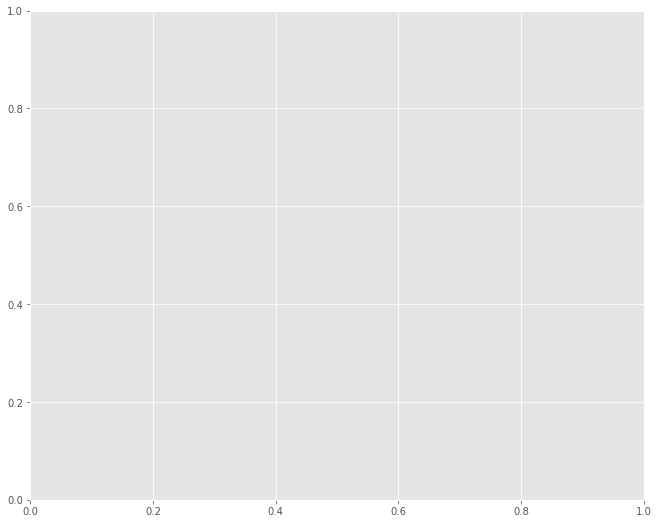

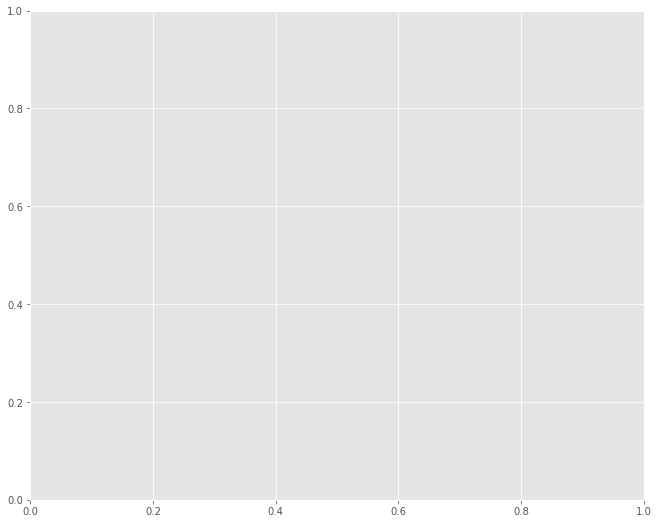

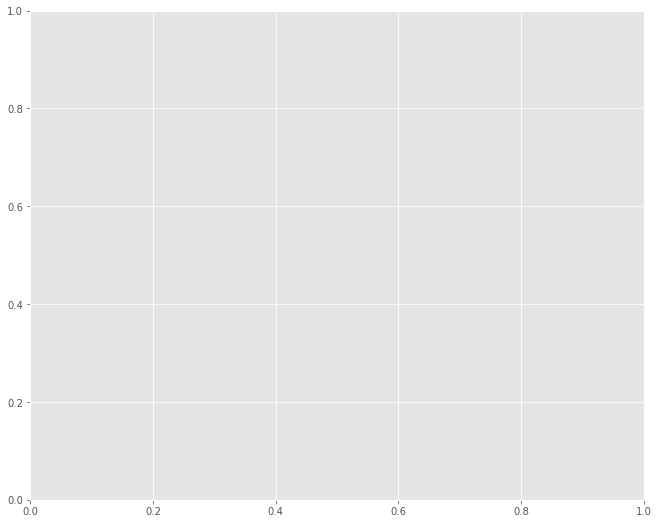

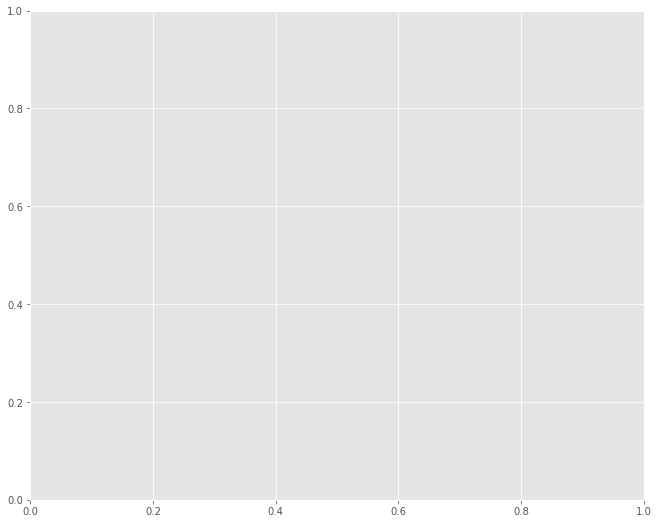

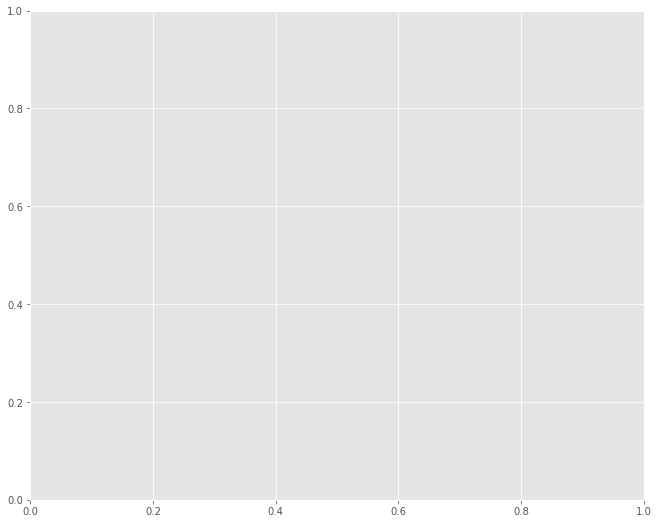

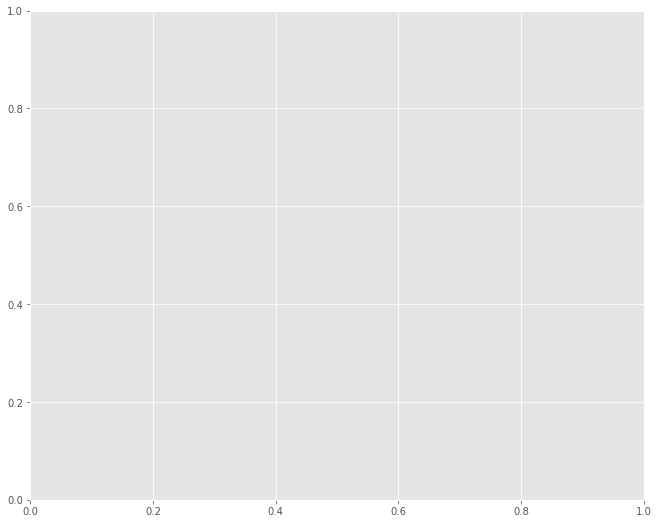

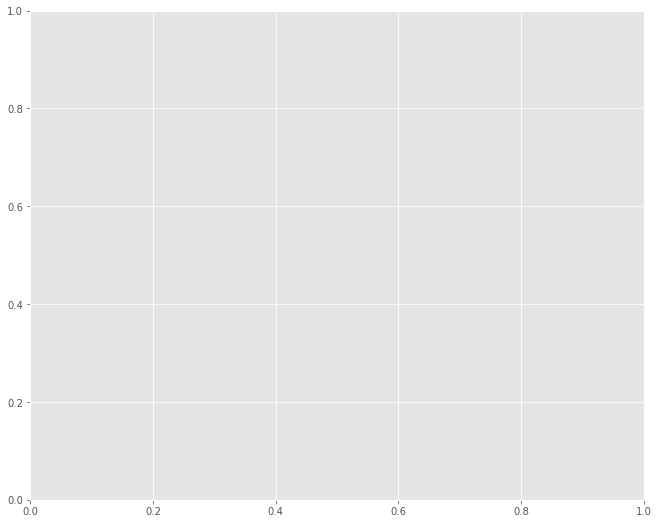

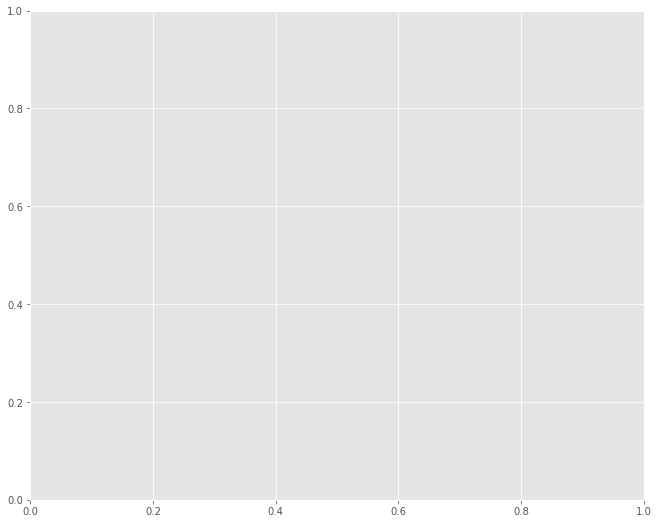

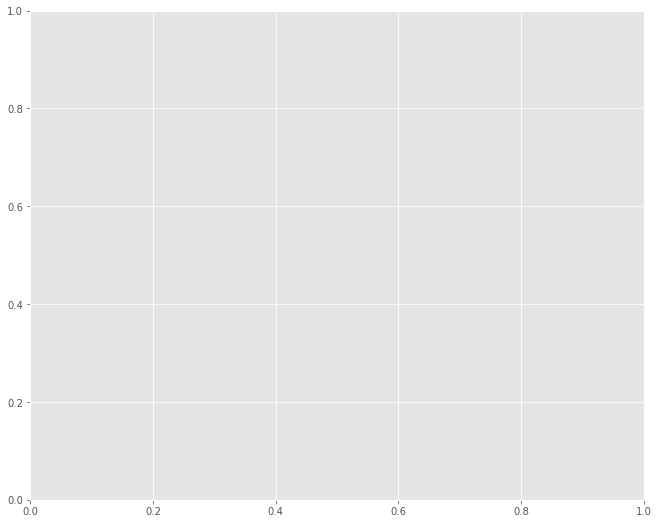

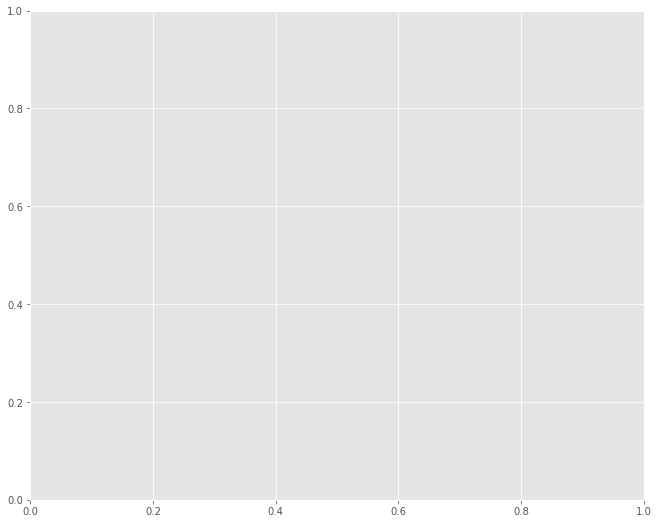

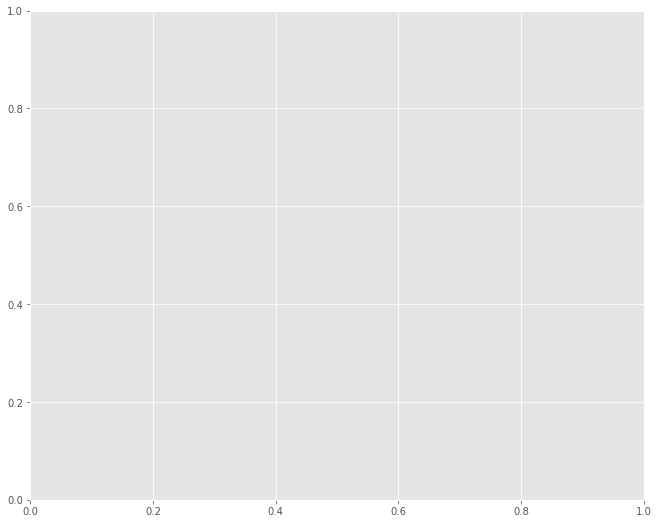

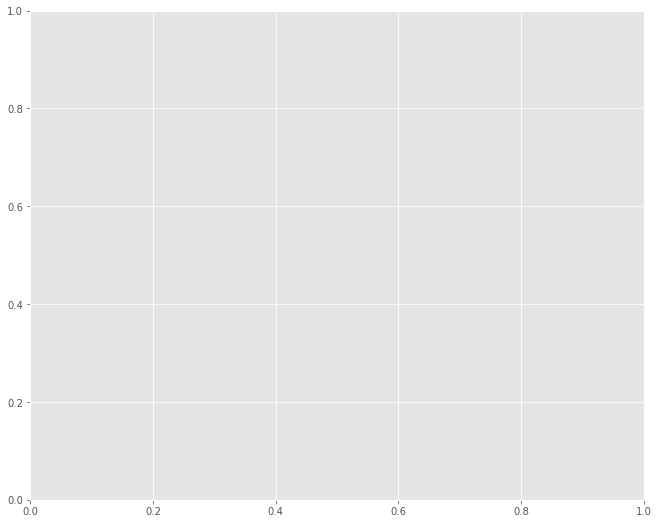

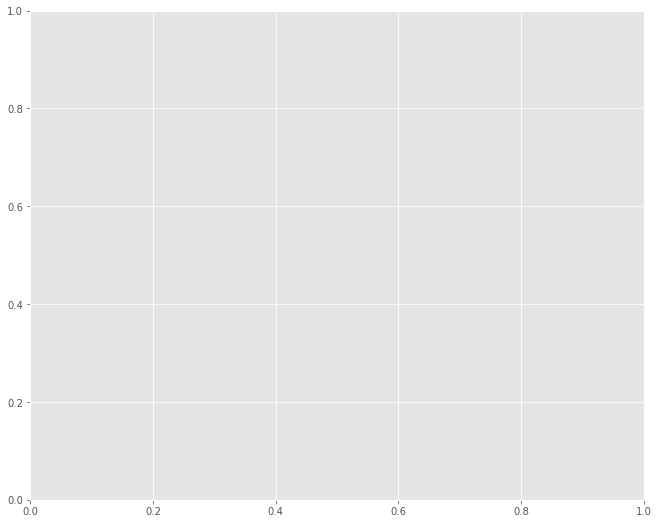

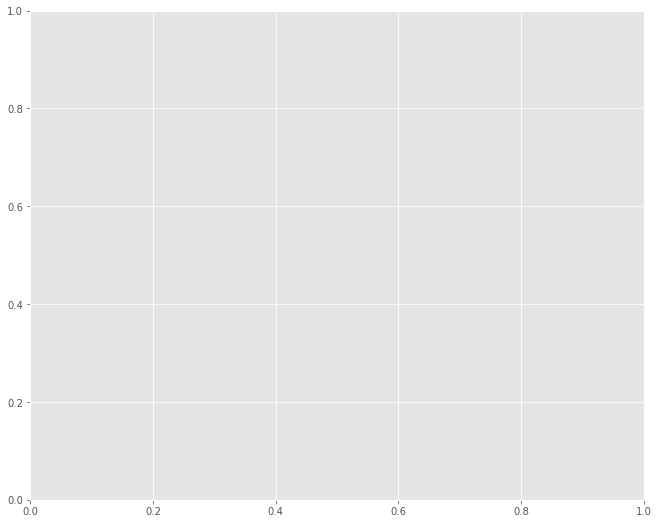

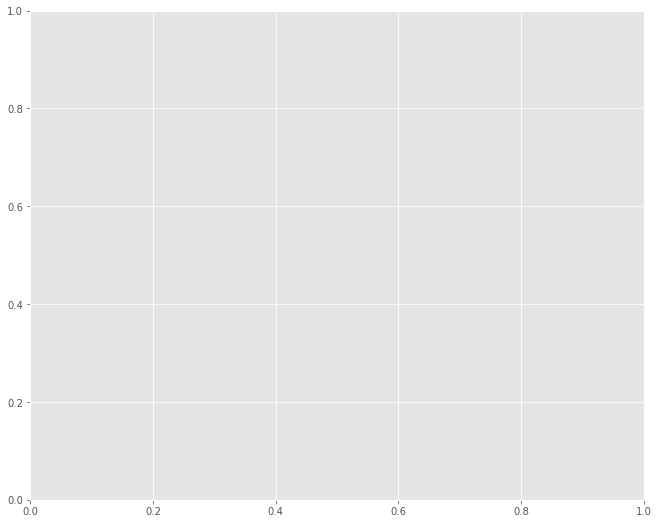

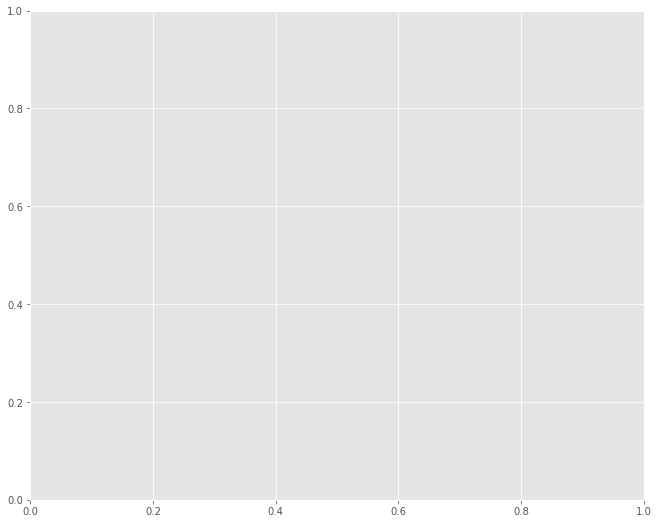

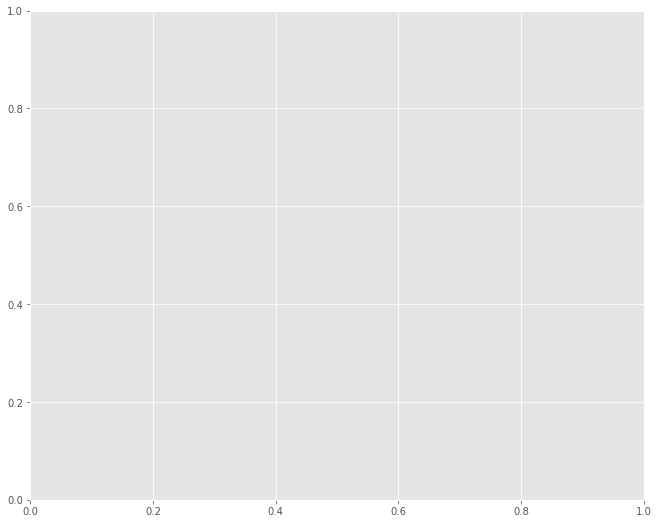

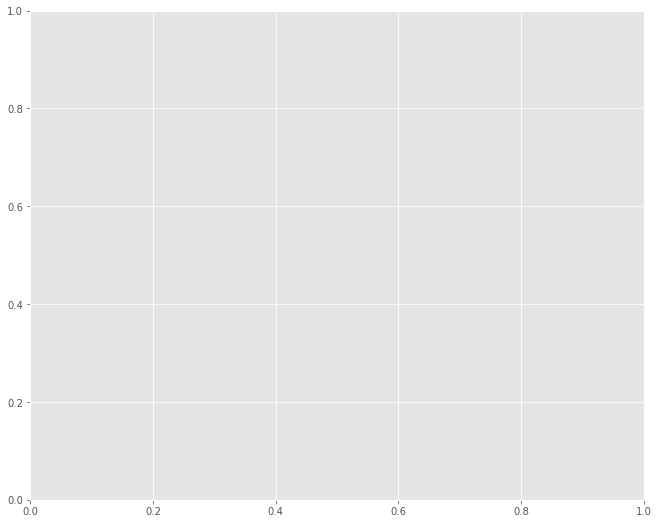

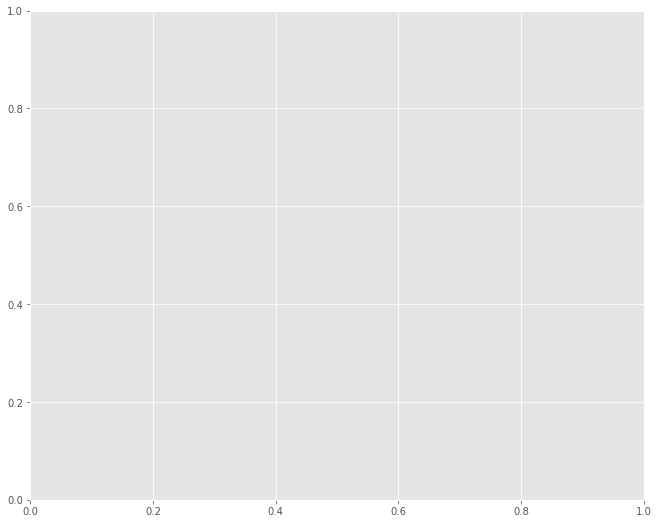

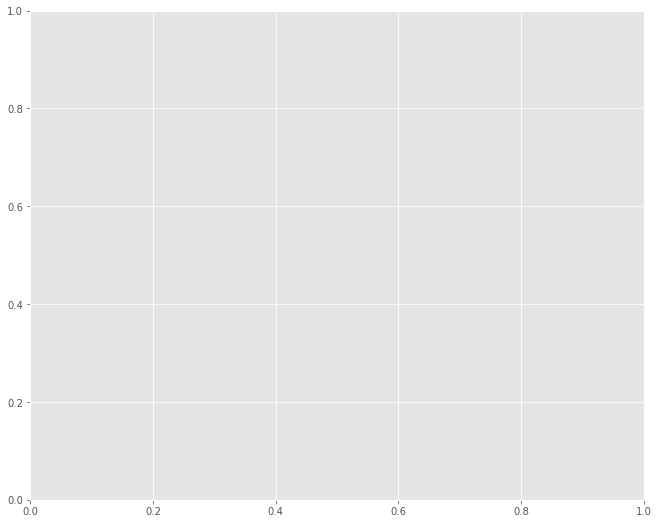

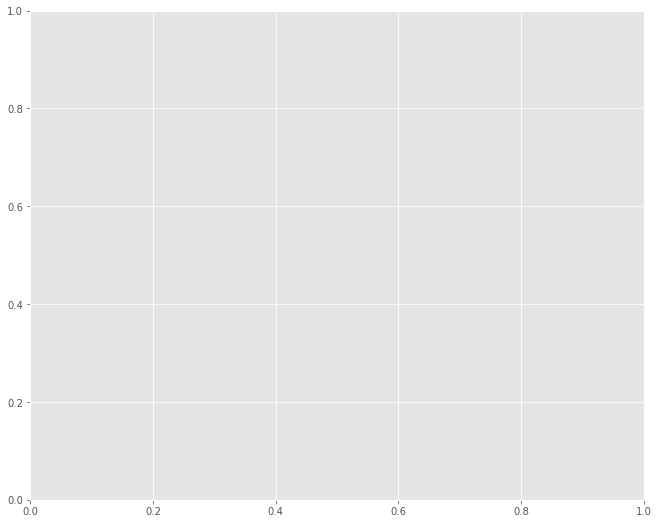

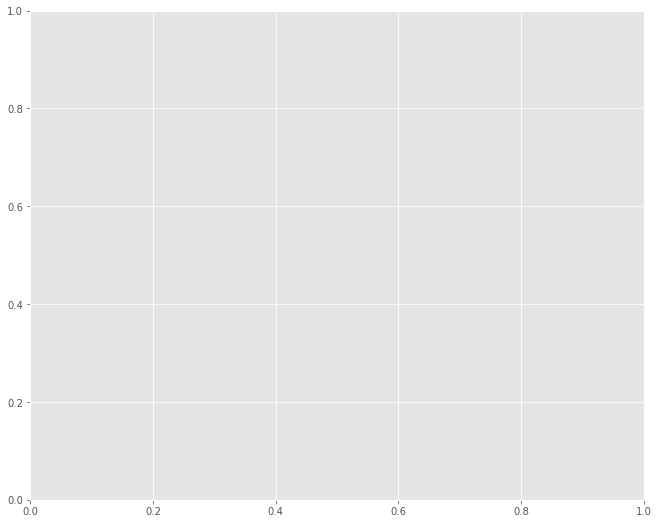

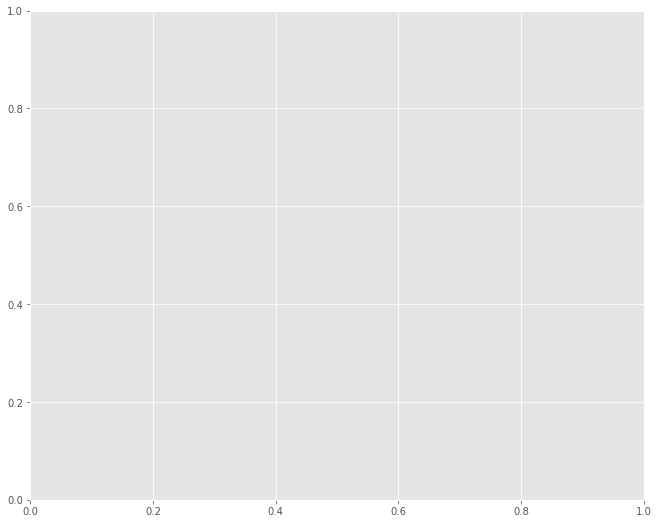

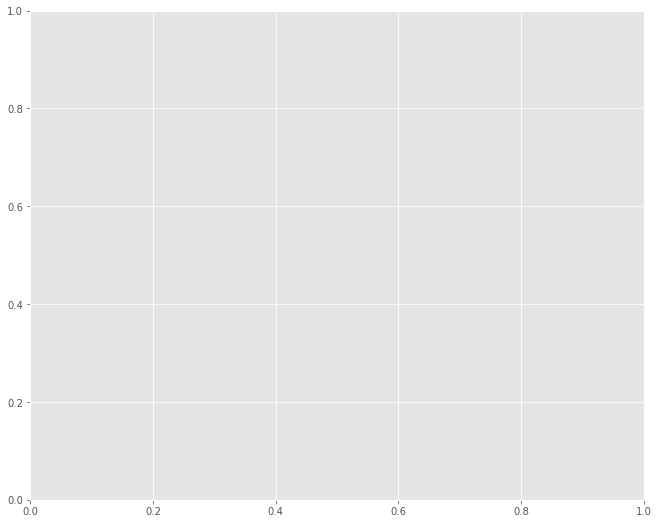

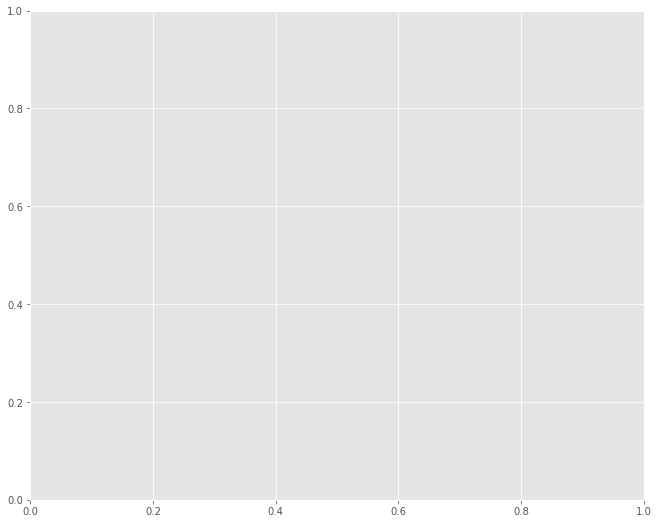

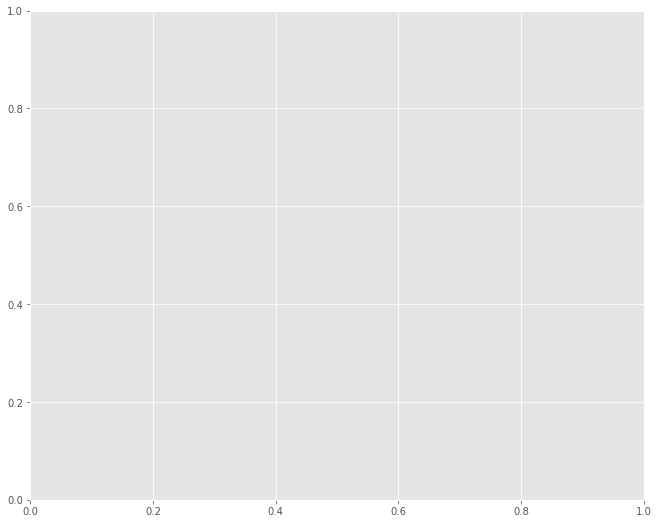

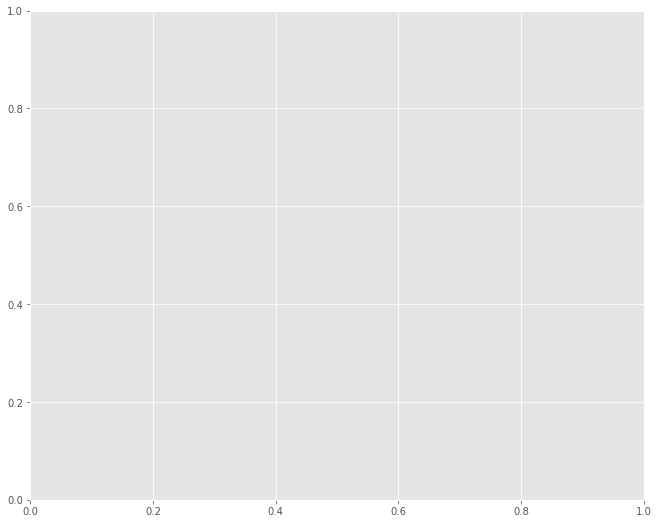

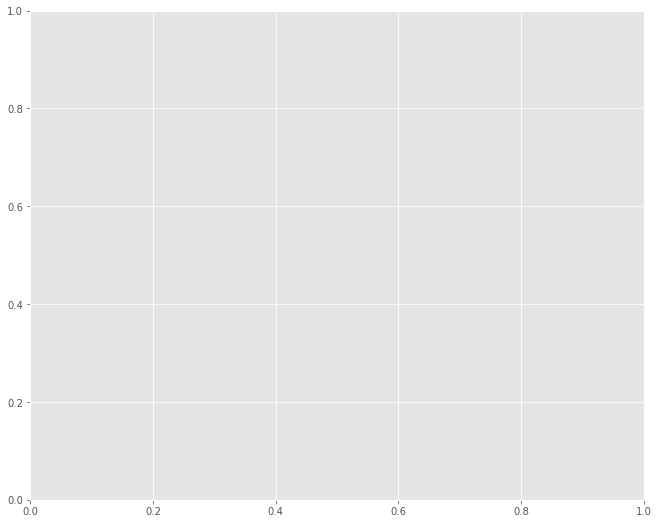

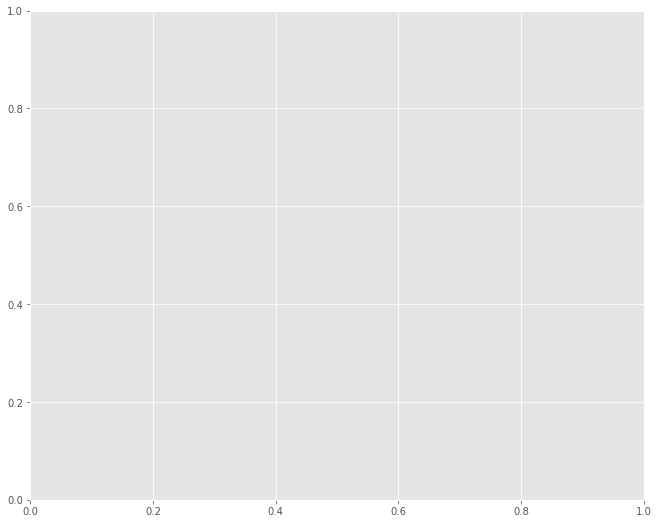

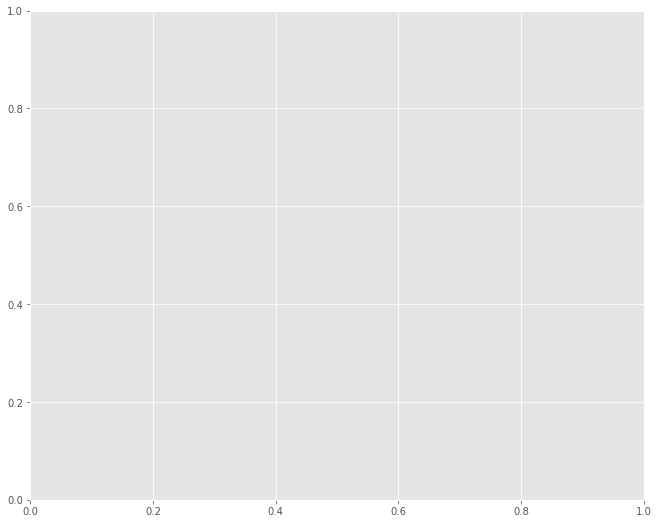

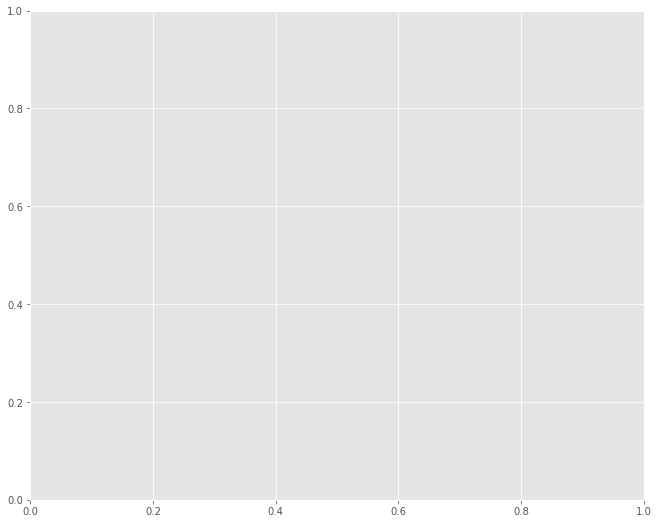

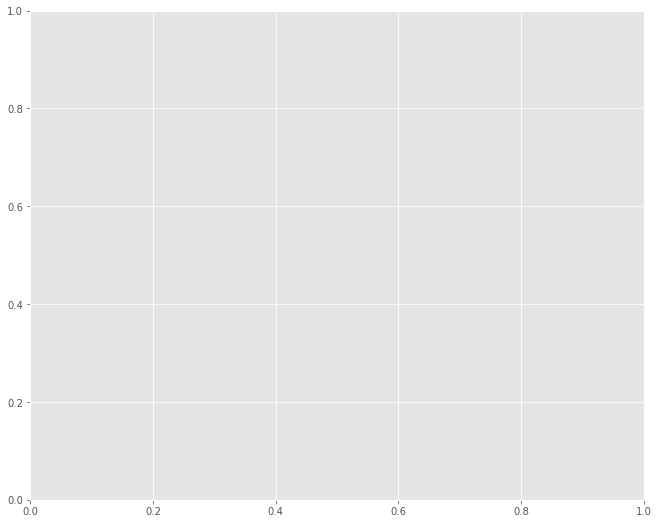

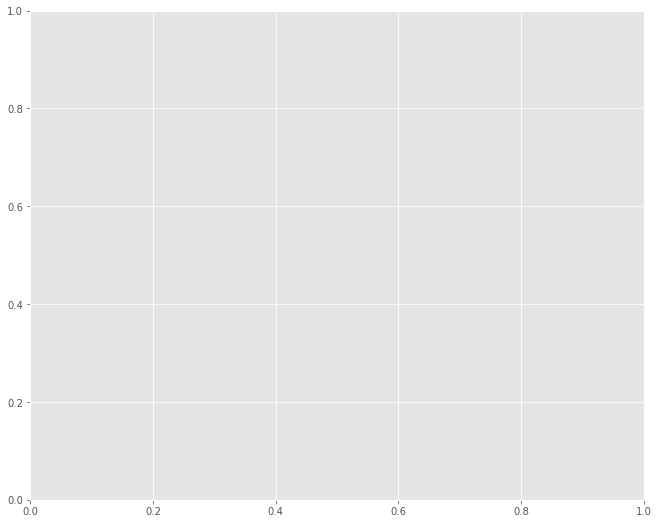

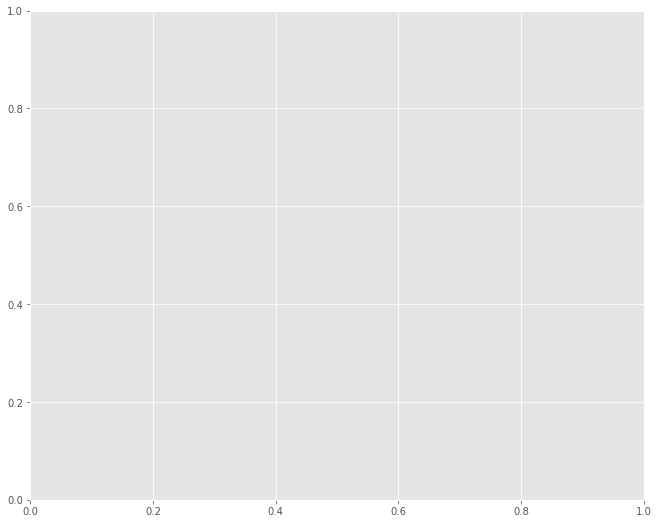

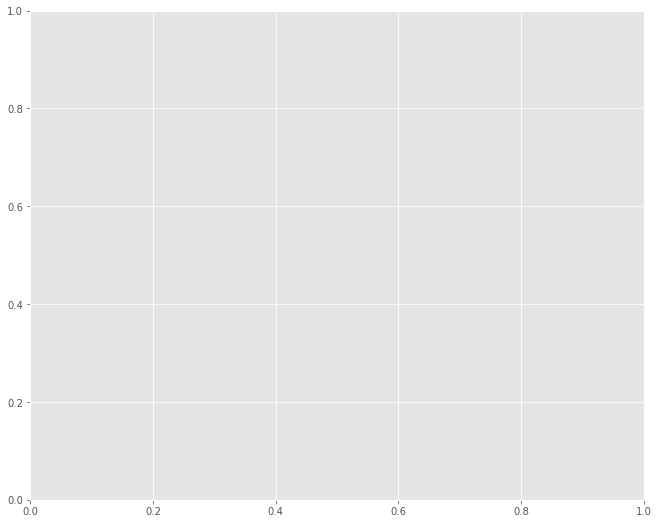

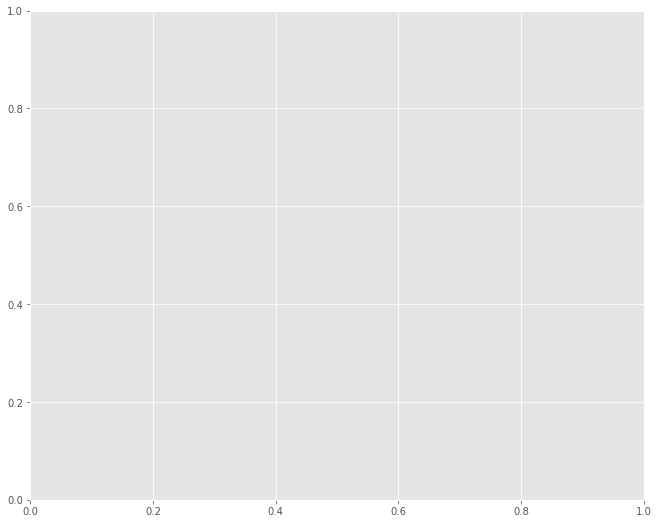

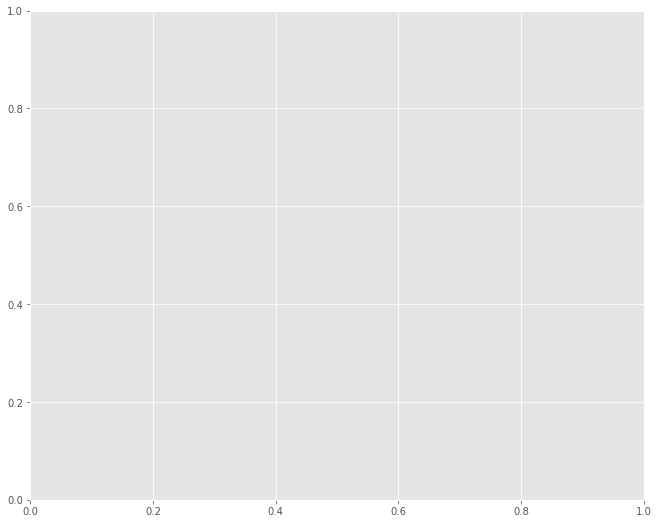

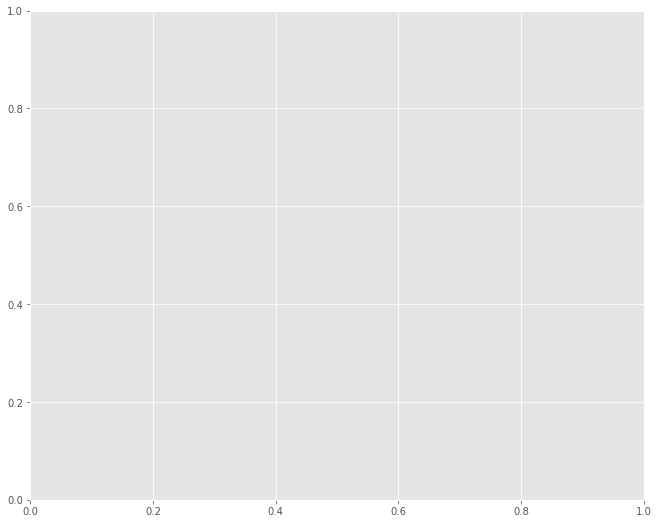

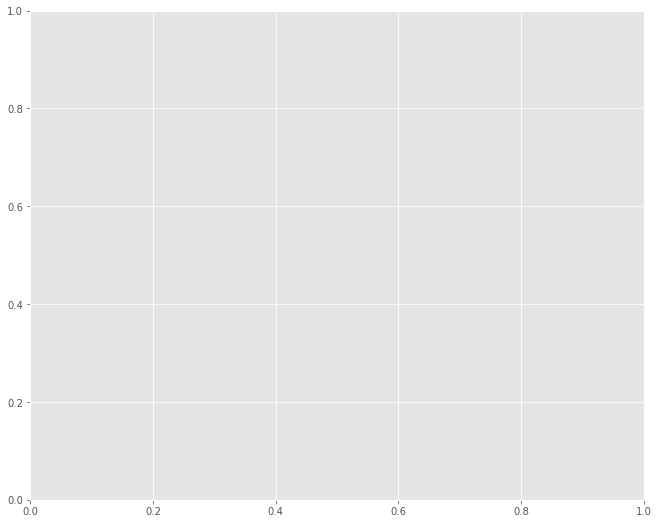

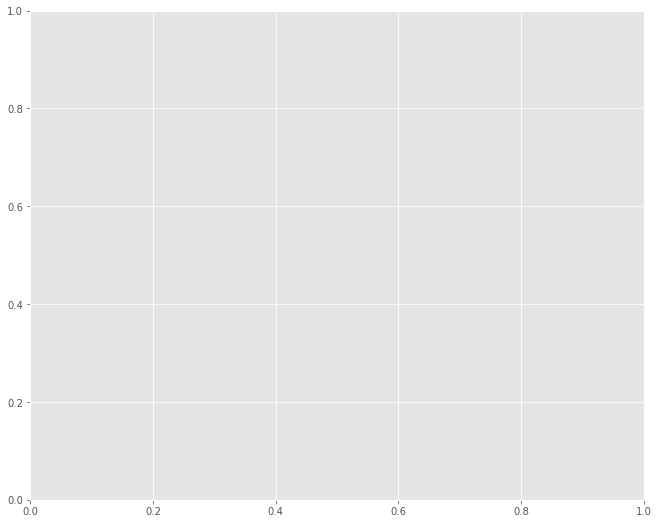

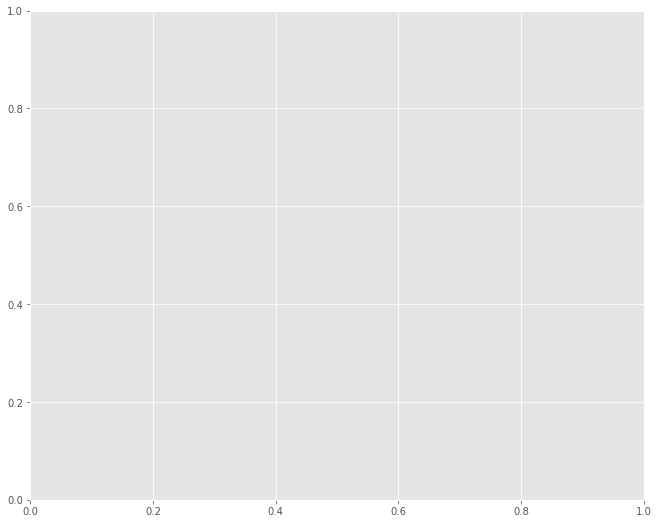

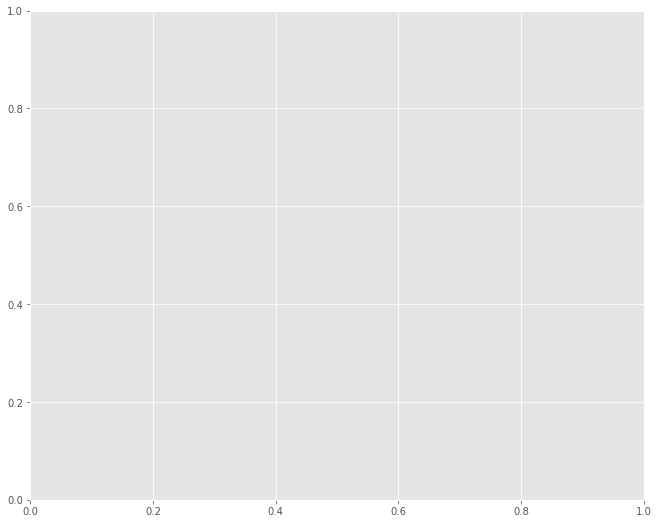

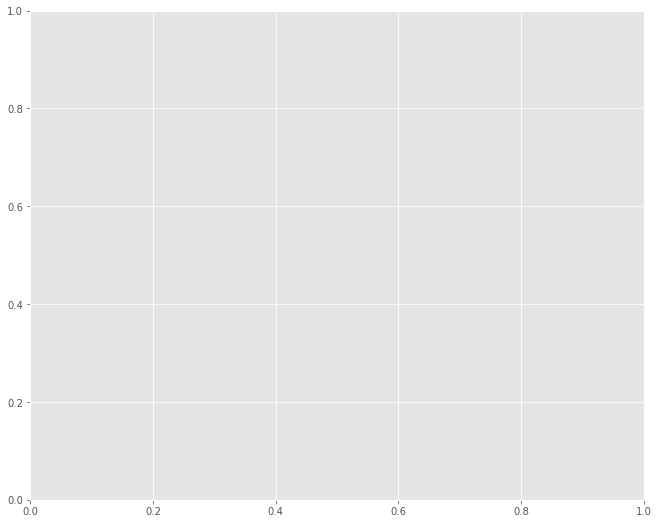

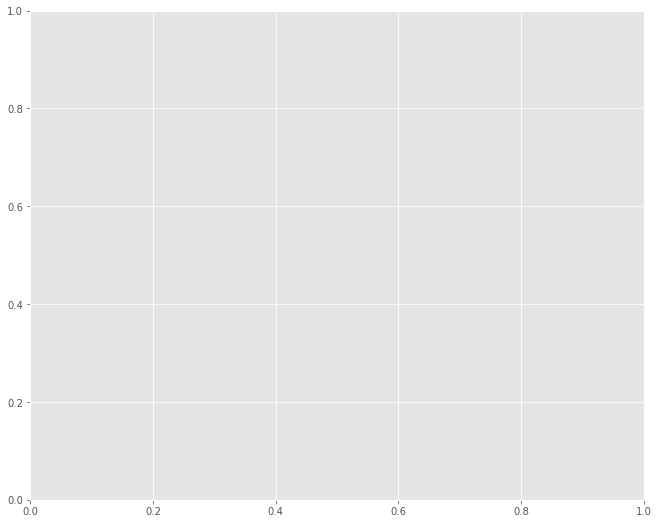

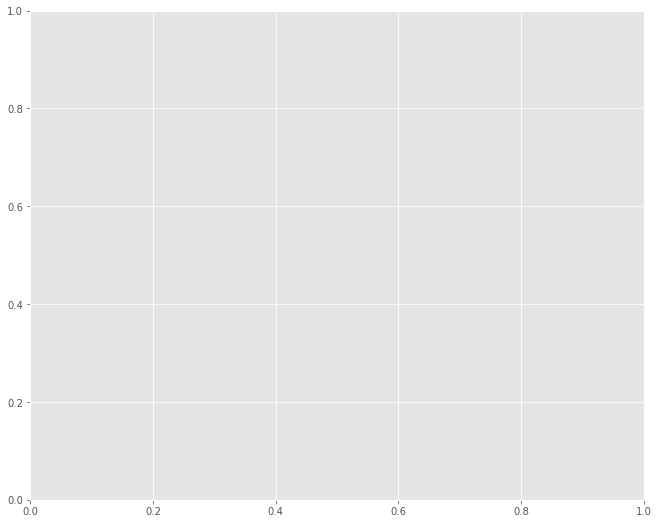

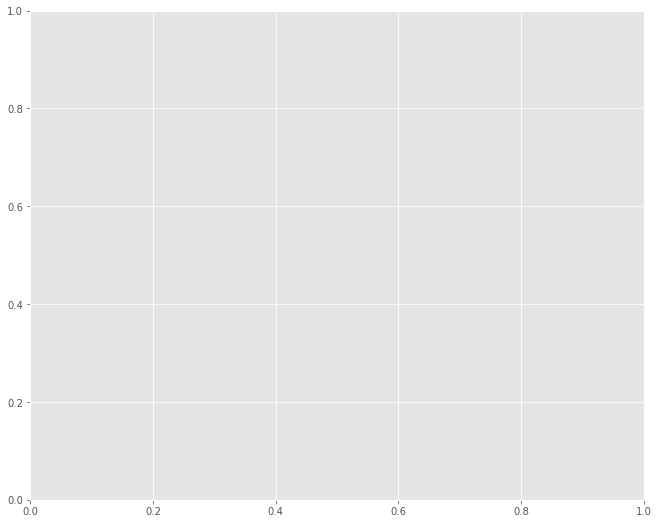

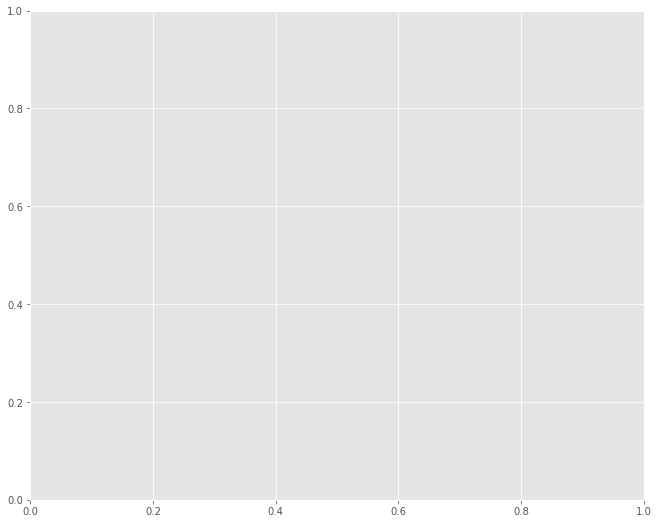

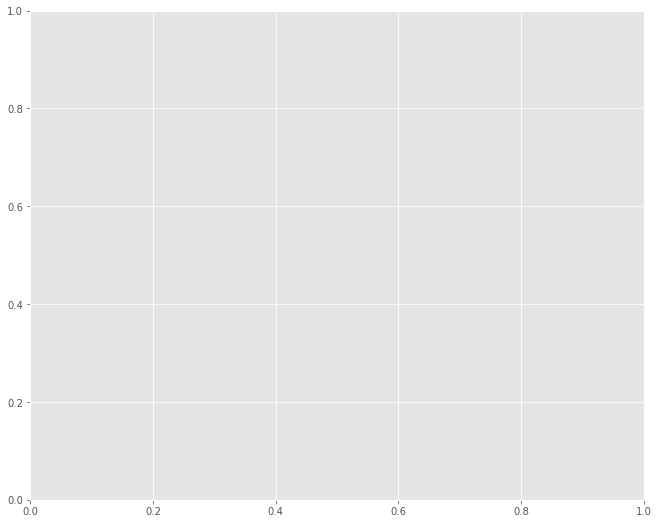

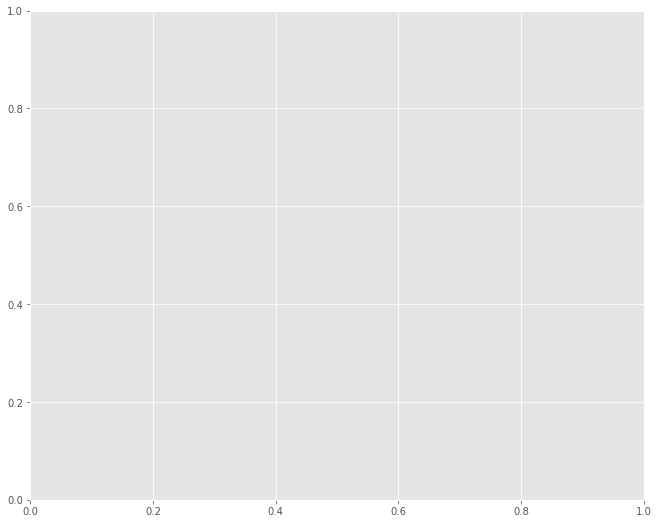

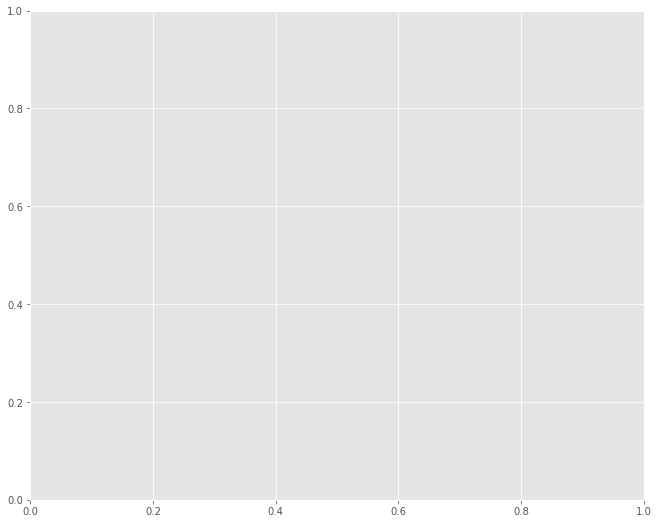

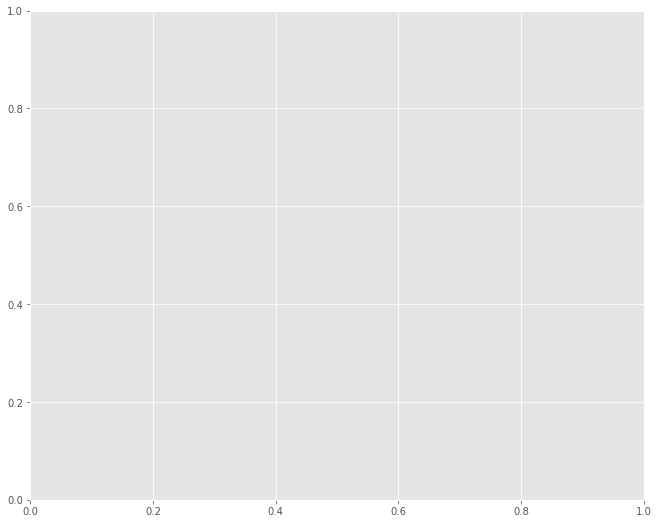

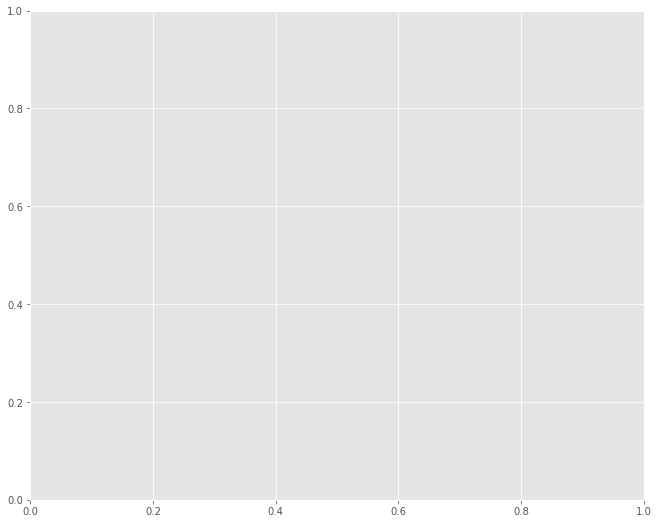

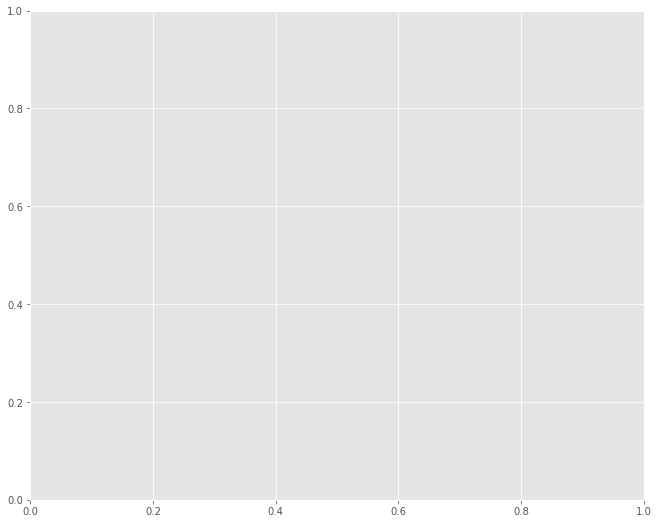

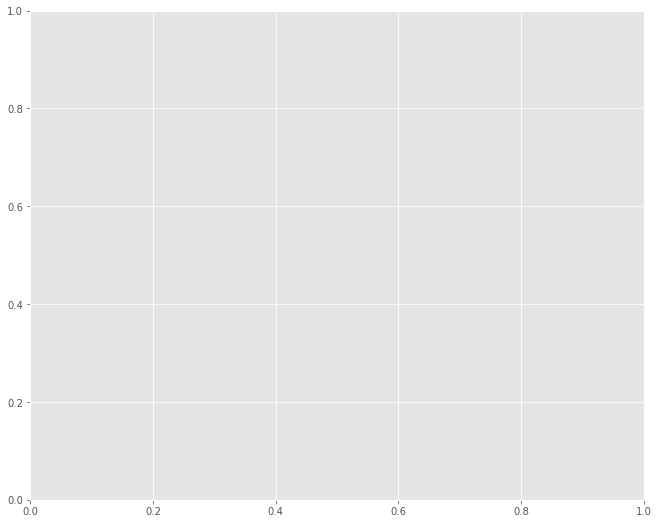

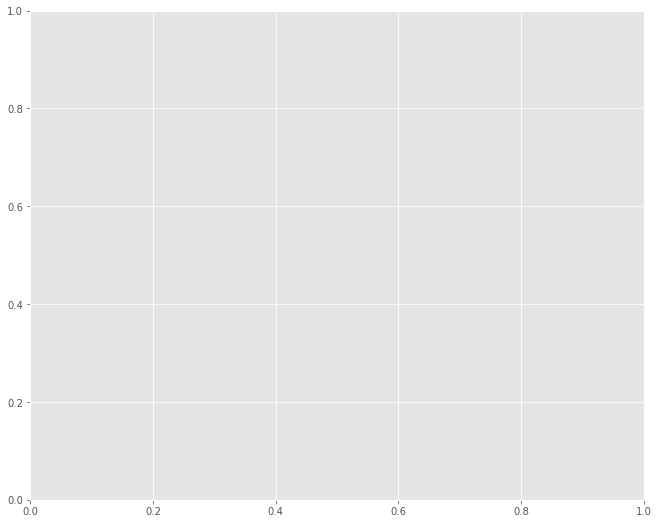

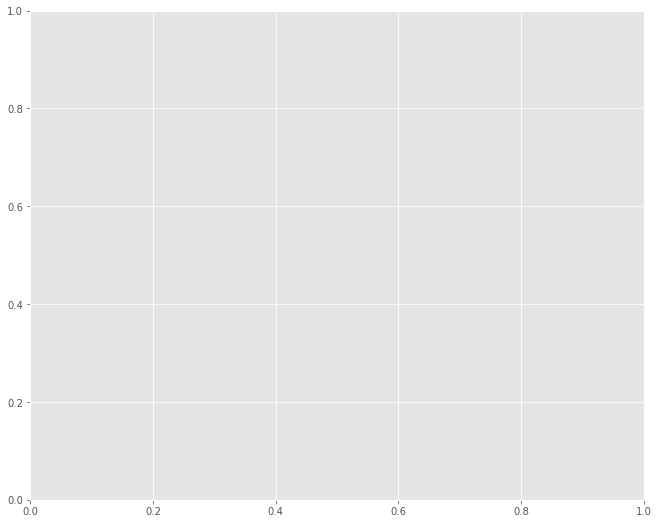

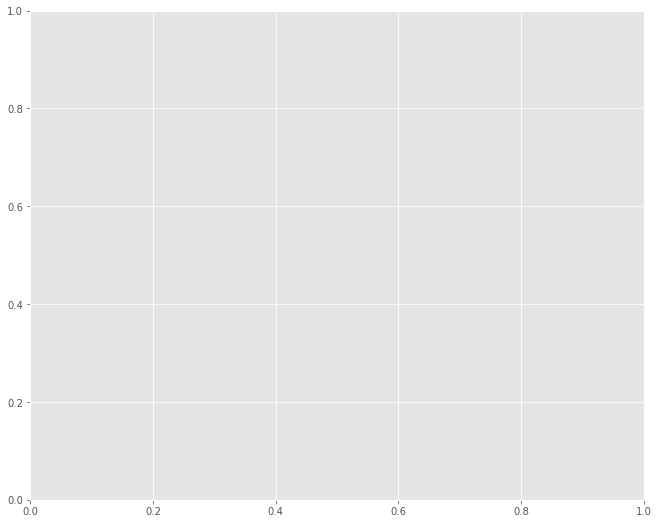

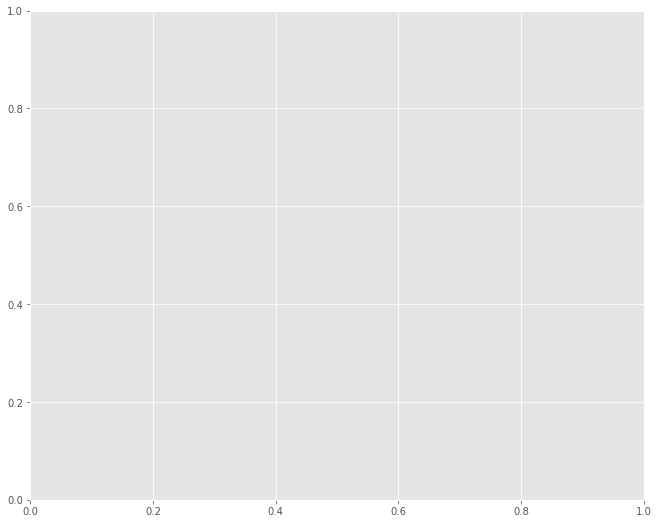

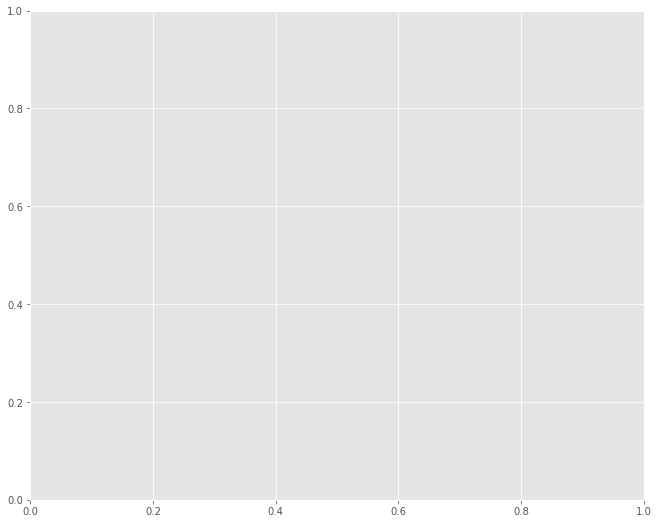

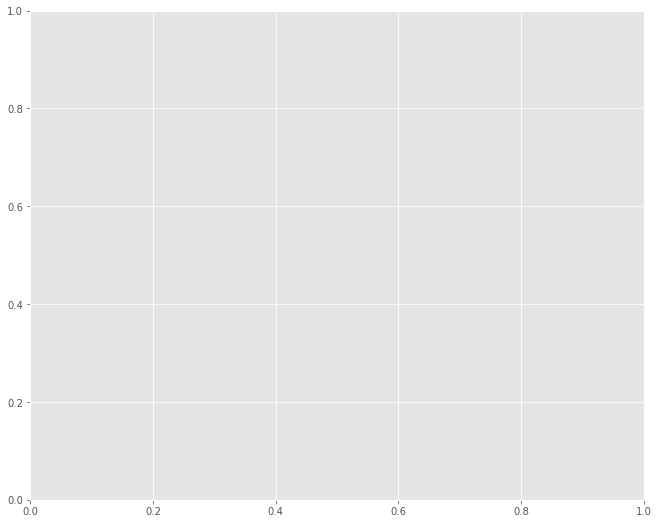

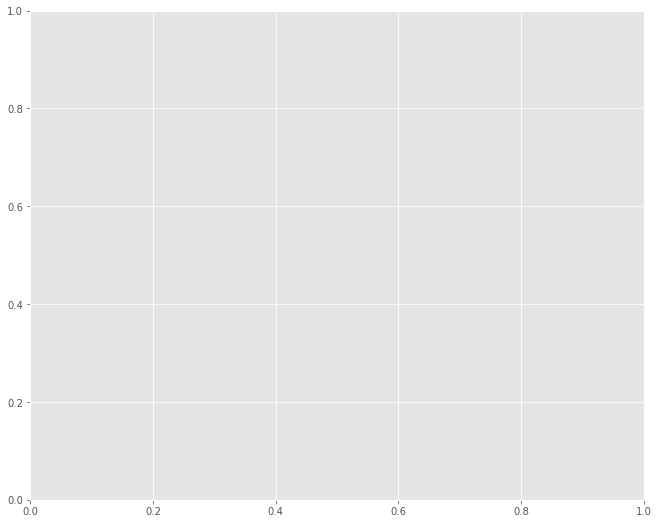

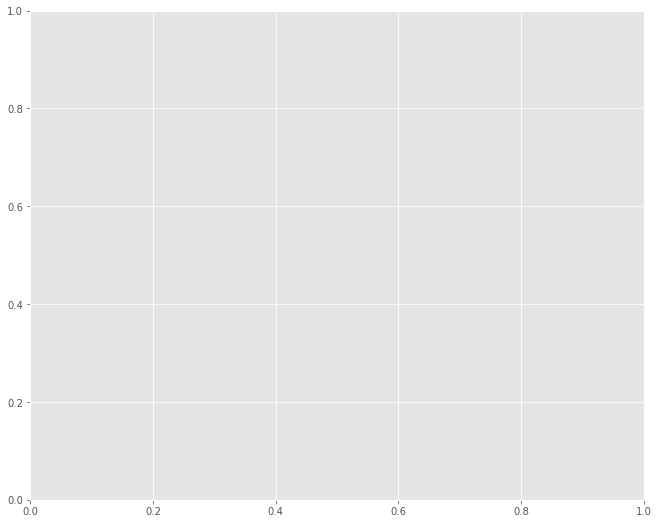

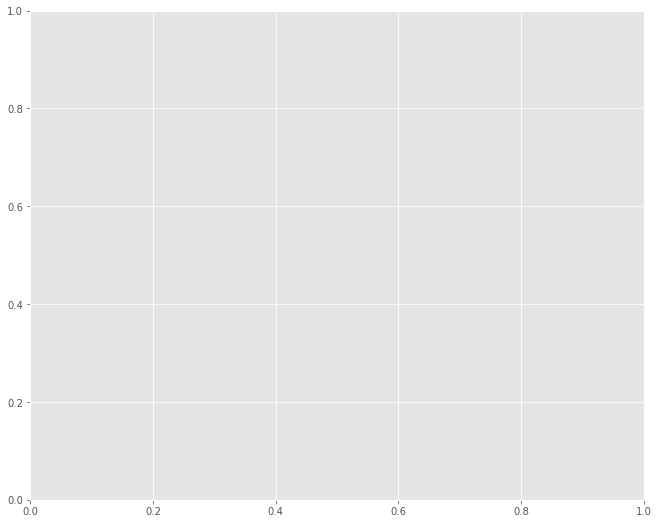

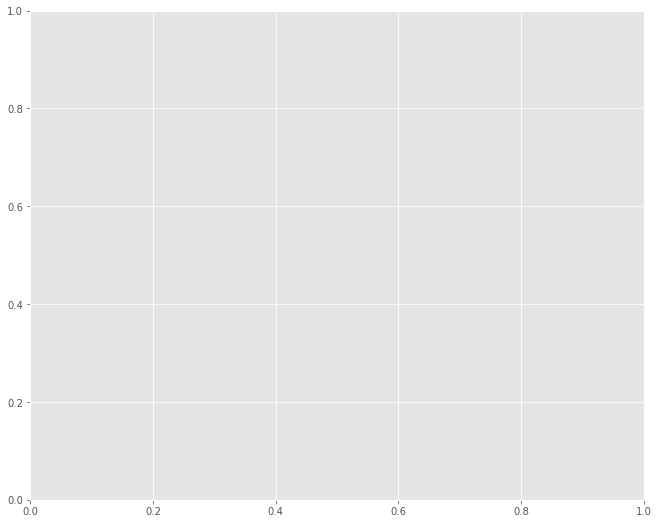

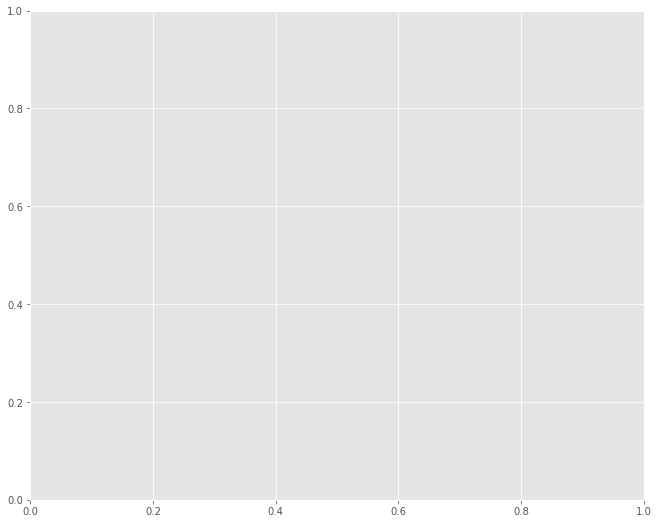

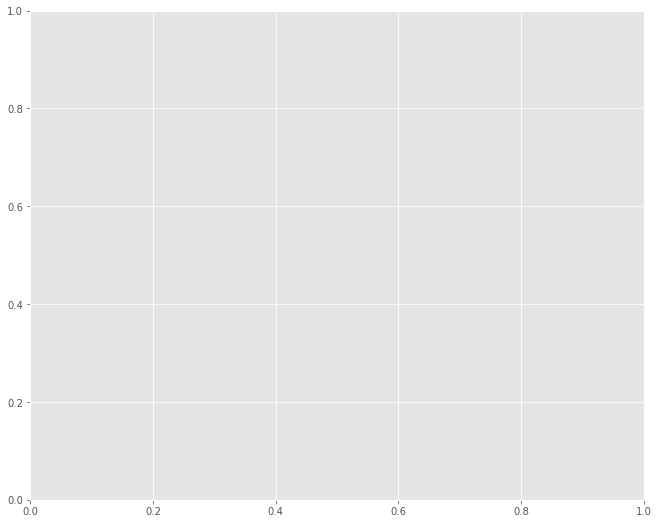

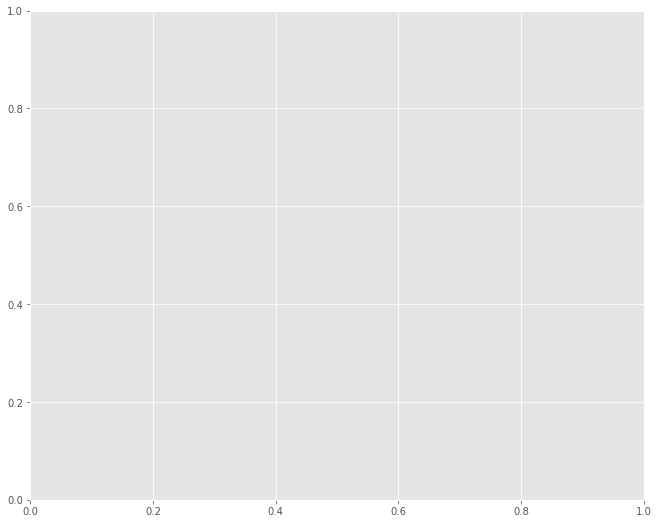

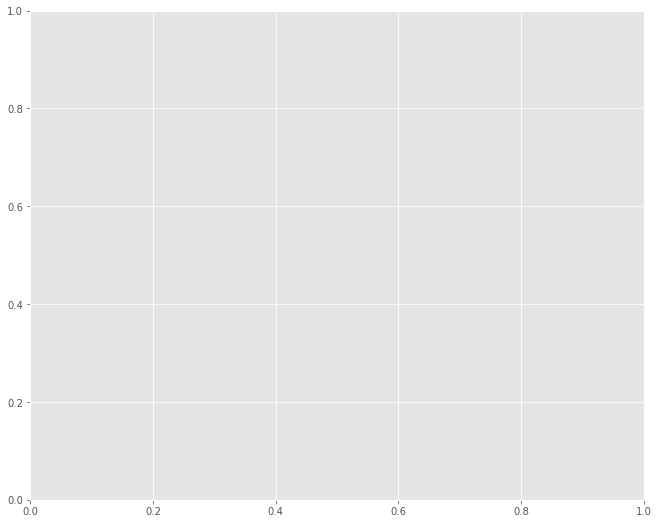

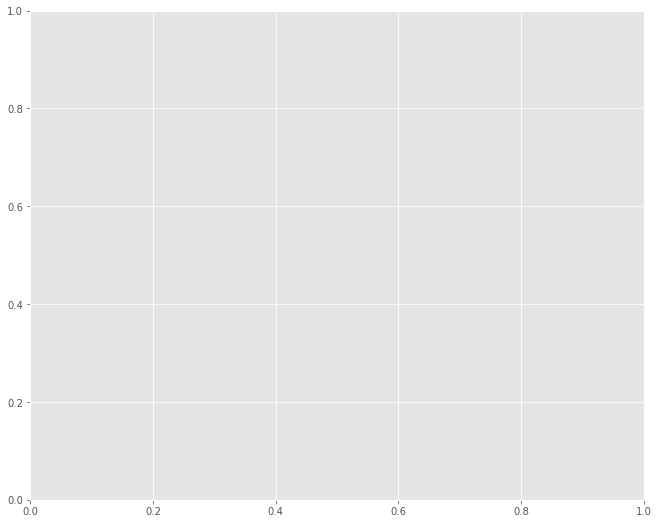

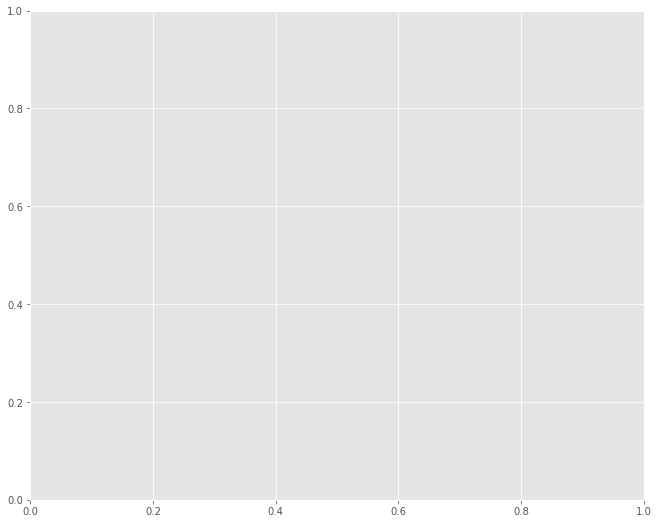

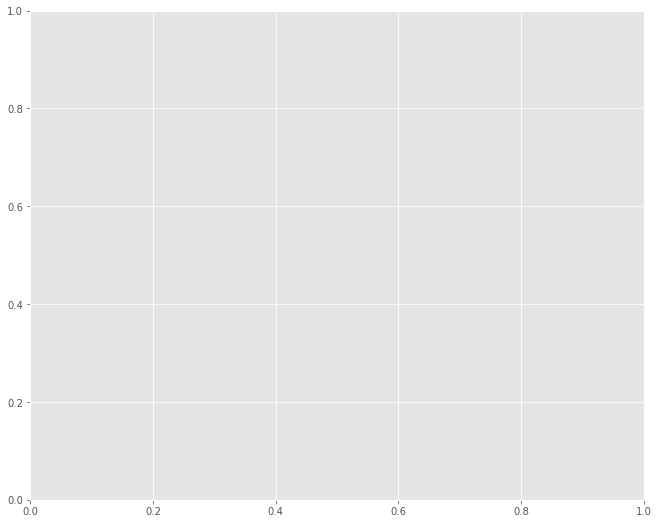

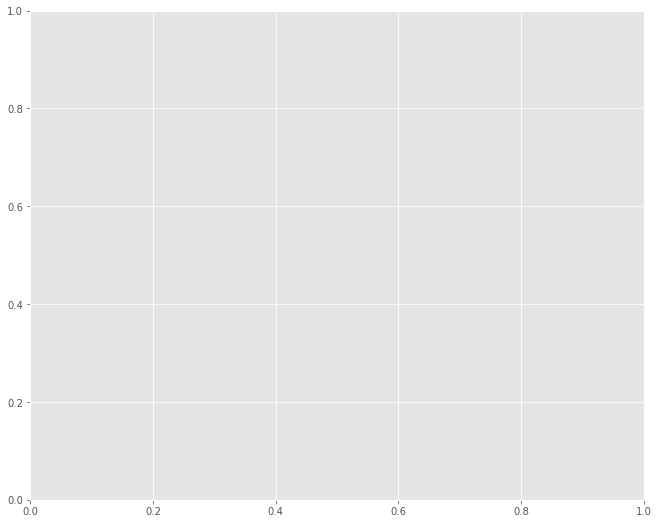

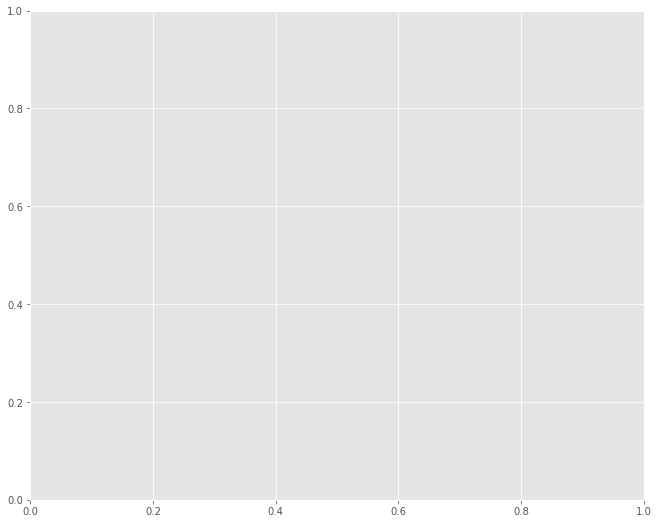

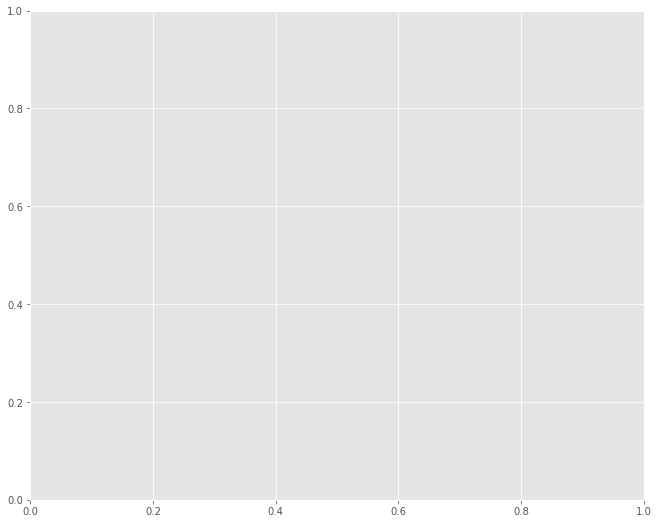

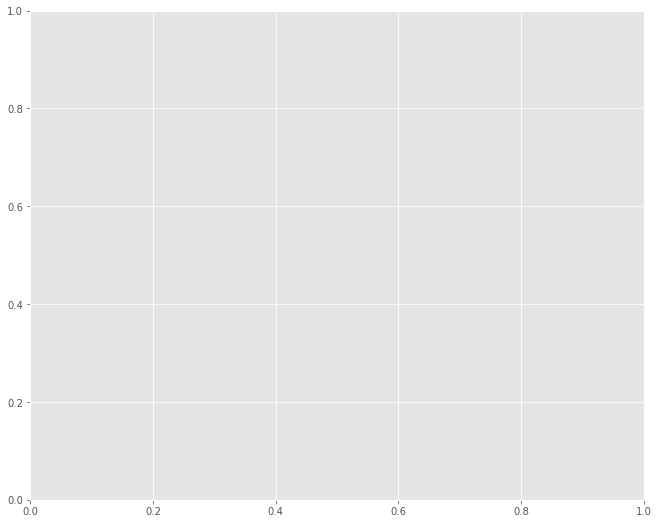

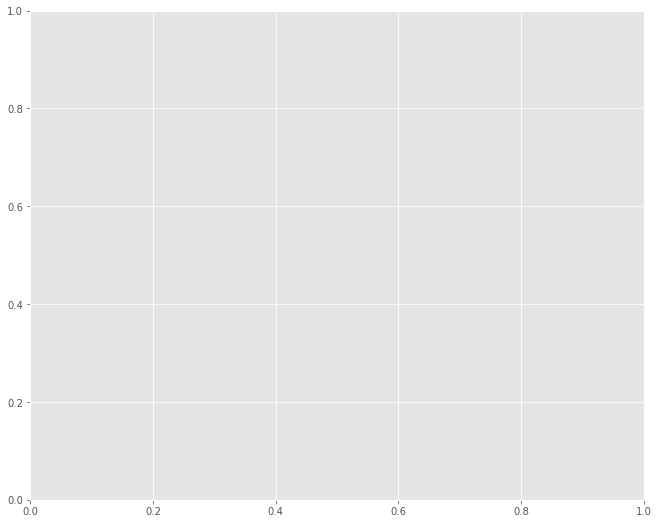

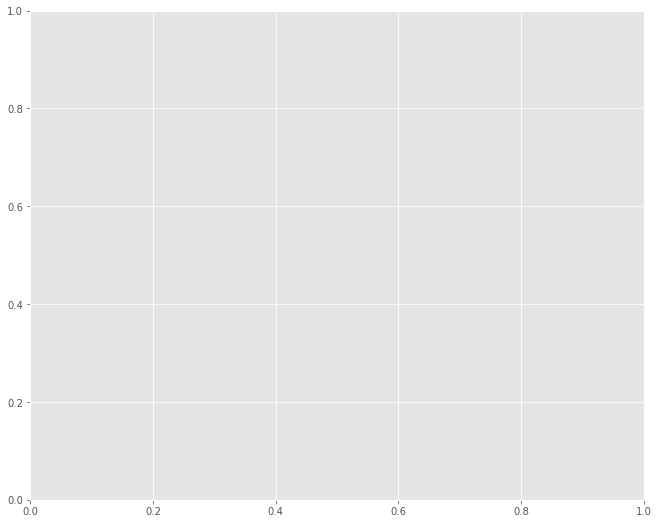

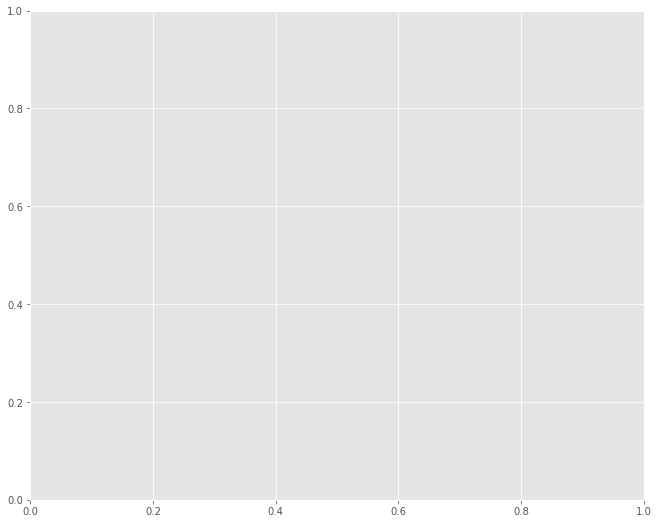

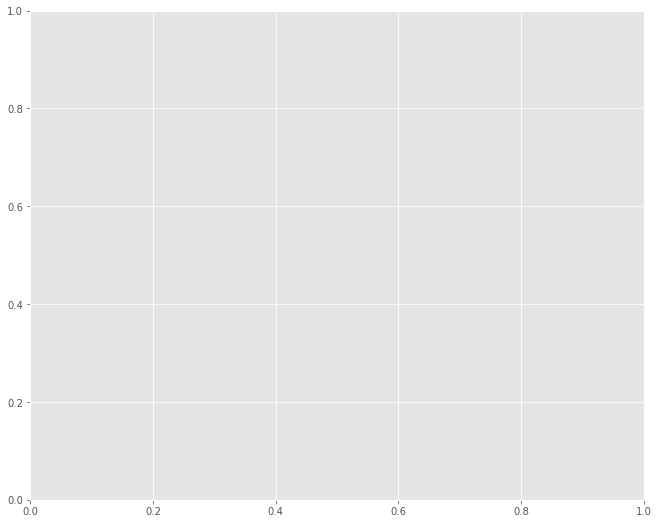

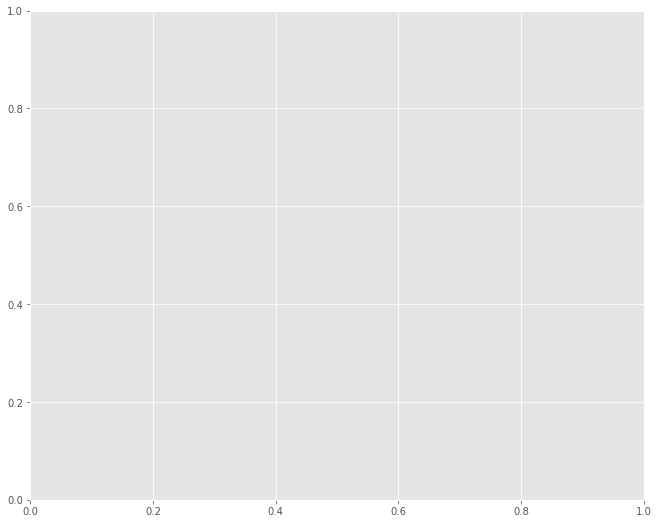

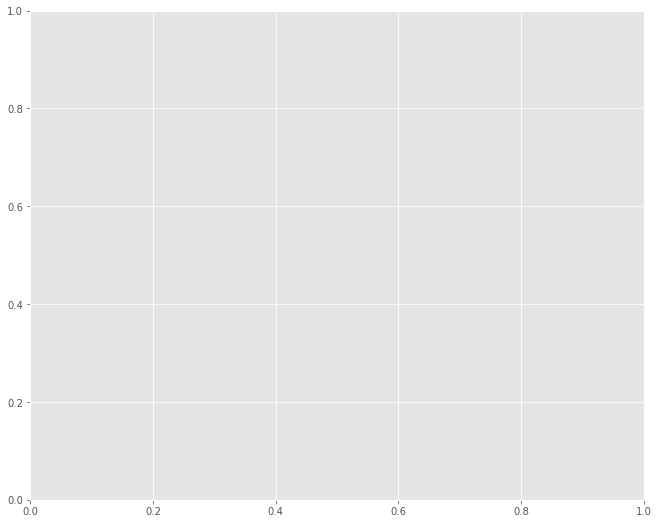

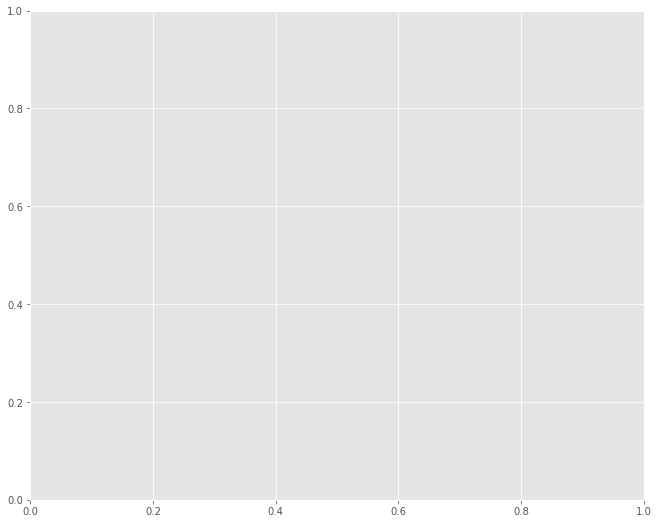

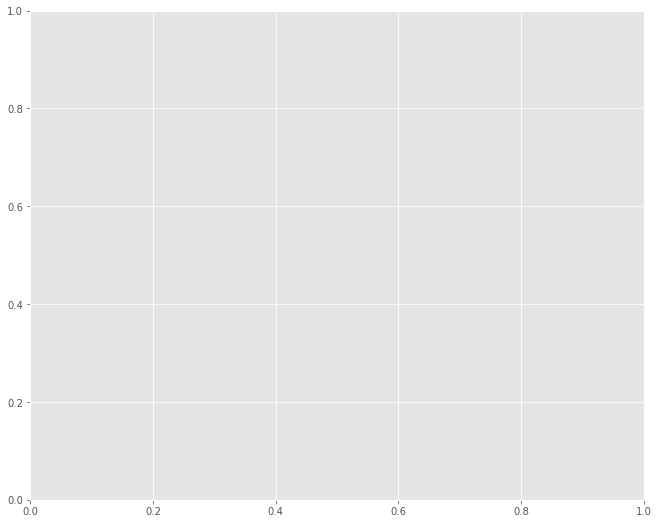

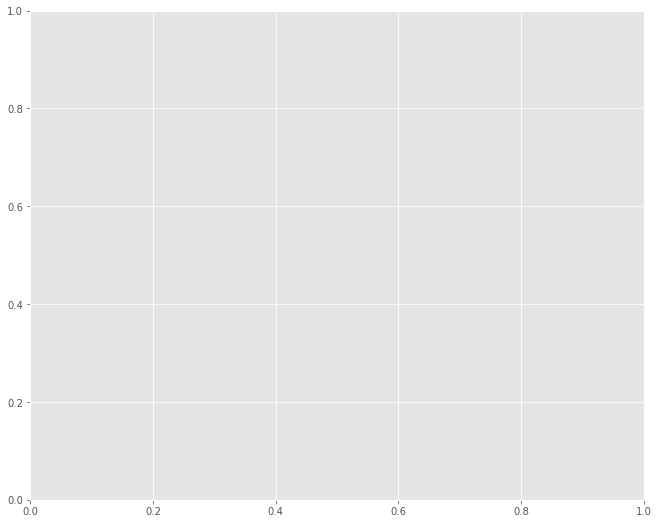

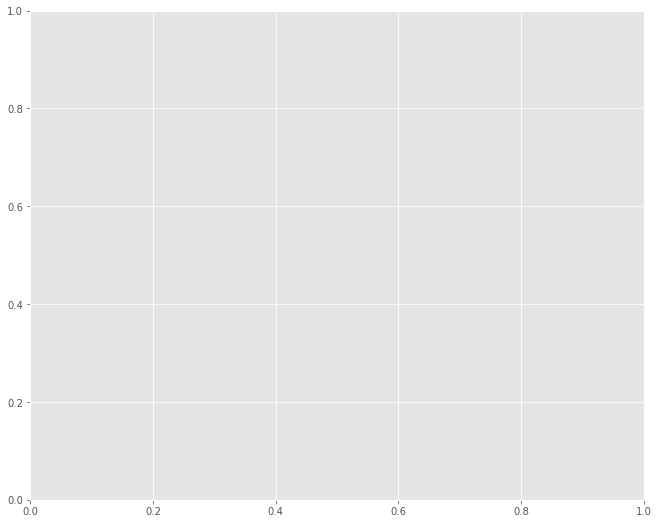

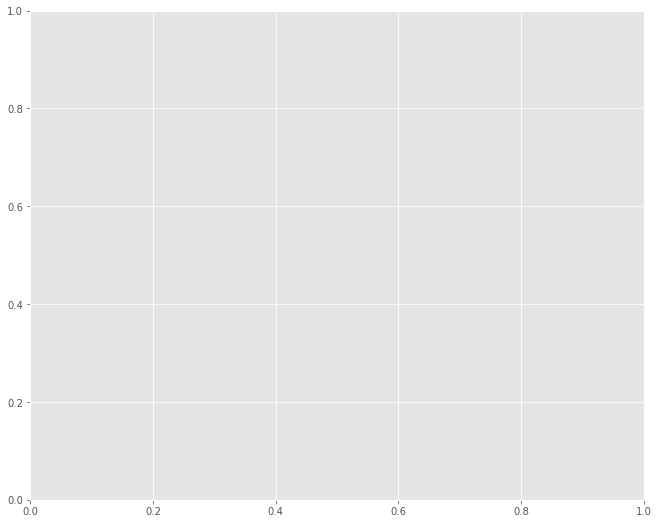

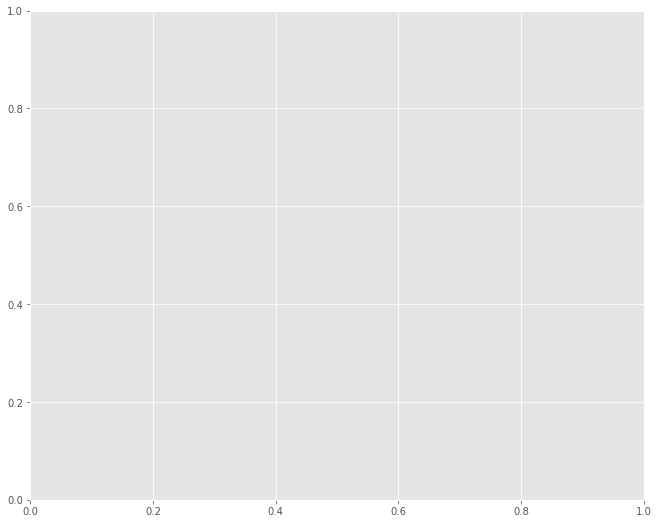

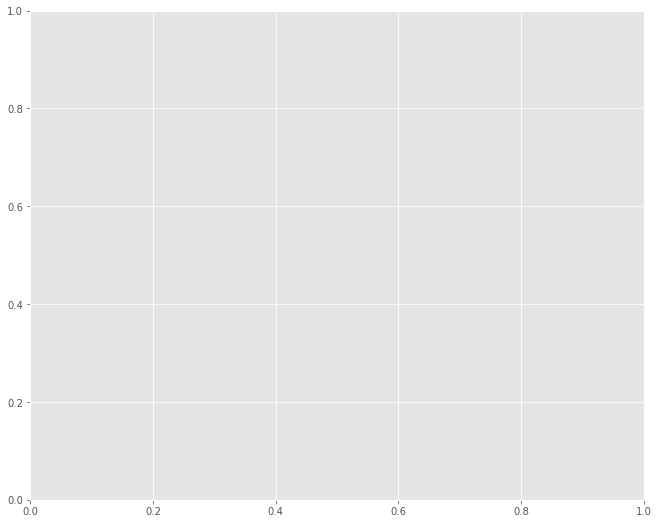

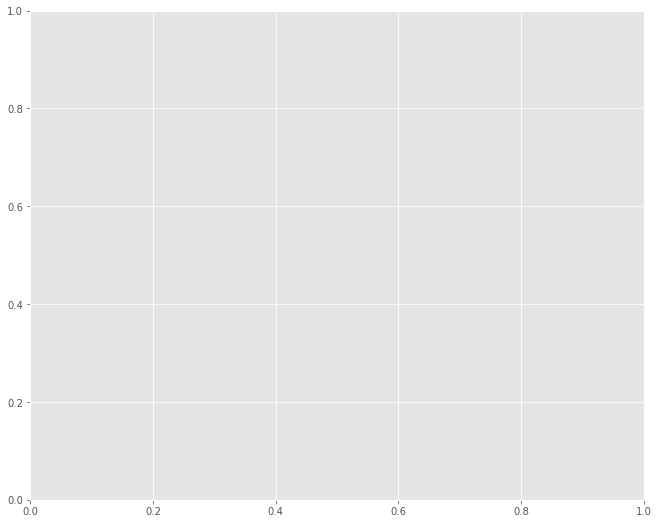

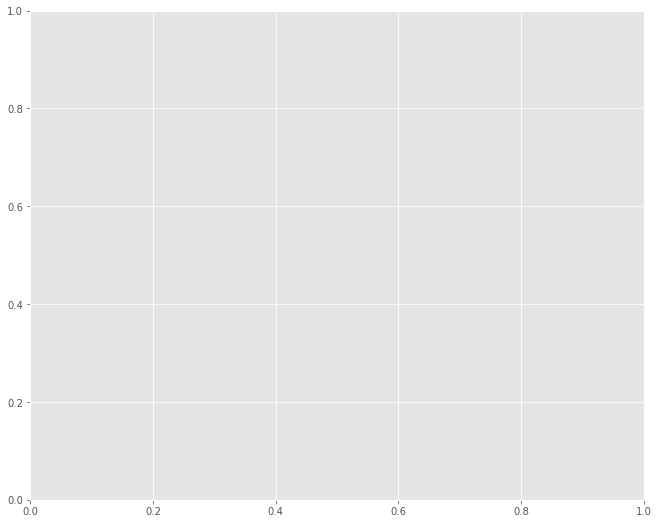

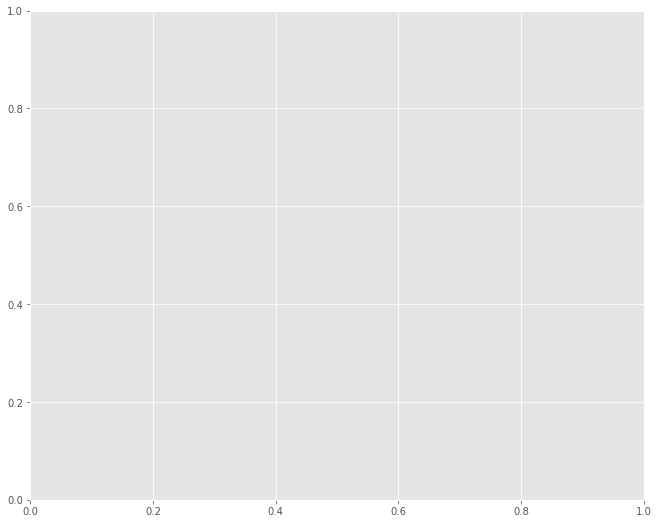

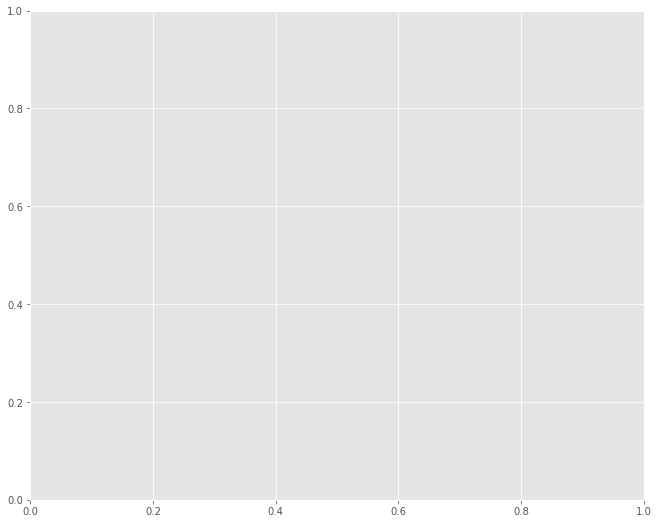

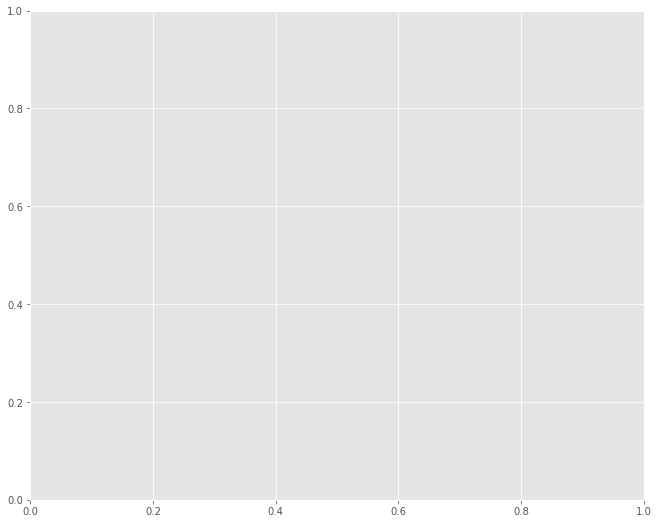

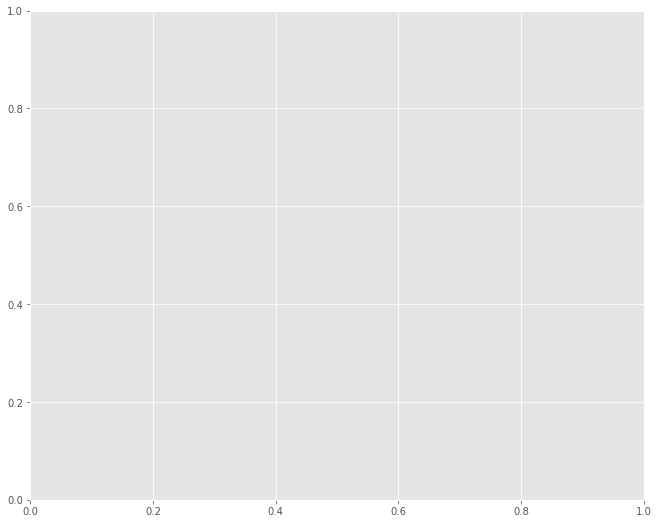

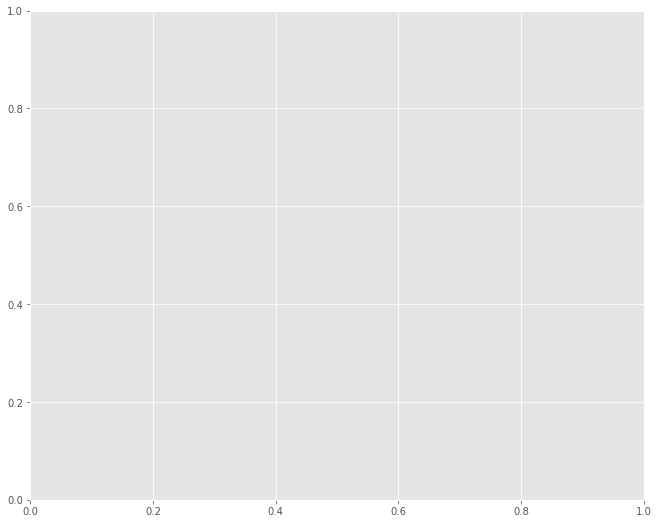

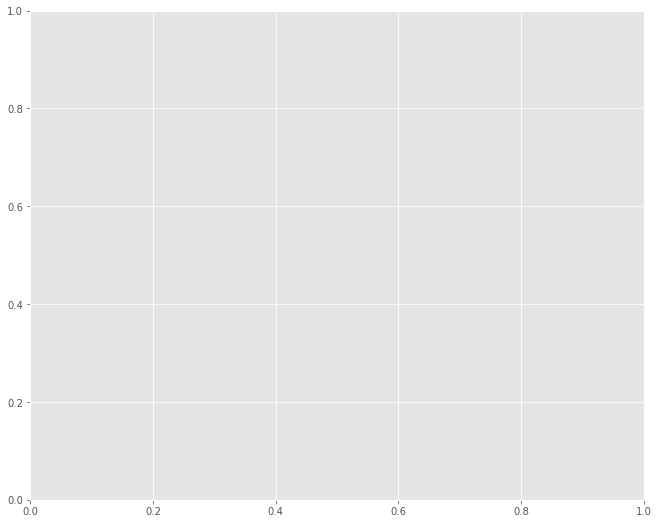

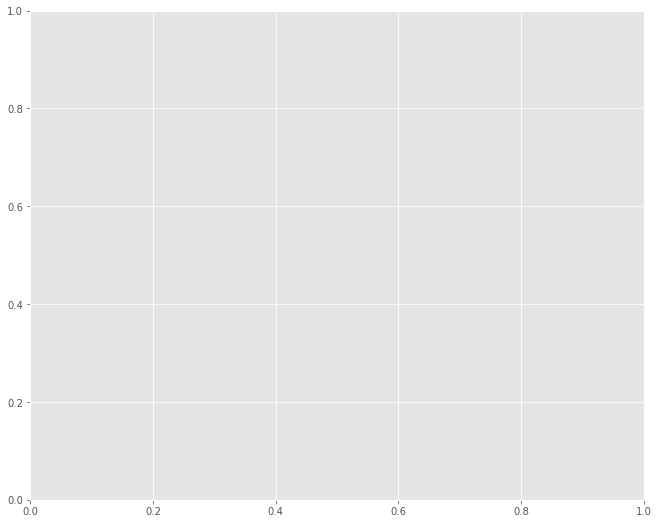

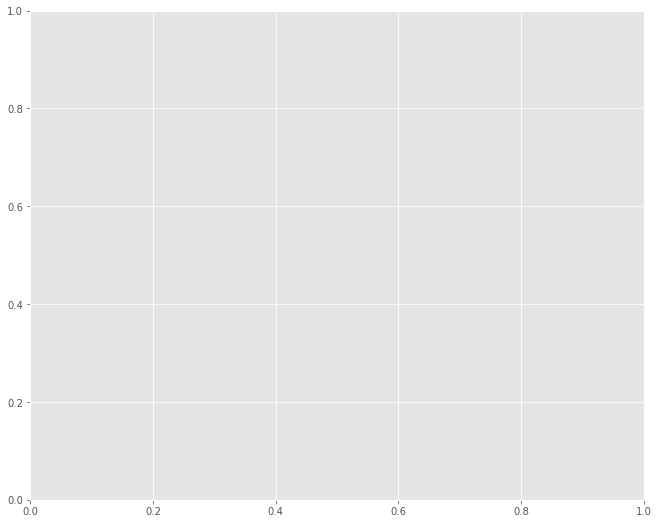

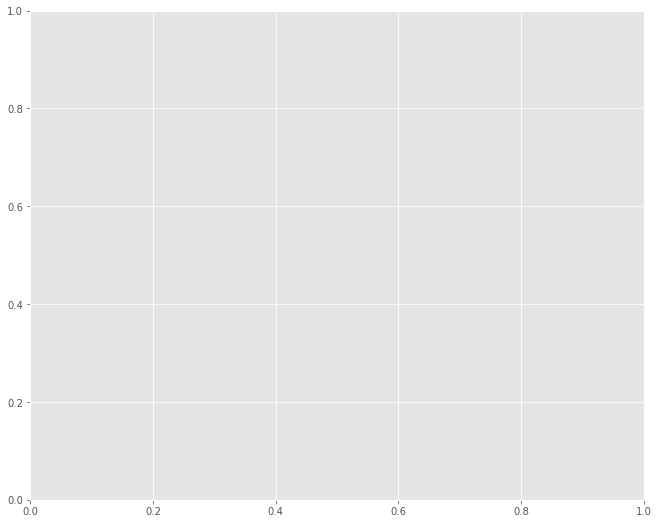

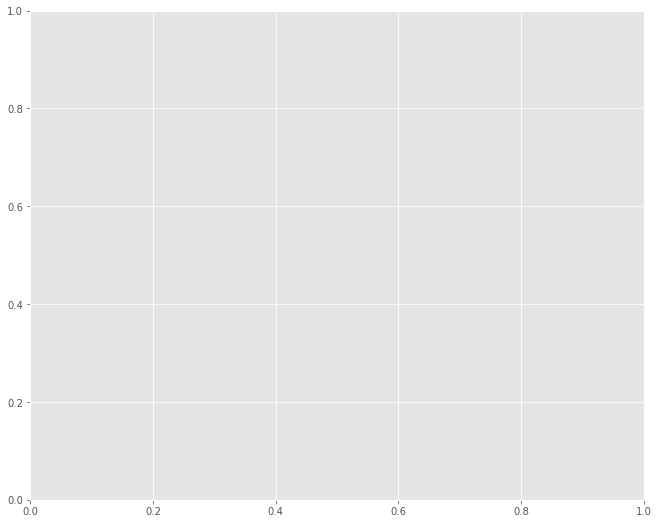

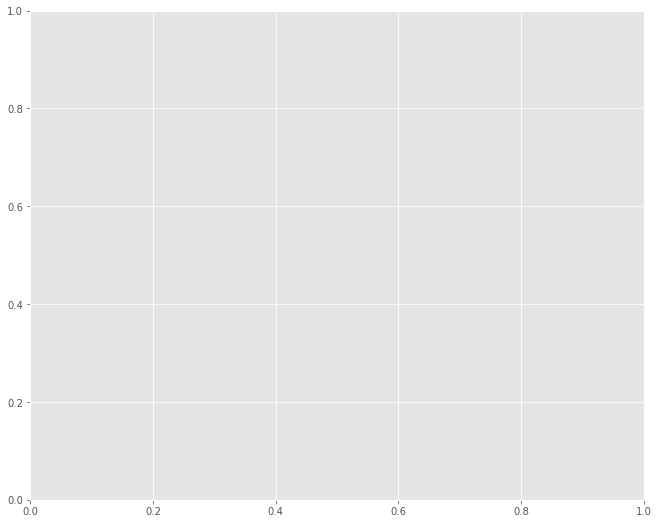

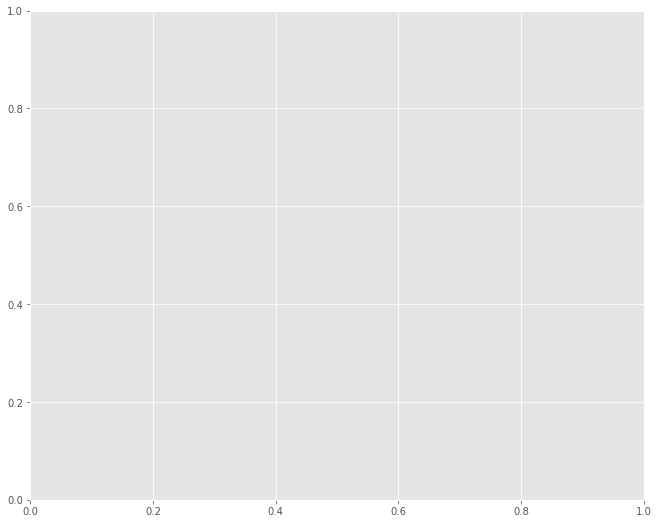

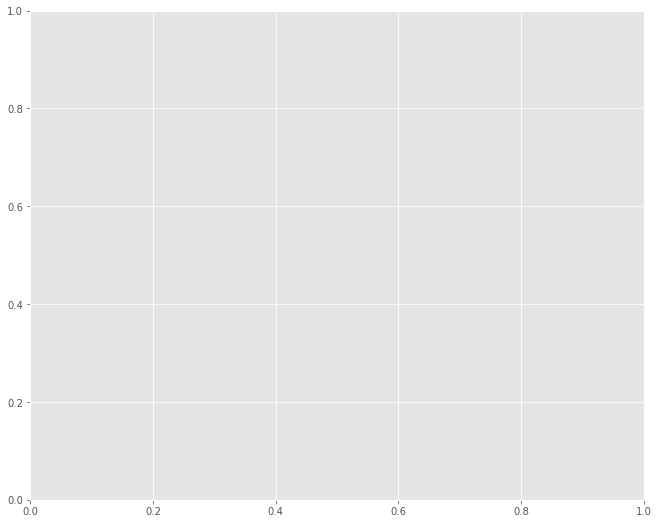

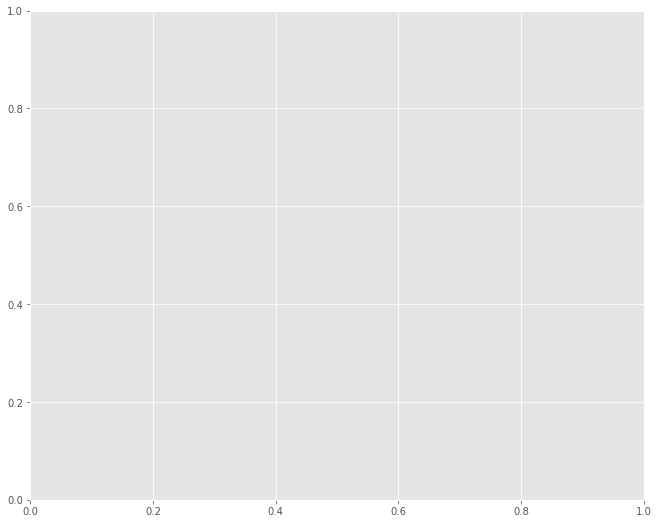

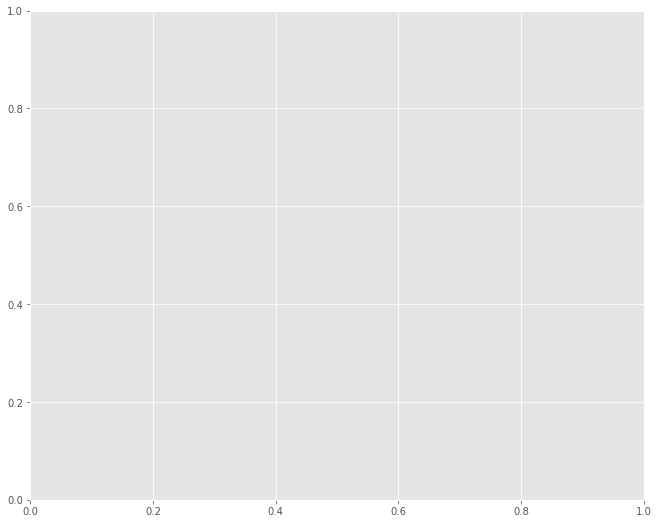

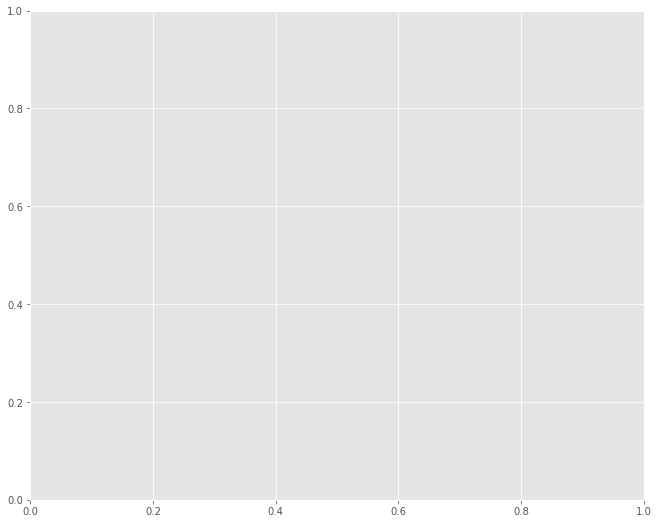

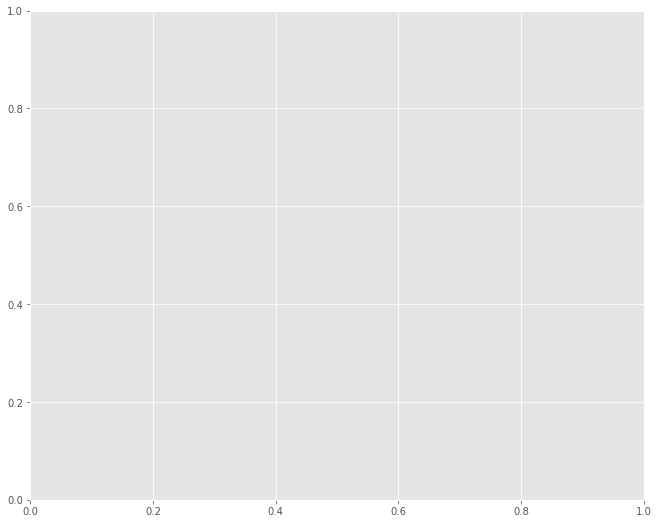

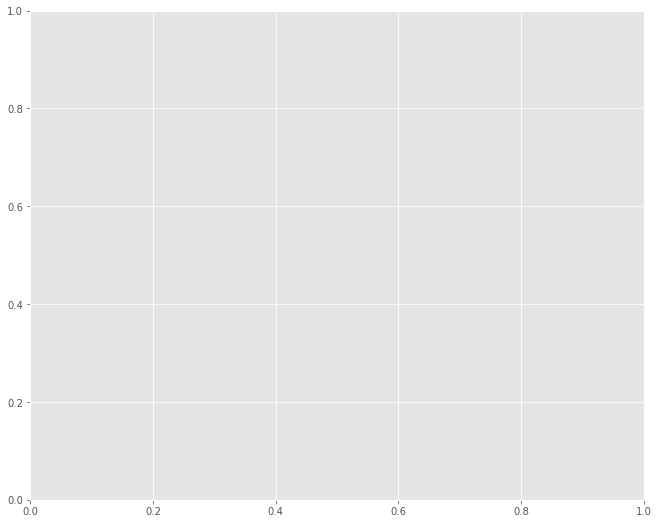

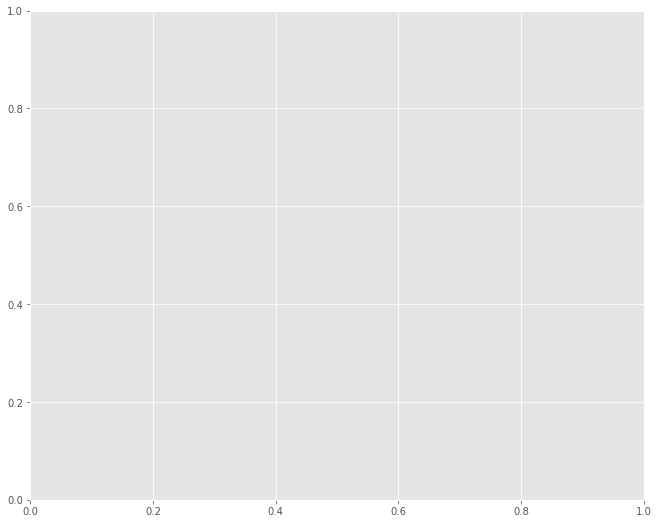

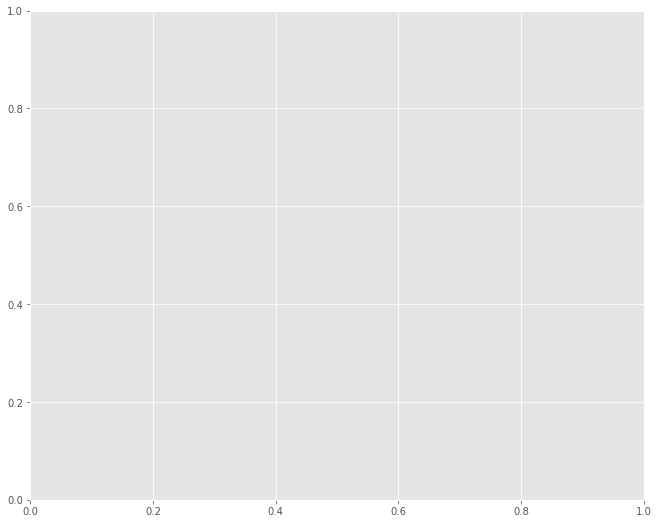

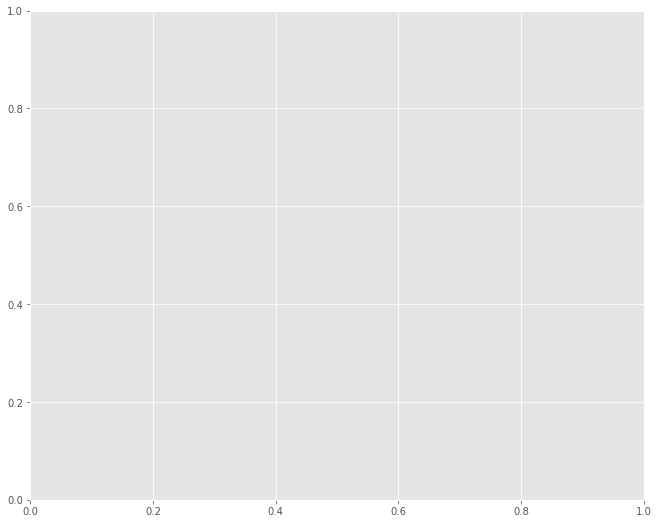

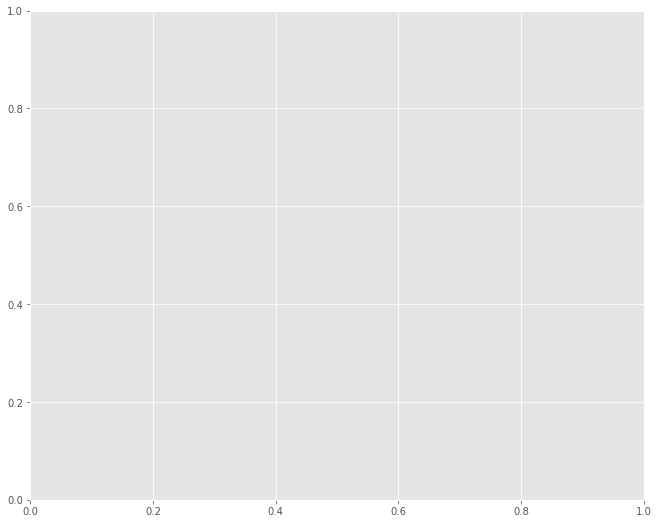

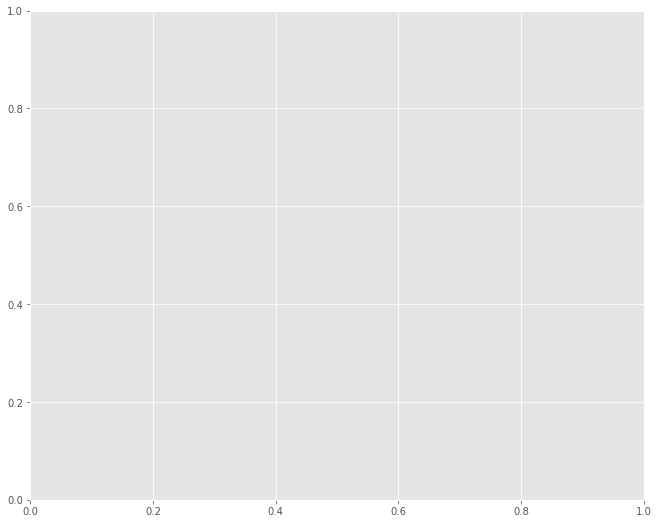

In [249]:
for actor in names_title_dict:
    fig, ax = plt.subplots(figsize=(11, 9))
    # https://stackoverflow.com/questions/41964618/boolean-matrix-form-pythons-dict-of-lists
    values = names_title_dict[actor]
#     print(actor,values)
    data = {}
    boolean_table_name_cols = pd.DataFrame(data, index=values)

    for key in names_title_dict:
        print(key)
        data[actor] = [True if value in names_title_dict[key] else False for value in values]
        bool_actors = pd.DataFrame(data[actor])
#         for index in boolean_table_name_cols:
#             boolean_table_name_cols.append(data[actor])
        boolean_table_name_cols.append(bool_actors)
    boolean_table_name_cols    
#         sb.heatmap(boolean_table_name_cols)
#     plt.GridSpec(boolean_table_title_cols,ncols=len(values))
#     plt.show()

In [230]:
boolean_table_name_cols

Empty DataFrame
Columns: [tt4687632, tt4780202, tt0050327, tt1505388, tt11011652, tt2671586, tt0072562, tt1587314, tt0047472, tt1571249, tt3650844, tt6512646, tt0116783, tt0052932, tt3859146, tt5648234, tt0076781, tt3458560, tt0162349, tt0049578, tt3218622, tt0120800, tt0468999, tt0111333, tt0072265, tt1877853, tt2378652, tt0759475, tt1478338, tt0076598, tt0104254, tt0090631, tt0368257, tt3696804, tt0380060, tt0087348, tt0094449, tt1608290, tt0359950, tt3872944, tt0393274, tt11940818, tt0904115]
Index: []

[0 rows x 43 columns]

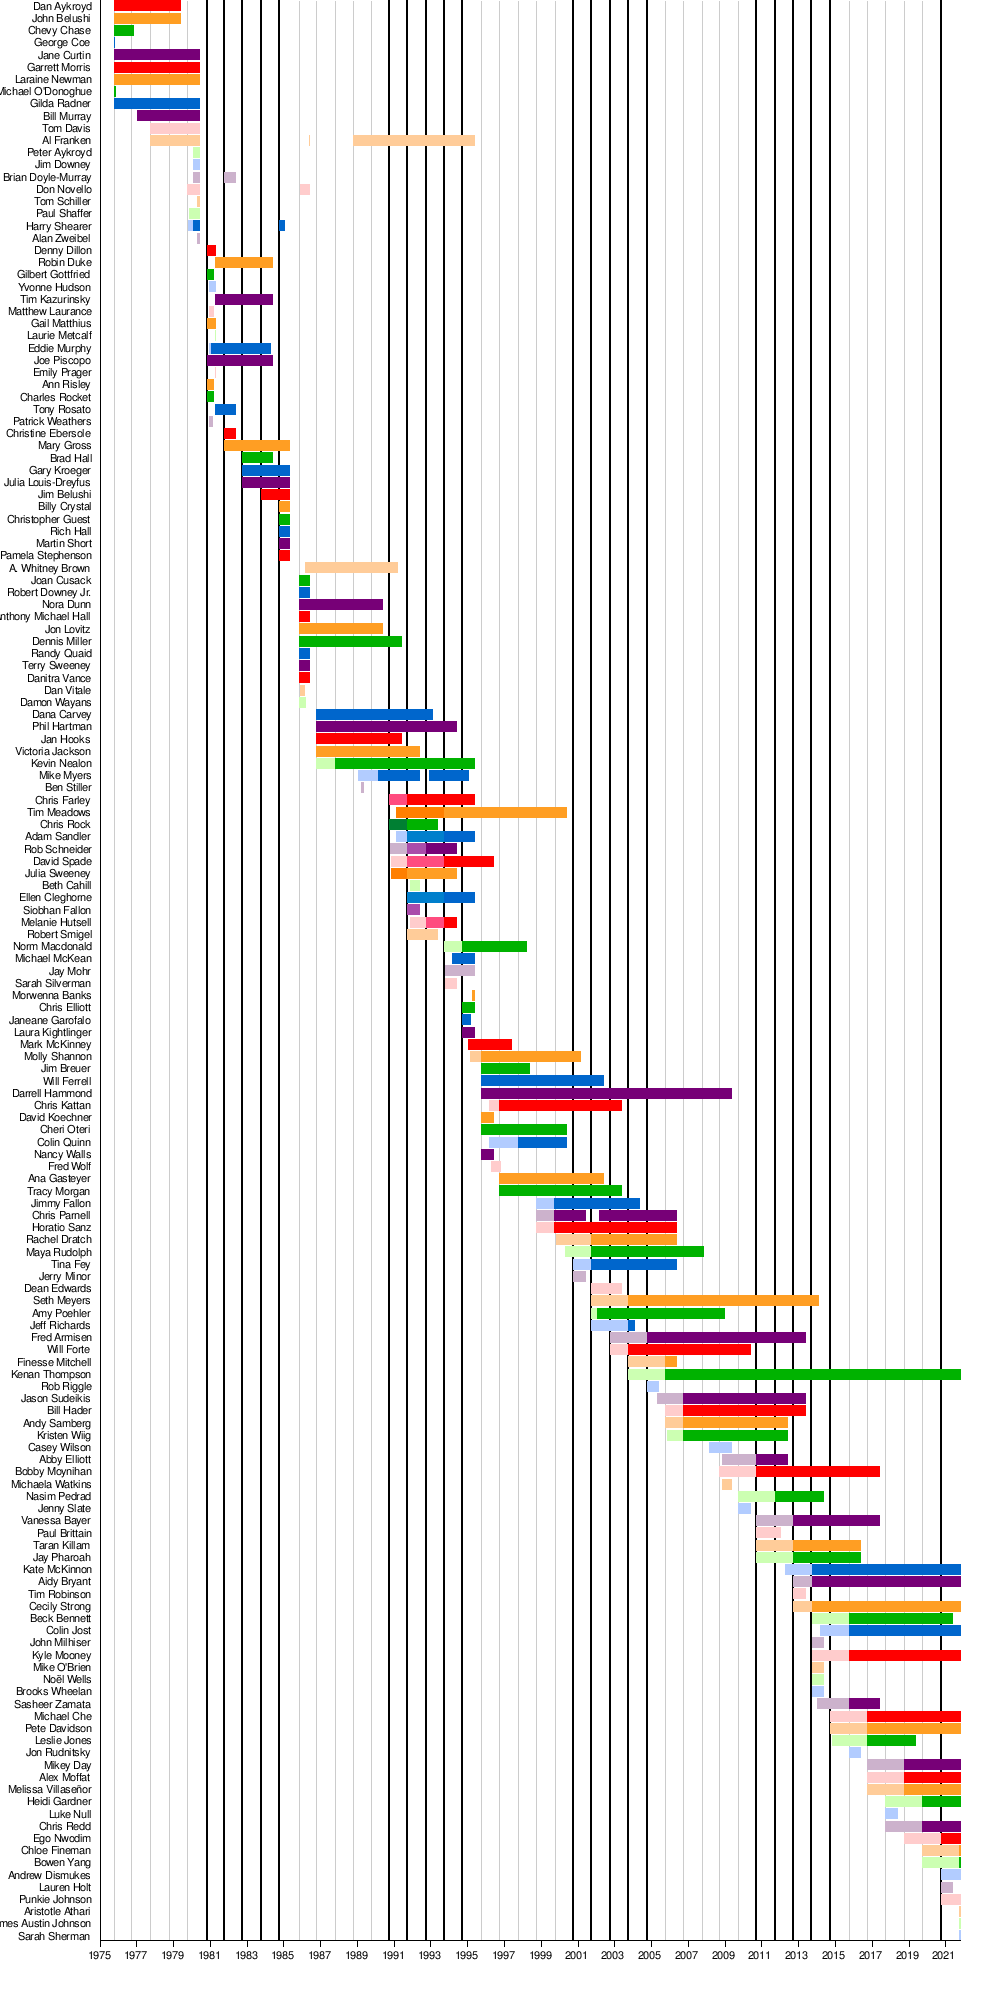

In [247]:
from IPython import display
display.Image('wiki_cast_members_timeline.png')
